# Survey data 

Analysis after (phase 2) data collection completed.

Using survey data only (no Amazon data)

- Analysis for behavior experiments
    - what impacts sharing behavior?
        - how does share rate differ by experiment arm?
        - how does share rate differ by demographic group?
        - and more...
    - what is the difference between how real monetary bonuses impact sharing vs hypothetical monetary bonuses?
- Analysis for other survey questions

Also check:

- Data validation: is the number of completions consistent across experiment arms?
- Overall share rate

In [1]:
import re

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chisquare
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_filepath = '../data/survey-data/survey.csv'
fields_filepath = '../data/survey-data/fields.csv'

### Reading in data and minor transforms

In [2]:
# Reminder: Here are the fields
fields_df = pd.read_csv(fields_filepath, index_col=0)
fields_df

,fields
Duration (in seconds),Duration (in seconds)
RecordedDate,Recorded Date
ResponseId,Response ID
Q-prolific,What is your Prolific ID?
Q-prolific-mturk,Do you also complete surveys (or HITs) using A...
q-demos-age,What is your age group?
Q-demos-hispanic,"Are you of Spanish, Hispanic, or Latino origin?"
Q-demos-race,Choose one or more races that you consider you...
Q-demos-education,What is the highest level of education you hav...
Q-demos-income,What was your total household income before ta...


In [3]:
df = pd.read_csv(data_filepath)
print('shape:', df.shape)
print('all fields:', df.columns)
df.head(2)

shape: (6325, 41)
all fields: Index(['Duration (in seconds)', 'RecordedDate', 'ResponseId',
       'Q-prolific-mturk', 'q-demos-age', 'Q-demos-hispanic', 'Q-demos-race',
       'Q-demos-education', 'Q-demos-income', 'Q-demos-gender',
       'Q-sexual-orientation', 'Q-demos-state', 'Q-amazon-use-howmany',
       'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 'Q-substance-use_1',
       'Q-substance-use_2', 'Q-substance-use_3', 'Q-personal_1',
       'Q-personal_2', 'Q-life-changes', 'Q-control', 'Q-altruism',
       'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'Q-data-value-05',
       'Q-data-value-20', 'Q-data-value-50', 'Q-data-value-100',
       'Q-data-value-any', 'Q-data-value-any_1_TEXT', 'Q-sell-YOUR-data',
       'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use',
       'Q-research-society', 'Q-attn-check', 'showdata', 'incentive',
       'connect'],
      dtype='object')


,Duration (in seconds),RecordedDate,ResponseId,Q-prolific-mturk,q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,...,Q-data-value-any_1_TEXT,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Q-attn-check,showdata,incentive,connect
0,332,9/21/2022 10:00:17,R_1ou69fj4DQGsVcp,NaN,35 - 44 years,No,Black or African American,High school diploma or GED,"$25,000 - $49,999",Female,...,NaN,No,No,No,No,No,"Yes,No,I don't know",False,bonus-50,NaN
1,488,9/21/2022 10:02:24,R_24dboHVOzohx1kw,NaN,25 - 34 years,No,White or Caucasian,Bachelor's degree,"$25,000 - $49,999",Male,...,NaN,Yes if I get part of the profit,Yes,No,Yes,Yes,"Yes,No,I don't know",False,bonus-05,NaN


#### Minor data transformations 

In [4]:
# Handle the '$' symbols in the Q-demos-income answers
dollar_trans = str.maketrans({'$':r'\$'})
df['Q-demos-income'] = df['Q-demos-income'].apply(lambda s: s.translate(dollar_trans))

In [5]:
# Map education level group name 'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS, etc)'
# to shorter 'Graduate or professional degree'
grad = 'Graduate or professional degree'
df['Q-demos-education'] = df['Q-demos-education'].apply(lambda s: grad if 'Graduate' in s else s)

In [6]:
df.head(2)

,Duration (in seconds),RecordedDate,ResponseId,Q-prolific-mturk,q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,...,Q-data-value-any_1_TEXT,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Q-attn-check,showdata,incentive,connect
0,332,9/21/2022 10:00:17,R_1ou69fj4DQGsVcp,NaN,35 - 44 years,No,Black or African American,High school diploma or GED,"\$25,000 - \$49,999",Female,...,NaN,No,No,No,No,No,"Yes,No,I don't know",False,bonus-50,NaN
1,488,9/21/2022 10:02:24,R_24dboHVOzohx1kw,NaN,25 - 34 years,No,White or Caucasian,Bachelor's degree,"\$25,000 - \$49,999",Male,...,NaN,Yes if I get part of the profit,Yes,No,Yes,Yes,"Yes,No,I don't know",False,bonus-05,NaN


## Sharing behavior

In [7]:
df[[
    'Q-control', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'Q-altruism', 
    'showdata', 'incentive'
]].head()

,Q-control,Q-bonus-05,Q-bonus-20,Q-bonus-50,Q-altruism,showdata,incentive
0,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),NaN,False,bonus-50
1,NaN,Decline,NaN,NaN,NaN,False,bonus-05
2,NaN,Consent to share (receive $0.05 bonus),NaN,NaN,NaN,False,bonus-05
3,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),NaN,False,bonus-50
4,Consent to share,NaN,NaN,NaN,NaN,True,control


In [8]:
# add boolean indicating share
df['share'] = df[
    ['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'incentive']
].apply(lambda r: 1 if 'consent' in str(r['Q-'+r['incentive']]).lower() else 0, axis=1)
df[['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'showdata', 'incentive', 'share']].head()

,Q-control,Q-altruism,Q-bonus-05,Q-bonus-20,Q-bonus-50,showdata,incentive,share
0,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50,1
1,NaN,NaN,Decline,NaN,NaN,False,bonus-05,0
2,NaN,NaN,Consent to share (receive $0.05 bonus),NaN,NaN,False,bonus-05,1
3,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50,1
4,Consent to share,NaN,NaN,NaN,NaN,True,control,1


Aggregate the data

Make a table:
```
incentive, showdata, count, share rate
```

Sort the incentives in order to improve plotting. Order:
- control
- bonus-05
- bonus-20
- bonus-50

In [13]:
# put the incentives in order desired
incentives_list = ['control', 'bonus-05', 'bonus-20', 'bonus-50', 'altruism']

def get_aggregate_share_df(df, extra_groupby=None):
    groupbys = ['incentive','showdata'] + ([] if extra_groupby is None else [extra_groupby])
    return (df.groupby(groupbys)['share'].agg(['count','mean']).round(3)
            .reset_index().set_index('incentive').loc[incentives_list].reset_index()
            .rename(columns={'count':'n', 'mean':'share rate'}))

agg_share_df = get_aggregate_share_df(df)
agg_share_df

,incentive,showdata,n,share rate
0,control,False,636,0.763
1,control,True,639,0.779
2,bonus-05,False,647,0.720
3,bonus-05,True,618,0.785
4,bonus-20,False,648,0.765
5,bonus-20,True,602,0.834
6,bonus-50,False,624,0.830
7,bonus-50,True,616,0.888
8,altruism,False,653,0.767
9,altruism,True,642,0.816


In [15]:
# overall
N = agg_share_df['n'].sum()
overall_share_rate = df['share'].mean().round(3)

print('N = %s' % N)
print('overall share rate: %s' % overall_share_rate)

N = 6325
overall share rate: 0.794


In [16]:
# What about for just the control condition?
def get_control_df(df=df):
    return df[df['incentive']=='control']
control_df = get_control_df(df)
control_N = len(control_df)
control_share_rate = control_df['share'].mean().round(3)
print('control N = %s' % control_N)
print('control share rate: %s' % control_share_rate)

control N = 1275
control share rate: 0.771


#### Plotting set up

- Use consistent labeling for showdata:True vs showdata:False
- Use consistnet colors for showdata:True vs showdata:False

In [259]:
showdata_true_label = "data shown"
showdata_false_label = "data not shown"
showdata_true_label_b = "columns + data"
showdata_false_label_b = "columns only"

showdata_false_color = "#EEF2F8" # "white"
showdata_true_color = "gray"

incentive_name_map = {
    'control': 'control',
    'bonus-05': 'bonus $0.05','bonus-20':'bonus $0.20', 'bonus-50':'bonus $0.50', 
    'altruism': 'altruism',
}

In [18]:
def plot_count(pdf, ax):
    width = 0.4
    (pdf[pdf['showdata']==False]['n']
     .plot(
        kind='bar', color=showdata_false_color, edgecolor='black', #hatch='//',
        label=showdata_false_label,
        linewidth=2,
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']==True]['n']
     .plot(
        kind='bar', color=showdata_true_color, 
        edgecolor='black', 
        label=showdata_true_color,
         linewidth=2,
        ax=ax, width=width, position=0)
    )
    ax.set_ylabel('Completions')
    #ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    _ = ax.set_xticklabels(pdf[pdf['showdata']==True]['incentive'].map(incentive_name_map), rotation=0)

#### Data check: is the number of completions consistent across experiment arms?

Use chi-square test of homogeneity.

Null hypothesis: Completions count is the same across experimental arms

chi-square test null hypothesis: Completions count is the same across experimental arms
chi-square test result: stat=3.953, p-value=0.914
We do not reject the null hypothesis


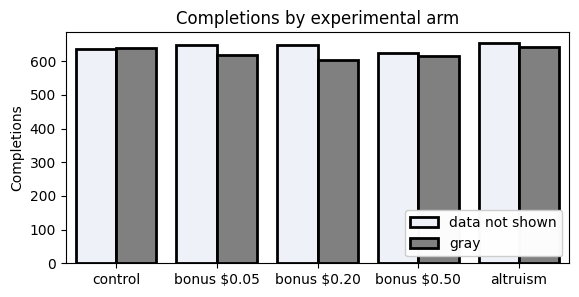

In [20]:
# plot count
fig,ax = plt.subplots(1,1, figsize=(6.5,3))#, dpi=150)
ax.set_title('Completions by experimental arm')
plot_count(agg_share_df, ax)
# chi-square test
(statistic, pvalue) = chisquare(agg_share_df['n'])
print('chi-square test null hypothesis: Completions count is the same across experimental arms')
print('chi-square test result: stat=%0.3f, p-value=%0.3f' % (statistic, pvalue))
if pvalue > 0.05:
    print('We do not reject the null hypothesis')
else:
    print('We reject the null hypothesis')

In [262]:
def plot_share_rate(pdf, ax, overall_share_rate=overall_share_rate):
    width = 0.4
    (pdf[pdf['showdata']==False]['share rate']
     .plot(
         kind='bar', color=showdata_false_color, edgecolor='black',
         linewidth=2,
         label=showdata_false_label,
         ax=ax, width=width,
         position=1
    ))
    (pdf[pdf['showdata']==True]['share rate']
     .plot(
        kind='bar', color=showdata_true_color, 
        edgecolor='black', linewidth=2,
        label=showdata_true_label,
        ax=ax, width=width, position=0)
    )
    if overall_share_rate is not None:
        ax.hlines(overall_share_rate, -1, 5, color='black', label='overall')
    ax.set_ylabel('share rate')
    #ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    ax.set_ylim([0,1])
    _ = ax.set_xticklabels(pdf[pdf['showdata']==True]['incentive'].map(incentive_name_map), rotation=0)

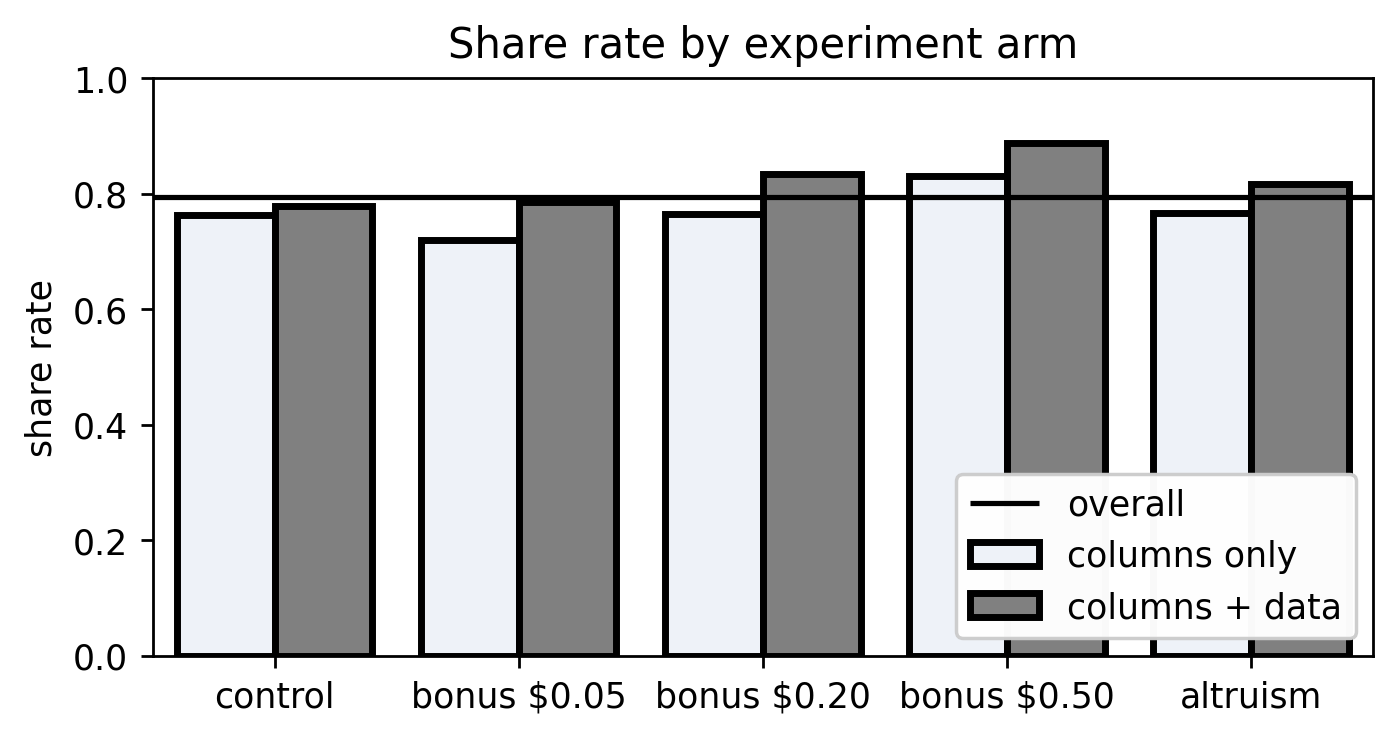

In [261]:
fig,ax = plt.subplots(1,1, figsize=(6.3,3), dpi=250)
ax.set_title('Share rate by experiment arm')
plot_share_rate(agg_share_df, ax)

observations for more analysis below:

- showdata=true consistently higher share rate
- more money reward --> more sharing
- incentive bonus: \$0.05 x (show data=False) has negative effect compared to control
- incentive: altruism x (show data=True) increases sharing vs control

## Helper functions for analysis

In [23]:
# displaying / printing helpers
def get_stars(row):
    if row['p-value'] < 0.001:
        return '***'
    if row['p-value'] < 0.01:
        return '**'
    if row['p-value'] < 0.05:
        return '*'
    return ''

def get_predictors_table(model, p_05_stars=True):
    table = pd.DataFrame({
        'B (log odds)': model.params.apply(round, args=([3])),
        'Odds Ratio': np.exp(model.params).apply(round, args=([3])), 
        '95% CI for Odds Ratio': (
            np.exp(model.conf_int())
            .apply(lambda r: '[%0.3f, %0.3f]'%(r[0], r[1]), axis=1)
        ),
        'p-value': model.pvalues.apply(round, args=([3]))
    }).rename_axis('Predictor')
    if p_05_stars:
        table['B (log odds)'] = table.apply(lambda r: '%s%s' % (r['B (log odds)'], get_stars(r)), axis=1)
    return table

In [24]:
def add_n_labels(ax, values):
    for rect, val in zip(ax.patches, values):
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = 0.02
        ax.annotate(
            'n=%s'%val, 
            (x_value, y_value),
            va='center',
        )
        
def plot_survey_proportion_with_N(df, ax):
    ax.barh(df.index, df['survey proportion'], color='lightgray',  edgecolor='black')
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    add_n_labels(ax, df['survey N'])
    
    
def get_share_rate_by_Q_df(Q, new_col_name=None, df=df):
    share_df = (
        df.groupby([Q])['share']
        .agg(['count','mean']).round(3).reset_index()
        .rename(columns={'count':'n', 'mean':'share rate'})
    )
    if new_col_name:
        share_df = share_df.rename({Q:new_col_name}, axis=1)
    return share_df


def plot_share_by_demo(plt_df, demo_col, ax, control_only=False):
    ax.barh(
        plt_df[demo_col], plt_df['share rate'],
        color='lightgray',  edgecolor='black'
    )
    ax.set_xlim([0,1])
    ax.set_xlabel('Share rate')
    ax.set_ylabel('')
    ax.set_title('Share rate by %s%s' % (demo_col, ' (control only)' if control_only else ''))
    share_rate = control_share_rate if control_only else overall_share_rate
    ax.axvline(share_rate, color='black')
    # annotate with labels
    add_n_labels(ax, plt_df['n'])

### Set up dataframes

model df `mdf`: df with data transformations
- 'Prefer not to say' set to np.nan

```

Education
Collected as:
Prefer not to say
Some high school or less (note small sample)
High school diploma or GED
Bachelor's degree
Graduate or professional degree
Transform to:
nan ← Prefer not to say
High school diploma or GED or less ← collapsed
Bachelor's degree << used as reference in regressions
Graduate or professional degree

Gender
Collected as:
Prefer not to say
Other
Female
Male
Transform to:
nan ← Other or Prefer not to say
Female
Male << used as reference in regressions

Race
Collected as multiple choice among:
White or Caucasian
Asian
Black or African American
American Indian/Native American or Alaska Native
Native Hawaiian or Other Pacific Islander
Other
Transform to:
White << used as reference in regressions
Asian
Black
Other or mixed ← collapsed

Purchase frequency
We use these as they are collected:
Less than 5 times per month
5 - 10 times per month << used as reference in regressions 
More than 10 times per month
```


collapsed model df `mdf` --> `cmdf`: Used for main analyses
- large categories are further collapsed

These are set up to use the demographics in analyses as follows:
```
Age
Collected as:
18 - 24 years
25 - 34 years
35 - 44 years
45 - 54 years
55 - 64 years
65 and older
Transform to:
18 - 34 years
35 - 54 years  << used as reference in regressions (median in span)
55 and older

Household income
Collected as:
Prefer not to say
Less than $25,000
$25,000 - $49,999
$50,000 - $74,999
$75,000 - $99,999
$100,000 - $149,999
$150,000 or more
Transform to:
nan ← Prefer not to say
Less than $50,000
$50,000 - $99,999 << used as reference in regressions (median in this span)
$100,000 or more

```


In [25]:
# build the df used for the model
keep_cols = [
    'q-demos-age', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-education', 
    'Q-demos-income', 'Q-demos-gender', 'Q-sexual-orientation', 
    'Q-demos-state',
    'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 
    'Q-sell-YOUR-data', 'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use','Q-research-society',
    'showdata', 'incentive', 'share',
]
mdf = df[keep_cols]
mdf = (
    mdf.rename({
        'Q-amazon-use-how-oft': 'frequency',
        'Q-sexual-orientation': 'lgbtq',
        'Q-demos-education': 'edu',
        'Q-demos-hispanic': 'hispanic',
        'Q-demos-income': 'income', 
        'Q-demos-gender':'gender',
        'Q-demos-state': 'state',
        'Q-demos-race': 'race',
        'q-demos-age': 'age', 
    }, axis=1)
)

# add data use opinion research q name and keep duplicate name
mdf['for_research'] = mdf['Q-research-society']

# set all 'Prefer not to say' to np.nan to exclude from the model
mdf['income'] = mdf['income'].apply(lambda i: np.nan if i == 'Prefer not to say' else i)
mdf['edu'] = mdf['edu'].apply(lambda e: np.nan if e == 'Prefer not to say' else e)

# restrict analysis to Male/Female binary
mdf['gender'] = mdf['gender'].apply(lambda g: g if g in ['Male','Female'] else np.nan)
mdf.head(3)

,age,hispanic,race,edu,income,gender,lgbtq,state,Q-amazon-use-hh-size,frequency,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,showdata,incentive,share,for_research
0,35 - 44 years,No,Black or African American,High school diploma or GED,"\$25,000 - \$49,999",Female,heterosexual (straight),Iowa,2,Less than 5 times per month,No,No,No,No,No,False,bonus-50,1,No
1,25 - 34 years,No,White or Caucasian,Bachelor's degree,"\$25,000 - \$49,999",Male,heterosexual (straight),Florida,1 (just me!),Less than 5 times per month,Yes if I get part of the profit,Yes,No,Yes,Yes,False,bonus-05,0,Yes
2,45 - 54 years,No,White or Caucasian,High school diploma or GED,"\$100,000 - \$149,999",Male,heterosexual (straight),Ohio,4+,Less than 5 times per month,No,No,No,No,Yes,False,bonus-05,1,Yes


In [26]:
# Make very simplifying use of race:
# Aggregate 'Other' + anyone who answered 2 more more races + anyone with 'Native' (American indians and Pacific Islanders)
# Including 'American Indian' and Pacific islanders in this aggregation because otherwise this group is too small.
mdf['race'] = mdf['race'].apply(lambda r: 'Other or mixed' if ((len(r.split(',')) > 1) or ('Other' in r) or ('Native ' in r)) else r)
# Transform race names to shorter identifiers
mdf['race'] = mdf['race'].map({
    'Black or African American':'Black',
    'White or Caucasian': 'White',
    'Asian': 'Asian',
    'Other or mixed': 'Other or mixed'
})

In [27]:
# Collapse/rename education groups - 'Some high school or less' too small a group in sample
def get_collapsed_edu_group(edu):
    if edu in ['Some high school or less', 'High school diploma or GED']:
        return 'High school or GED or less'
    return edu
mdf['edu'] = mdf['edu'].apply(get_collapsed_edu_group)

#### Set up collapsed groups

In [28]:
cmdf = mdf.copy()

In [29]:
def get_collapsed_age_group(age):
    if age in ['18 - 24 years', '25 - 34 years']:
        return '18 - 34 years'
    if age in ['35 - 44 years', '45 - 54 years']:
        return '35 - 54 years'
    if age in ['55 - 64 years', '65 and older']:
        return '55 and older'
    raise Exception('Unexpected age value: %s' % age)

cmdf['age'] = mdf['age'].apply(get_collapsed_age_group)

In [30]:
# collapse income groups to:
# $100,000 or more
# $50,000 to $99,999
# Less than $50,000
# and make 'Prefer not to say' nan (not to be included in model)

def get_collapsed_income_group(income):
    if (income == 'Less than \\$25,000') or (income == '\\$25,000 - \\$49,999'):
        return 'Less than \\$50,000'
    if (income == '\\$50,000 - \\$74,999') or (income == '\\$75,000 - \\$99,999'):
        return '\\$50,000 - \\$99,999'
    if (income == '\\$100,000 - \\$149,999') or (income == '\\$150,000 or more'):
        return '\\$100,000 or more'
    else:
        return np.nan

cmdf['income'] = mdf['income'].apply(get_collapsed_income_group)

In [31]:
cmdf.head(3)

,age,hispanic,race,edu,income,gender,lgbtq,state,Q-amazon-use-hh-size,frequency,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,showdata,incentive,share,for_research
0,35 - 54 years,No,Black,High school or GED or less,"Less than \$50,000",Female,heterosexual (straight),Iowa,2,Less than 5 times per month,No,No,No,No,No,False,bonus-50,1,No
1,18 - 34 years,No,White,Bachelor's degree,"Less than \$50,000",Male,heterosexual (straight),Florida,1 (just me!),Less than 5 times per month,Yes if I get part of the profit,Yes,No,Yes,Yes,False,bonus-05,0,Yes
2,35 - 54 years,No,White,High school or GED or less,"\$100,000 or more",Male,heterosexual (straight),Ohio,4+,Less than 5 times per month,No,No,No,No,Yes,False,bonus-05,1,Yes


#### Main model


share ~ showdata + incentive + gender + age + income + education + race + frequency

Using collapsed dataframe `cmdf`

In [32]:
formula = "share ~ showdata + C(incentive, Treatment(reference='control'))"
formula += " + C(gender, Treatment(reference='Male'))"
formula += " + C(age, Treatment(reference='35 - 54 years'))"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$99,999'))"
# include interaction effect between income and incentive to test for potential problematic outcome
# formula += " + C(income, Treatment(reference='\$50,000 - \$99,999'))*C(incentive, Treatment(reference='control'))"
formula += " + C(edu)"
formula += " + C(race, Treatment(reference='White'))"
formula += " + C(frequency)" # purchase frequency only adds information with interaction effect
print('formula:')
print(formula)
model = smf.logit(formula=formula, data=cmdf).fit()
display(model.summary2())
display(get_predictors_table(model))

formula:
share ~ showdata + C(incentive, Treatment(reference='control')) + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 54 years')) + C(income, Treatment(reference='\$50,000 - \$99,999')) + C(edu) + C(race, Treatment(reference='White')) + C(frequency)
Optimization terminated successfully.
         Current function value: 0.486488
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Results: Logit
===========================================================================================================================
Model:                                  Logit                               Pseudo R-squared:                    0.028     
Dependent Variable:                     share                               AIC:                                 5868.9895 
Date:                                   2023-06-12 22:26                    BIC:                                 5989.5657 
No. Observations:                       5995                                Log-Likelihood:                      -2916.5   
Df Model:                               17                                  LL-Null:                             -3001.3   
Df Residuals:                           5977                                LLR p-value:                         3.3564e-27
Converged:                              1.0000                              Scale:                               1.0000    
No. Iterations:                         6.0000                                                                             
---------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    0.9989   0.1216  8.2153 0.0000  0.7606  1.2372
showdata[T.True]                                                             0.3737   0.0661  5.6534 0.0000  0.2442  0.5033
C(incentive, Treatment(reference='control'))[T.altruism]                     0.0393   0.1004  0.3915 0.6954 -0.1575  0.2362
C(incentive, Treatment(reference='control'))[T.bonus-05]                    -0.1518   0.0988 -1.5362 0.1245 -0.3455  0.0419
C(incentive, Treatment(reference='control'))[T.bonus-20]                     0.0796   0.1023  0.7778 0.4367 -0.1209  0.2800
C(incentive, Treatment(reference='control'))[T.bonus-50]                     0.5840   0.1121  5.2095 0.0000  0.3643  0.8037
C(gender, Treatment(reference='Male'))[T.Female]                             0.3665   0.0665  5.5080 0.0000  0.2361  0.4970
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]               -0.1761   0.0721 -2.4410 0.0146 -0.3175 -0.0347
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.0624   0.1181 -0.5285 0.5972 -0.2938  0.1690
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.1450   0.0794  1.8256 0.0679 -0.0107  0.3007
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.0461   0.0841  0.5484 0.5834 -0.1188  0.2111
C(edu)[T.Graduate or professional degree]                                    0.1269   0.0935  1.3574 0.1747 -0.0563  0.3102
C(edu)[T.High school or GED or less]                                         0.1598   0.0760  2.1027 0.0355  0.0108  0.3088
C(race, Treatment(reference='White'))[T.Asian]                              -0.5611   0.1073 -5.2294 0.0000 -0.7713 -0.3508
C(race, Treatment(reference='White'))[T.Black]                              -0.0716   0.1319 -0.5427 0.5873 -0.3301  0.1869
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.0208   0.1270  0.1639 0.8698 -0.2281  0.2697
C(frequency)[T.Less than 5 times per month]                                 -0.0345   0.0765 -0.4512 0.6519 -0.1845  0.1154
C(frequency)[T.More than 10 times per month]                                -0.1782   0.1300 -1.3710 0.1704 -0.4330  0.0766
===========================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.999***,2.715,"[2.140, 3.446]",0.000
showdata[T.True],0.374***,1.453,"[1.277, 1.654]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.039,1.040,"[0.854, 1.266]",0.695
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.152,0.859,"[0.708, 1.043]",0.124
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.08,1.083,"[0.886, 1.323]",0.437
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.584***,1.793,"[1.439, 2.234]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.367***,1.443,"[1.266, 1.644]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",-0.176*,0.839,"[0.728, 0.966]",0.015
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.062,0.940,"[0.745, 1.184]",0.597


### Robustness checks 

Test for interaction effect between incentive and income

In [33]:
# As above but include interaction term for incentive x income
formula_robustness_check = formula + " + C(income, Treatment(reference='\$50,000 - \$99,999'))*C(incentive, Treatment(reference='control'))"
print('formula:')
print(formula_robustness_check)
model = smf.logit(formula=formula_robustness_check, data=cmdf).fit()
display(model.summary2())
display(get_predictors_table(model))

formula:
share ~ showdata + C(incentive, Treatment(reference='control')) + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 54 years')) + C(income, Treatment(reference='\$50,000 - \$99,999')) + C(edu) + C(race, Treatment(reference='White')) + C(frequency) + C(income, Treatment(reference='\$50,000 - \$99,999'))*C(incentive, Treatment(reference='control'))
Optimization terminated successfully.
         Current function value: 0.486282
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                   Results: Logit
====================================================================================================================================================================================
Model:                                                     Logit                                                  Pseudo R-squared:                                       0.029     
Dependent Variable:                                        share                                                  AIC:                                                    5882.5171 
Date:                                                      2023-06-12 22:26                                       BIC:                                                    6056.6828 
No. Observations:                                          5995                                                   Log-Likelihood:                                         -2915.3   
Df Model:                                                  25                                                     LL-Null:                                                -3001.3   
Df Residuals:                                              5969                                                   LLR p-value:                                            6.4219e-24
Converged:                                                 1.0000                                                 Scale:                                                  1.0000    
No. Iterations:                                            6.0000                                                                                                                   
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                             0.9996   0.1438  6.9493 0.0000  0.7177  1.2816
showdata[T.True]                                                                                                                      0.3745   0.0662  5.6597 0.0000  0.2448  0.5041
C(incentive, Treatment(reference='control'))[T.altruism]                                                                              0.0922   0.1614  0.5713 0.5678 -0.2241  0.4085
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                                             -0.1860   0.1597 -1.1647 0.2441 -0.4991  0.1270
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                                             -0.0081   0.1633 -0.0495 0.9605 -0.3282  0.3120
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                                              0.6587   0.1798  3.6628 0.0002  0.3062  1.0112
C(gender, Treatment(reference='Male'))[T.Female]                                                                                      0.3669   0.0666  5.5087 0.0000  0.2363  0.4974
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                                                                        -0.1749   0.0722 -2.4218 0.0154 -0.3165 -0.0334
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                                                                         -0.0622   0.1181 -0.5270 0.5982 -0.2938  0.1693
C(income, Treatment(reference='\$50,000 - \$99,999')

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.0***,2.717,"[2.050, 3.602]",0.000
showdata[T.True],0.374***,1.454,"[1.277, 1.656]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.092,1.097,"[0.799, 1.505]",0.568
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.186,0.830,"[0.607, 1.135]",0.244
"C(incentive, Treatment(reference='control'))[T.bonus-20]",-0.008,0.992,"[0.720, 1.366]",0.961
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.659***,1.932,"[1.358, 2.749]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.367***,1.443,"[1.267, 1.644]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",-0.175*,0.840,"[0.729, 0.967]",0.015
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.062,0.940,"[0.745, 1.184]",0.598


Not collapsed: using `mdf`

Using same formula as above


share ~ showdata + incentive + gender + age + income + education + race + frequency

In [34]:
# Same formula as above, with expanded categories for income and age
formula = "share ~ showdata + C(incentive, Treatment(reference='control'))"
formula += " + C(gender, Treatment(reference='Male'))"
formula += " + C(age, Treatment(reference='35 - 44 years'))"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$74,999'))"
# include interaction effect between income and incentive to test for potential problematic outcome
# formula += " + C(income, Treatment(reference='\$50,000 - \$74,999'))*C(incentive, Treatment(reference='control'))"
formula += " + C(edu)"
formula += " + C(race, Treatment(reference='White'))"
formula += " + C(frequency)" # purchase frequency only adds information with interaction effect
print('formula:')
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

formula:
share ~ showdata + C(incentive, Treatment(reference='control')) + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 44 years')) + C(income, Treatment(reference='\$50,000 - \$74,999')) + C(edu) + C(race, Treatment(reference='White')) + C(frequency)
Optimization terminated successfully.
         Current function value: 0.485729
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                        Results: Logit
==============================================================================================================================
Model:                                   Logit                                Pseudo R-squared:                     0.030     
Dependent Variable:                      share                                AIC:                                  5871.8963 
Date:                                    2023-06-12 22:27                     BIC:                                  6032.6647 
No. Observations:                        5995                                 Log-Likelihood:                       -2911.9   
Df Model:                                23                                   LL-Null:                              -3001.3   
Df Residuals:                            5971                                 LLR p-value:                          4.5739e-26
Converged:                               1.0000                               Scale:                                1.0000    
No. Iterations:                          6.0000                                                                               
------------------------------------------------------------------------------------------------------------------------------
                                                                                Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                       1.0035   0.1364  7.3563 0.0000  0.7361  1.2708
showdata[T.True]                                                                0.3758   0.0662  5.6777 0.0000  0.2461  0.5055
C(incentive, Treatment(reference='control'))[T.altruism]                        0.0430   0.1006  0.4270 0.6693 -0.1542  0.2402
C(incentive, Treatment(reference='control'))[T.bonus-05]                       -0.1491   0.0990 -1.5063 0.1320 -0.3432  0.0449
C(incentive, Treatment(reference='control'))[T.bonus-20]                        0.0809   0.1024  0.7904 0.4293 -0.1197  0.2816
C(incentive, Treatment(reference='control'))[T.bonus-50]                        0.5857   0.1122  5.2194 0.0000  0.3657  0.8056
C(gender, Treatment(reference='Male'))[T.Female]                                0.3667   0.0668  5.4869 0.0000  0.2357  0.4977
C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]                  -0.2173   0.1095 -1.9838 0.0473 -0.4320 -0.0026
C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]                  -0.1204   0.0859 -1.4021 0.1609 -0.2888  0.0479
C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]                   0.0879   0.1164  0.7552 0.4501 -0.1402  0.3159
C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]                  -0.0286   0.1416 -0.2020 0.8399 -0.3062  0.2489
C(age, Treatment(reference='35 - 44 years'))[T.65 and older]                   -0.0374   0.2022 -0.1849 0.8533 -0.4338  0.3590
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]    -0.0294   0.1164 -0.2527 0.8005 -0.2576  0.1987
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]  0.0894   0.1097  0.8151 0.4150 -0.1256  0.3044
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]     -0.1373   0.1237 -1.1104 0.2668 -0.3797  0.1051
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]    0.1817   0.1019  1.7822 0.0747 -0.0181  0.3815
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]   -0.1070   0.1062 -1.0076 0.3136 -0.3151  0.1011
C(edu)[T.Graduate or professional degree]                                       0.1319   0.0943  1.3989 0.1618 -0.0529  0.3166
C(edu)[T.High school or GED or less]                                  

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.003***,2.728,"[2.088, 3.564]",0.000
showdata[T.True],0.376***,1.456,"[1.279, 1.658]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.043,1.044,"[0.857, 1.271]",0.669
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.149,0.861,"[0.710, 1.046]",0.132
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.081,1.084,"[0.887, 1.325]",0.429
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.586***,1.796,"[1.442, 2.238]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.367***,1.443,"[1.266, 1.645]",0.000
"C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]",-0.217*,0.805,"[0.649, 0.997]",0.047
"C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]",-0.12,0.887,"[0.749, 1.049]",0.161


### Comparing effects of 5x2 experimental arms

We create a model that considers each combination of `showdata & incentive` treatments as a condition.

It also includes covariates

To do this:
- create a new variable: `exp_arm`: `[incentive]` alone indicates showdata=False; `[incentive]:showdata` indicates showdata=True
    - `control`
    - `control:showdata`
    - `altruism`
    - `altruism:showdata`
    - ...
    - `bonus-50`
    - `bonus-50:showdata`
    
Model uses `control` as reference (i.e. showdata=False)

In [36]:
mdf['exp_arm'] = mdf.apply(lambda r: '%s%s' % (r['incentive'], (':showdata' if r['showdata'] else '')), axis=1)
cmdf['exp_arm'] = cmdf.apply(lambda r: '%s%s' % (r['incentive'], (':showdata' if r['showdata'] else '')), axis=1)
# cmdf.head()

In [37]:
formula = "share ~ C(exp_arm, Treatment(reference='control'))"
formula += " + C(gender, Treatment(reference='Male'))"
formula += " + C(age, Treatment(reference='35 - 54 years'))"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$99,999'))"
formula += " + C(edu) + C(race, Treatment(reference='White'))"
formula += " + C(frequency)" 
print('formula:')
print(formula)
model = smf.logit(formula=formula, data=cmdf).fit()
display(model.summary2())
display(get_predictors_table(model))

formula:
share ~ C(exp_arm, Treatment(reference='control')) + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 54 years')) + C(income, Treatment(reference='\$50,000 - \$99,999')) + C(edu) + C(race, Treatment(reference='White')) + C(frequency)
Optimization terminated successfully.
         Current function value: 0.486167
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Results: Logit
===========================================================================================================================
Model:                                  Logit                               Pseudo R-squared:                    0.029     
Dependent Variable:                     share                               AIC:                                 5873.1469 
Date:                                   2023-06-12 22:28                    BIC:                                 6020.5179 
No. Observations:                       5995                                Log-Likelihood:                      -2914.6   
Df Model:                               21                                  LL-Null:                             -3001.3   
Df Residuals:                           5973                                LLR p-value:                         5.5414e-26
Converged:                              1.0000                              Scale:                               1.0000    
No. Iterations:                         6.0000                                                                             
---------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                    1.0653   0.1353  7.8757 0.0000  0.8002  1.3304
C(exp_arm, Treatment(reference='control'))[T.altruism]                      -0.0097   0.1364 -0.0714 0.9430 -0.2771  0.2576
C(exp_arm, Treatment(reference='control'))[T.altruism:showdata]              0.3179   0.1443  2.2038 0.0275  0.0352  0.6007
C(exp_arm, Treatment(reference='control'))[T.bonus-05]                      -0.2105   0.1340 -1.5715 0.1161 -0.4731  0.0520
C(exp_arm, Treatment(reference='control'))[T.bonus-05:showdata]              0.1390   0.1422  0.9779 0.3281 -0.1396  0.4176
C(exp_arm, Treatment(reference='control'))[T.bonus-20]                      -0.0073   0.1375 -0.0532 0.9576 -0.2769  0.2622
C(exp_arm, Treatment(reference='control'))[T.bonus-20:showdata]              0.4072   0.1494  2.7256 0.0064  0.1144  0.7000
C(exp_arm, Treatment(reference='control'))[T.bonus-50]                       0.3984   0.1481  2.6896 0.0072  0.1081  0.6888
C(exp_arm, Treatment(reference='control'))[T.bonus-50:showdata]              1.0526   0.1701  6.1868 0.0000  0.7192  1.3861
C(exp_arm, Treatment(reference='control'))[T.control:showdata]               0.2231   0.1428  1.5628 0.1181 -0.0567  0.5029
C(gender, Treatment(reference='Male'))[T.Female]                             0.3675   0.0666  5.5221 0.0000  0.2371  0.4979
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]               -0.1747   0.0722 -2.4201 0.0155 -0.3161 -0.0332
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.0637   0.1181 -0.5393 0.5897 -0.2952  0.1678
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.1496   0.0795  1.8823 0.0598 -0.0062  0.3055
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.0484   0.0842  0.5750 0.5653 -0.1166  0.2133
C(edu)[T.Graduate or professional degree]                                    0.1287   0.0935  1.3770 0.1685 -0.0545  0.3120
C(edu)[T.High school or GED or less]                                         0.1622   0.0761  2.1317 0.0330  0.0131  0.3113
C(race, Treatment(reference='White'))[T.Asian]                              -0.5589   0.1073 -5.2067 0.0000 -0.7692 -0.3485
C(race, Treatment(reference='White'))[T.Black]                              -0.0707   0.1319 -0.5362 0.5918 -0.3292  0.1878
C(race, Treatment(reference='White'))[

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.065***,2.902,"[2.226, 3.783]",0.000
"C(exp_arm, Treatment(reference='control'))[T.altruism]",-0.01,0.990,"[0.758, 1.294]",0.943
"C(exp_arm, Treatment(reference='control'))[T.altruism:showdata]",0.318*,1.374,"[1.036, 1.823]",0.028
"C(exp_arm, Treatment(reference='control'))[T.bonus-05]",-0.211,0.810,"[0.623, 1.053]",0.116
"C(exp_arm, Treatment(reference='control'))[T.bonus-05:showdata]",0.139,1.149,"[0.870, 1.518]",0.328
"C(exp_arm, Treatment(reference='control'))[T.bonus-20]",-0.007,0.993,"[0.758, 1.300]",0.958
"C(exp_arm, Treatment(reference='control'))[T.bonus-20:showdata]",0.407**,1.503,"[1.121, 2.014]",0.006
"C(exp_arm, Treatment(reference='control'))[T.bonus-50]",0.398**,1.490,"[1.114, 1.991]",0.007
"C(exp_arm, Treatment(reference='control'))[T.bonus-50:showdata]",1.053***,2.865,"[2.053, 3.999]",0.000


## Questions about data use
At the end of the survey we ask:

- Do you think Amazon should be able to sell YOUR purchase data to other companies?
- Do you think companies should be able to sell consumer purchase data to other companies?
- Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?
- Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?
- Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?

The order of these questions is randomized.

In [287]:
data_use_Qs = [
    'Q-sell-YOUR-data', 'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use', 'Q-research-society'
]

Overall what were the answers to these questions?



In [288]:
# order the responses as

data_use_resp_1 = ['No','Yes','Yes if I get part of the profit', "I don't know"]
data_use_resp_2 = ['No','Yes','Yes if consumers get part of the profit', "I don't know"]
data_use_resp_3 = ['No','Yes', "I don't know"]
data_use_resp_4 = data_use_resp_3
data_use_resp_5 = data_use_resp_3
data_use_resp = [data_use_resp_1, data_use_resp_2, data_use_resp_3, data_use_resp_4, data_use_resp_5]

N=6325

Q1: Q-sell-YOUR-data: Do you think Amazon should be able to sell YOUR purchase data to other companies?


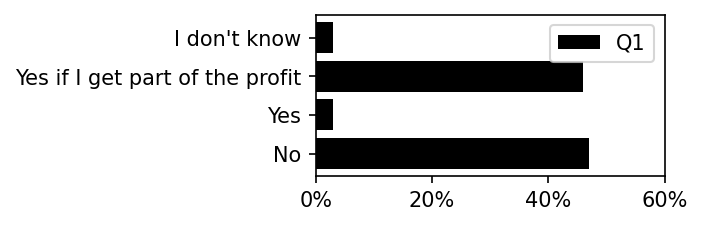

,n,pct
Q-sell-YOUR-data,,
No,2988,0.47
Yes,219,0.03
Yes if I get part of the profit,2936,0.46
I don't know,182,0.03


Q2: Q-sell-consumer-data: Do you think companies should be able to sell consumer purchase data to other companies?


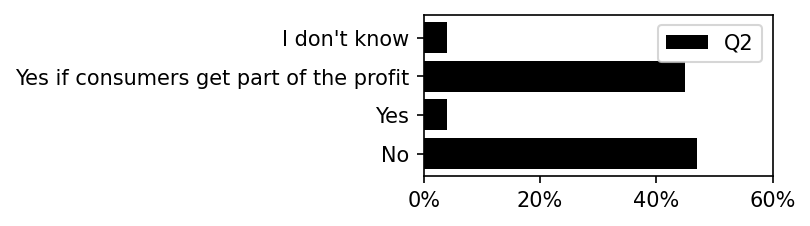

,n,pct
Q-sell-consumer-data,,
No,2962,0.47
Yes,253,0.04
Yes if consumers get part of the profit,2857,0.45
I don't know,253,0.04


Q3: Q-small-biz-use: Big companies currently collect and sell consumer purchase data.
Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?


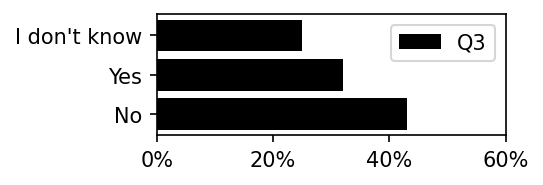

,n,pct
Q-small-biz-use,,
No,2710,0.43
Yes,2046,0.32
I don't know,1569,0.25


Q4: Q-census-use: Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?


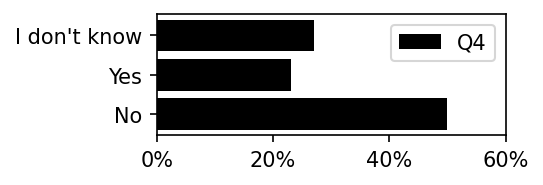

,n,pct
Q-census-use,,
No,3147,0.50
Yes,1465,0.23
I don't know,1713,0.27


Q5: Q-research-society: Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?


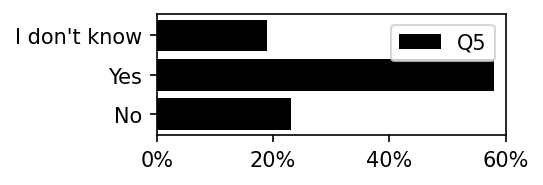

,n,pct
Q-research-society,,
No,1456,0.23
Yes,3697,0.58
I don't know,1172,0.19


In [291]:
import matplotlib.ticker as mtick

print('N=%s\n' % N)
for i, Q in enumerate(data_use_Qs):
    answers_df = (df[Q].value_counts().sort_index(ascending=False)
              .to_frame(name='n')
              .assign(pct=lambda x: round(x['n']/N, 2)))
    assert(N==answers_df['n'].sum())
    # apply the desired order of responses
    responses = data_use_resp[i]
    answers_df = answers_df.loc[responses]
    fig, ax = plt.subplots(1,1, figsize=(3,0.35*len(responses)), dpi=150)
    q = fields_df.loc[Q][0].replace('. D', '.\nD')
    Q_num = 'Q%s' % (i+1)
    ax.set_xlim([0,0.6])
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
    ax.barh(answers_df.index, answers_df['pct'], color='black', label=Q_num)
    ax.legend()
    print('%s: %s: %s' % (Q_num, Q, q))
    plt.show()
    display(answers_df)

### Relationship between demographics & other covariates and data use opinions

##### Method
Logistic regression


opinion: 
[yes|yes if profit]=1 vs no=0 (exclude “I don’t know”)

Regress on opinion boolean incorporating demographic attributes in model

Formula:
```
opinion ~ share + gender + age + income + education + race + purchase_frequency
```
Reasons we include share
- Data use questions came after decision to share
- This way the covariates add additional information vs just correlating with share behaviors

opinion=
- 1:”yes|yes if get profit”
- 0:”no” 
- ("I don't know" left out)


In [292]:
formula = "opinion ~"
formula += "share"
formula += " + C(gender, Treatment(reference='Male'))"
formula += " + C(age, Treatment(reference='35 - 54 years'))"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$99,999'))"
formula += " + C(edu) + C(race, Treatment(reference='White'))"
formula += " + C(frequency)"
print('formula:\n%s\n--------------------------------------' % formula)

formula:
opinion ~share + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 54 years')) + C(income, Treatment(reference='\$50,000 - \$99,999')) + C(edu) + C(race, Treatment(reference='White')) + C(frequency)
--------------------------------------


In [293]:
for i, Q in enumerate(data_use_Qs):
    print('Q: %s: %s' % (Q, fields_df.loc[Q][0]))
    cmdf['opinion'] = cmdf[Q].apply(lambda o: 1 if 'Yes' in o else (0 if o=='No' else np.nan))
    model = smf.logit(formula=formula, data=cmdf).fit()
    display(model.summary2())
    display(get_predictors_table(model))

Q: Q-sell-YOUR-data: Do you think Amazon should be able to sell YOUR purchase data to other companies?
Optimization terminated successfully.
         Current function value: 0.648470
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Logit
============================================================================================================================
Model:                                  Logit                               Pseudo R-squared:                    0.064      
Dependent Variable:                     opinion                             AIC:                                 7576.1895  
Date:                                   2023-06-13 17:09                    BIC:                                 7669.5563  
No. Observations:                       5820                                Log-Likelihood:                      -3774.1    
Df Model:                               13                                  LL-Null:                             -4030.4    
Df Residuals:                           5806                                LLR p-value:                         3.0678e-101
Converged:                              1.0000                              Scale:                               1.0000     
No. Iterations:                         5.0000                                                                              
----------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -0.7646   0.1008  -7.5885 0.0000 -0.9621 -0.5671
C(gender, Treatment(reference='Male'))[T.Female]                            -0.6469   0.0560 -11.5561 0.0000 -0.7567 -0.5372
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.4246   0.0598   7.1008 0.0000  0.3074  0.5418
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.5487   0.0976  -5.6248 0.0000 -0.7400 -0.3575
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.1109   0.0661   1.6778 0.0934 -0.0186  0.2404
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.0141   0.0713   0.1974 0.8435 -0.1257  0.1539
C(edu)[T.Graduate or professional degree]                                    0.1038   0.0779   1.3332 0.1825 -0.0488  0.2565
C(edu)[T.High school or GED or less]                                         0.1841   0.0632   2.9137 0.0036  0.0603  0.3079
C(race, Treatment(reference='White'))[T.Asian]                               0.1631   0.1023   1.5945 0.1108 -0.0374  0.3635
C(race, Treatment(reference='White'))[T.Black]                               0.1718   0.1086   1.5822 0.1136 -0.0410  0.3846
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.2023   0.1058   1.9116 0.0559 -0.0051  0.4096
C(frequency)[T.Less than 5 times per month]                                 -0.0941   0.0634  -1.4836 0.1379 -0.2185  0.0302
C(frequency)[T.More than 10 times per month]                                 0.0527   0.1100   0.4791 0.6319 -0.1629  0.2682
share                                                                        1.1078   0.0717  15.4408 0.0000  0.9672  1.2484
============================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-0.765***,0.466,"[0.382, 0.567]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",-0.647***,0.524,"[0.469, 0.584]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.425***,1.529,"[1.360, 1.719]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.549***,0.578,"[0.477, 0.699]",0.000
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",0.111,1.117,"[0.982, 1.272]",0.093
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.014,1.014,"[0.882, 1.166]",0.843
C(edu)[T.Graduate or professional degree],0.104,1.109,"[0.952, 1.292]",0.182
C(edu)[T.High school or GED or less],0.184**,1.202,"[1.062, 1.361]",0.004
"C(race, Treatment(reference='White'))[T.Asian]",0.163,1.177,"[0.963, 1.438]",0.111


Q: Q-sell-consumer-data: Do you think companies should be able to sell consumer purchase data to other companies?
Optimization terminated successfully.
         Current function value: 0.651018
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Logit
============================================================================================================================
Model:                                   Logit                               Pseudo R-squared:                    0.060     
Dependent Variable:                      opinion                             AIC:                                 7514.7027 
Date:                                    2023-06-13 17:09                    BIC:                                 7607.9001 
No. Observations:                        5750                                Log-Likelihood:                      -3743.4   
Df Model:                                13                                  LL-Null:                             -3982.1   
Df Residuals:                            5736                                LLR p-value:                         8.6092e-94
Converged:                               1.0000                              Scale:                               1.0000    
No. Iterations:                          5.0000                                                                             
----------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -0.7395   0.1007  -7.3440 0.0000 -0.9368 -0.5421
C(gender, Treatment(reference='Male'))[T.Female]                            -0.6498   0.0561 -11.5811 0.0000 -0.7597 -0.5398
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.3580   0.0599   5.9747 0.0000  0.2406  0.4755
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.5474   0.0980  -5.5877 0.0000 -0.7394 -0.3554
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.0731   0.0662   1.1044 0.2694 -0.0566  0.2028
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.0902   0.0718   1.2563 0.2090 -0.0505  0.2310
C(edu)[T.Graduate or professional degree]                                    0.0762   0.0781   0.9748 0.3297 -0.0770  0.2293
C(edu)[T.High school or GED or less]                                         0.2043   0.0634   3.2220 0.0013  0.0800  0.3286
C(race, Treatment(reference='White'))[T.Asian]                               0.1438   0.1027   1.4003 0.1614 -0.0575  0.3450
C(race, Treatment(reference='White'))[T.Black]                               0.4823   0.1116   4.3226 0.0000  0.2636  0.7010
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.2069   0.1050   1.9701 0.0488  0.0011  0.4127
C(frequency)[T.Less than 5 times per month]                                 -0.0281   0.0635  -0.4422 0.6583 -0.1525  0.0964
C(frequency)[T.More than 10 times per month]                                 0.0802   0.1102   0.7279 0.4667 -0.1357  0.2961
share                                                                        1.0280   0.0713  14.4118 0.0000  0.8882  1.1678
============================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-0.739***,0.477,"[0.392, 0.582]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",-0.65***,0.522,"[0.468, 0.583]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.358***,1.431,"[1.272, 1.609]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.547***,0.578,"[0.477, 0.701]",0.000
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",0.073,1.076,"[0.945, 1.225]",0.269
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.09,1.094,"[0.951, 1.260]",0.209
C(edu)[T.Graduate or professional degree],0.076,1.079,"[0.926, 1.258]",0.330
C(edu)[T.High school or GED or less],0.204**,1.227,"[1.083, 1.389]",0.001
"C(race, Treatment(reference='White'))[T.Asian]",0.144,1.155,"[0.944, 1.412]",0.161


Q: Q-small-biz-use: Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?
Optimization terminated successfully.
         Current function value: 0.652254
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Logit
============================================================================================================================
Model:                                   Logit                               Pseudo R-squared:                    0.047     
Dependent Variable:                      opinion                             AIC:                                 5930.9030 
Date:                                    2023-06-13 17:09                    BIC:                                 6020.7462 
No. Observations:                        4525                                Log-Likelihood:                      -2951.5   
Df Model:                                13                                  LL-Null:                             -3097.8   
Df Residuals:                            4511                                LLR p-value:                         8.2124e-55
Converged:                               1.0000                              Scale:                               1.0000    
No. Iterations:                          5.0000                                                                             
----------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -1.3326   0.1177 -11.3197 0.0000 -1.5634 -1.1019
C(gender, Treatment(reference='Male'))[T.Female]                             0.1327   0.0627   2.1155 0.0344  0.0098  0.2557
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.2586   0.0676   3.8237 0.0001  0.1260  0.3911
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.1348   0.1089  -1.2377 0.2158 -0.3481  0.0786
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000] -0.0466   0.0746  -0.6250 0.5320 -0.1927  0.0995
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]  -0.1571   0.0809  -1.9426 0.0521 -0.3156  0.0014
C(edu)[T.Graduate or professional degree]                                   -0.0483   0.0894  -0.5402 0.5890 -0.2234  0.1269
C(edu)[T.High school or GED or less]                                         0.1492   0.0711   2.0988 0.0358  0.0099  0.2885
C(race, Treatment(reference='White'))[T.Asian]                               0.0480   0.1163   0.4129 0.6797 -0.1799  0.2759
C(race, Treatment(reference='White'))[T.Black]                              -0.0282   0.1228  -0.2296 0.8184 -0.2688  0.2125
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.1419   0.1165   1.2186 0.2230 -0.0863  0.3702
C(frequency)[T.Less than 5 times per month]                                 -0.2009   0.0712  -2.8213 0.0048 -0.3404 -0.0613
C(frequency)[T.More than 10 times per month]                                 0.0081   0.1217   0.0663 0.9472 -0.2304  0.2465
share                                                                        1.2388   0.0867  14.2942 0.0000  1.0689  1.4086
============================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-1.333***,0.264,"[0.209, 0.332]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.133*,1.142,"[1.010, 1.291]",0.034
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.259***,1.295,"[1.134, 1.479]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.135,0.874,"[0.706, 1.082]",0.216
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",-0.047,0.954,"[0.825, 1.105]",0.532
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",-0.157,0.855,"[0.729, 1.001]",0.052
C(edu)[T.Graduate or professional degree],-0.048,0.953,"[0.800, 1.135]",0.589
C(edu)[T.High school or GED or less],0.149*,1.161,"[1.010, 1.334]",0.036
"C(race, Treatment(reference='White'))[T.Asian]",0.048,1.049,"[0.835, 1.318]",0.680


Q: Q-census-use: Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?
Optimization terminated successfully.
         Current function value: 0.591337
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Logit
============================================================================================================================
Model:                                   Logit                               Pseudo R-squared:                    0.059     
Dependent Variable:                      opinion                             AIC:                                 5219.9349 
Date:                                    2023-06-13 17:09                    BIC:                                 5309.3541 
No. Observations:                        4390                                Log-Likelihood:                      -2596.0   
Df Model:                                13                                  LL-Null:                             -2758.8   
Df Residuals:                            4376                                LLR p-value:                         9.6168e-62
Converged:                               1.0000                              Scale:                               1.0000    
No. Iterations:                          6.0000                                                                             
----------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -1.7679   0.1290 -13.7099 0.0000 -2.0207 -1.5152
C(gender, Treatment(reference='Male'))[T.Female]                            -0.5592   0.0687  -8.1388 0.0000 -0.6939 -0.4245
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.5491   0.0732   7.4971 0.0000  0.4056  0.6927
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.3333   0.1260  -2.6458 0.0081 -0.5803 -0.0864
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000] -0.0006   0.0818  -0.0078 0.9937 -0.1610  0.1598
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.2091   0.0858   2.4385 0.0147  0.0410  0.3772
C(edu)[T.Graduate or professional degree]                                    0.2488   0.0938   2.6524 0.0080  0.0649  0.4326
C(edu)[T.High school or GED or less]                                        -0.0010   0.0780  -0.0132 0.9895 -0.1540  0.1519
C(race, Treatment(reference='White'))[T.Asian]                               0.5234   0.1178   4.4431 0.0000  0.2925  0.7543
C(race, Treatment(reference='White'))[T.Black]                               0.2736   0.1296   2.1107 0.0348  0.0195  0.5277
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.0711   0.1277   0.5572 0.5774 -0.1791  0.3214
C(frequency)[T.Less than 5 times per month]                                 -0.0172   0.0776  -0.2216 0.8246 -0.1693  0.1349
C(frequency)[T.More than 10 times per month]                                 0.1744   0.1305   1.3366 0.1814 -0.0813  0.4300
share                                                                        1.0413   0.0944  11.0286 0.0000  0.8563  1.2264
============================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-1.768***,0.171,"[0.133, 0.220]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",-0.559***,0.572,"[0.500, 0.654]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.549***,1.732,"[1.500, 1.999]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.333**,0.717,"[0.560, 0.917]",0.008
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",-0.001,0.999,"[0.851, 1.173]",0.994
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.209*,1.233,"[1.042, 1.458]",0.015
C(edu)[T.Graduate or professional degree],0.249**,1.282,"[1.067, 1.541]",0.008
C(edu)[T.High school or GED or less],-0.001,0.999,"[0.857, 1.164]",0.989
"C(race, Treatment(reference='White'))[T.Asian]",0.523***,1.688,"[1.340, 2.126]",0.000


Q: Q-research-society: Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?
Optimization terminated successfully.
         Current function value: 0.560671
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Results: Logit
===========================================================================================================================
Model:                                  Logit                               Pseudo R-squared:                    0.059     
Dependent Variable:                     opinion                             AIC:                                 5533.7890 
Date:                                   2023-06-13 17:09                    BIC:                                 5624.7754 
No. Observations:                       4910                                Log-Likelihood:                      -2752.9   
Df Model:                               13                                  LL-Null:                             -2924.7   
Df Residuals:                           4896                                LLR p-value:                         1.6941e-65
Converged:                              1.0000                              Scale:                               1.0000    
No. Iterations:                         5.0000                                                                             
---------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -0.3152   0.1147 -2.7490 0.0060 -0.5400 -0.0905
C(gender, Treatment(reference='Male'))[T.Female]                            -0.0598   0.0670 -0.8919 0.3725 -0.1911  0.0716
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.2908   0.0722  4.0273 0.0001  0.1493  0.4324
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.2524   0.1093 -2.3090 0.0209 -0.4667 -0.0382
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.1220   0.0792  1.5410 0.1233 -0.0332  0.2771
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.1684   0.0863  1.9506 0.0511 -0.0008  0.3376
C(edu)[T.Graduate or professional degree]                                    0.2963   0.0977  3.0337 0.0024  0.1049  0.4876
C(edu)[T.High school or GED or less]                                        -0.0849   0.0751 -1.1312 0.2580 -0.2321  0.0622
C(race, Treatment(reference='White'))[T.Asian]                               0.2278   0.1282  1.7772 0.0755 -0.0234  0.4791
C(race, Treatment(reference='White'))[T.Black]                              -0.1593   0.1266 -1.2584 0.2082 -0.4075  0.0888
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.0047   0.1259  0.0369 0.9705 -0.2421  0.2514
C(frequency)[T.Less than 5 times per month]                                  0.0042   0.0759  0.0555 0.9557 -0.1445  0.1529
C(frequency)[T.More than 10 times per month]                                -0.0230   0.1296 -0.1776 0.8590 -0.2771  0.2311
share                                                                        1.3426   0.0779 17.2346 0.0000  1.1899  1.4953
===========================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-0.315**,0.730,"[0.583, 0.913]",0.006
"C(gender, Treatment(reference='Male'))[T.Female]",-0.06,0.942,"[0.826, 1.074]",0.372
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.291***,1.338,"[1.161, 1.541]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.252*,0.777,"[0.627, 0.963]",0.021
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",0.122,1.130,"[0.967, 1.319]",0.123
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.168,1.183,"[0.999, 1.402]",0.051
C(edu)[T.Graduate or professional degree],0.296**,1.345,"[1.111, 1.628]",0.002
C(edu)[T.High school or GED or less],-0.085,0.919,"[0.793, 1.064]",0.258
"C(race, Treatment(reference='White'))[T.Asian]",0.228,1.256,"[0.977, 1.615]",0.076


#### Robustness check B:
Note that the data opinion questions come after participants are asked to share and presented with their experimental treatments

Question: are answers to the data use opinion questions influenced by the incentive participants are presented? Or an interaction between this treatment and their sharing behavior?
e.g. if a participant was presented with the ‘altruism’ incentive and then opted to share, they may be more likely to answer ‘Yes’ to the question about whether researchers should be able to use consumer data.

Method:
Run same regressions as above, including another set of terms:

formula += share + incentive + share x incentive 



In [295]:
formula_r = formula + " + share*C(incentive, Treatment(reference='control'))"
print('formula:\n%s\n--------------------------------------' % formula_r)

formula:
opinion ~share + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 54 years')) + C(income, Treatment(reference='\$50,000 - \$99,999')) + C(edu) + C(race, Treatment(reference='White')) + C(frequency) + share*C(incentive, Treatment(reference='control'))
--------------------------------------


In [296]:
for i, Q in enumerate(data_use_Qs):
    print('Q: %s: %s' % (Q, fields_df.loc[Q][0]))
    cmdf['opinion'] = cmdf[Q].apply(lambda o: 1 if 'Yes' in o else (0 if o=='No' else np.nan))
    model = smf.logit(formula=formula_r, data=cmdf).fit()
    display(model.summary2())
    display(get_predictors_table(model))

Q: Q-sell-YOUR-data: Do you think Amazon should be able to sell YOUR purchase data to other companies?
Optimization terminated successfully.
         Current function value: 0.647074
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Logit
============================================================================================================================
Model:                                   Logit                               Pseudo R-squared:                    0.066     
Dependent Variable:                      opinion                             AIC:                                 7575.9412 
Date:                                    2023-06-13 17:34                    BIC:                                 7722.6604 
No. Observations:                        5820                                Log-Likelihood:                      -3766.0   
Df Model:                                21                                  LL-Null:                             -4030.4   
Df Residuals:                            5798                                LLR p-value:                         1.3603e-98
Converged:                               1.0000                              Scale:                               1.0000    
No. Iterations:                          5.0000                                                                             
----------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -0.7966   0.1585  -5.0269 0.0000 -1.1071 -0.4860
C(gender, Treatment(reference='Male'))[T.Female]                            -0.6466   0.0561 -11.5333 0.0000 -0.7565 -0.5367
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.4270   0.0599   7.1276 0.0000  0.3096  0.5444
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.5539   0.0977  -5.6680 0.0000 -0.7454 -0.3623
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.1147   0.0662   1.7332 0.0831 -0.0150  0.2445
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.0202   0.0715   0.2829 0.7773 -0.1200  0.1604
C(edu)[T.Graduate or professional degree]                                    0.1029   0.0781   1.3179 0.1875 -0.0501  0.2559
C(edu)[T.High school or GED or less]                                         0.1797   0.0633   2.8387 0.0045  0.0556  0.3037
C(race, Treatment(reference='White'))[T.Asian]                               0.1645   0.1026   1.6028 0.1090 -0.0367  0.3657
C(race, Treatment(reference='White'))[T.Black]                               0.1727   0.1087   1.5890 0.1121 -0.0403  0.3856
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.1960   0.1060   1.8485 0.0645 -0.0118  0.4039
C(frequency)[T.Less than 5 times per month]                                 -0.0923   0.0636  -1.4502 0.1470 -0.2169  0.0324
C(frequency)[T.More than 10 times per month]                                 0.0482   0.1101   0.4373 0.6619 -0.1677  0.2640
C(incentive, Treatment(reference='control'))[T.altruism]                     0.2355   0.1917   1.2286 0.2192 -0.1402  0.6113
C(incentive, Treatment(reference='control'))[T.bonus-05]                    -0.1377   0.1929  -0.7139 0.4753 -0.5159  0.2404
C(incentive, Treatment(reference='control'))[T.bonus-20]                     0.1920   0.1963   0.9783 0.3279 -0.1927  0.5767
C(incentive, Treatment(reference='control'))[T.bonus-50]                    -0.2493   0.2300  -1.0841 0.2783 -0.7000  0.2014
share                                                                        1.0780   0.1547   6.9661 0.0000  0.7747  1.3813
share:C(incentive, Treatment(reference='control'))[T.altruism]              -0.2268   0.2145  -1.0575 0.2903 -0.6472  0.1936
share:

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-0.797***,0.451,"[0.330, 0.615]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",-0.647***,0.524,"[0.469, 0.585]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.427***,1.533,"[1.363, 1.724]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.554***,0.575,"[0.475, 0.696]",0.000
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",0.115,1.122,"[0.985, 1.277]",0.083
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.02,1.020,"[0.887, 1.174]",0.777
C(edu)[T.Graduate or professional degree],0.103,1.108,"[0.951, 1.292]",0.188
C(edu)[T.High school or GED or less],0.18**,1.197,"[1.057, 1.355]",0.005
"C(race, Treatment(reference='White'))[T.Asian]",0.164,1.179,"[0.964, 1.441]",0.109


Q: Q-sell-consumer-data: Do you think companies should be able to sell consumer purchase data to other companies?
Optimization terminated successfully.
         Current function value: 0.650204
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Logit
============================================================================================================================
Model:                                   Logit                               Pseudo R-squared:                    0.061     
Dependent Variable:                      opinion                             AIC:                                 7521.3508 
Date:                                    2023-06-13 17:34                    BIC:                                 7667.8038 
No. Observations:                        5750                                Log-Likelihood:                      -3738.7   
Df Model:                                21                                  LL-Null:                             -3982.1   
Df Residuals:                            5728                                LLR p-value:                         8.0937e-90
Converged:                               1.0000                              Scale:                               1.0000    
No. Iterations:                          5.0000                                                                             
----------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -0.6750   0.1573  -4.2913 0.0000 -0.9833 -0.3667
C(gender, Treatment(reference='Male'))[T.Female]                            -0.6502   0.0562 -11.5776 0.0000 -0.7603 -0.5402
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.3587   0.0600   5.9793 0.0000  0.2411  0.4763
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.5516   0.0981  -5.6247 0.0000 -0.7438 -0.3594
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.0763   0.0663   1.1515 0.2495 -0.0536  0.2062
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.0963   0.0720   1.3383 0.1808 -0.0447  0.2374
C(edu)[T.Graduate or professional degree]                                    0.0749   0.0783   0.9561 0.3390 -0.0786  0.2283
C(edu)[T.High school or GED or less]                                         0.2025   0.0635   3.1882 0.0014  0.0780  0.3270
C(race, Treatment(reference='White'))[T.Asian]                               0.1445   0.1029   1.4043 0.1602 -0.0572  0.3463
C(race, Treatment(reference='White'))[T.Black]                               0.4836   0.1117   4.3316 0.0000  0.2648  0.7025
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.2024   0.1052   1.9233 0.0544 -0.0039  0.4086
C(frequency)[T.Less than 5 times per month]                                 -0.0249   0.0636  -0.3915 0.6955 -0.1496  0.0998
C(frequency)[T.More than 10 times per month]                                 0.0786   0.1103   0.7123 0.4763 -0.1376  0.2948
C(incentive, Treatment(reference='control'))[T.altruism]                     0.0706   0.1910   0.3696 0.7117 -0.3037  0.4449
C(incentive, Treatment(reference='control'))[T.bonus-05]                    -0.1862   0.1900  -0.9804 0.3269 -0.5585  0.1861
C(incentive, Treatment(reference='control'))[T.bonus-20]                    -0.0066   0.1956  -0.0337 0.9731 -0.3900  0.3768
C(incentive, Treatment(reference='control'))[T.bonus-50]                    -0.3014   0.2262  -1.3325 0.1827 -0.7448  0.1419
share                                                                        0.9279   0.1536   6.0399 0.0000  0.6268  1.2290
share:C(incentive, Treatment(reference='control'))[T.altruism]              -0.0569   0.2142  -0.2657 0.7905 -0.4767  0.3629
share:

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-0.675***,0.509,"[0.374, 0.693]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",-0.65***,0.522,"[0.468, 0.583]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.359***,1.431,"[1.273, 1.610]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.552***,0.576,"[0.475, 0.698]",0.000
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",0.076,1.079,"[0.948, 1.229]",0.250
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.096,1.101,"[0.956, 1.268]",0.181
C(edu)[T.Graduate or professional degree],0.075,1.078,"[0.924, 1.256]",0.339
C(edu)[T.High school or GED or less],0.203**,1.224,"[1.081, 1.387]",0.001
"C(race, Treatment(reference='White'))[T.Asian]",0.145,1.156,"[0.944, 1.414]",0.160


Q: Q-small-biz-use: Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?
Optimization terminated successfully.
         Current function value: 0.649079
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Results: Logit
===========================================================================================================================
Model:                                  Logit                               Pseudo R-squared:                    0.052     
Dependent Variable:                     opinion                             AIC:                                 5918.1687 
Date:                                   2023-06-13 17:34                    BIC:                                 6059.3509 
No. Observations:                       4525                                Log-Likelihood:                      -2937.1   
Df Model:                               21                                  LL-Null:                             -3097.8   
Df Residuals:                           4503                                LLR p-value:                         1.3719e-55
Converged:                              1.0000                              Scale:                               1.0000    
No. Iterations:                         6.0000                                                                             
---------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -1.4217   0.1952 -7.2847 0.0000 -1.8042 -1.0392
C(gender, Treatment(reference='Male'))[T.Female]                             0.1327   0.0630  2.1077 0.0351  0.0093  0.2561
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.2577   0.0679  3.7980 0.0001  0.1247  0.3907
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.1339   0.1092 -1.2258 0.2203 -0.3479  0.0802
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000] -0.0420   0.0748 -0.5614 0.5745 -0.1887  0.1047
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]  -0.1498   0.0812 -1.8441 0.0652 -0.3089  0.0094
C(edu)[T.Graduate or professional degree]                                   -0.0600   0.0898 -0.6679 0.5042 -0.2359  0.1160
C(edu)[T.High school or GED or less]                                         0.1555   0.0714  2.1788 0.0293  0.0156  0.2954
C(race, Treatment(reference='White'))[T.Asian]                               0.0491   0.1168  0.4199 0.6746 -0.1800  0.2781
C(race, Treatment(reference='White'))[T.Black]                              -0.0101   0.1233 -0.0821 0.9345 -0.2517  0.2315
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.1387   0.1169  1.1863 0.2355 -0.0905  0.3679
C(frequency)[T.Less than 5 times per month]                                 -0.2123   0.0716 -2.9672 0.0030 -0.3525 -0.0721
C(frequency)[T.More than 10 times per month]                                -0.0054   0.1223 -0.0445 0.9645 -0.2451  0.2342
C(incentive, Treatment(reference='control'))[T.altruism]                     0.2741   0.2394  1.1451 0.2522 -0.1951  0.7433
C(incentive, Treatment(reference='control'))[T.bonus-05]                     0.0909   0.2379  0.3821 0.7024 -0.3754  0.5573
C(incentive, Treatment(reference='control'))[T.bonus-20]                     0.2041   0.2438  0.8372 0.4025 -0.2737  0.6819
C(incentive, Treatment(reference='control'))[T.bonus-50]                    -0.3115   0.3111 -1.0012 0.3167 -0.9212  0.2983
share                                                                        1.3881   0.1901  7.3005 0.0000  1.0155  1.7608
share:C(incentive, Treatment(reference='control'))[T.altruism]              -0.0540   0.2623 -0.2058 0.8369 -0.5680  0.4601
share:C(incentive, Treatment(reference

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-1.422***,0.241,"[0.165, 0.354]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.133*,1.142,"[1.009, 1.292]",0.035
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.258***,1.294,"[1.133, 1.478]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.134,0.875,"[0.706, 1.083]",0.220
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",-0.042,0.959,"[0.828, 1.110]",0.575
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",-0.15,0.861,"[0.734, 1.009]",0.065
C(edu)[T.Graduate or professional degree],-0.06,0.942,"[0.790, 1.123]",0.504
C(edu)[T.High school or GED or less],0.156*,1.168,"[1.016, 1.344]",0.029
"C(race, Treatment(reference='White'))[T.Asian]",0.049,1.050,"[0.835, 1.321]",0.675


Q: Q-census-use: Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?
Optimization terminated successfully.
         Current function value: 0.590848
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Results: Logit
===========================================================================================================================
Model:                                  Logit                               Pseudo R-squared:                    0.060     
Dependent Variable:                     opinion                             AIC:                                 5231.6428 
Date:                                   2023-06-13 17:34                    BIC:                                 5372.1587 
No. Observations:                       4390                                Log-Likelihood:                      -2593.8   
Df Model:                               21                                  LL-Null:                             -2758.8   
Df Residuals:                           4368                                LLR p-value:                         2.3341e-57
Converged:                              1.0000                              Scale:                               1.0000    
No. Iterations:                         6.0000                                                                             
---------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -1.7674   0.2091 -8.4545 0.0000 -2.1772 -1.3577
C(gender, Treatment(reference='Male'))[T.Female]                            -0.5603   0.0688 -8.1484 0.0000 -0.6950 -0.4255
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.5491   0.0733  7.4909 0.0000  0.4054  0.6928
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.3313   0.1261 -2.6279 0.0086 -0.5784 -0.0842
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000] -0.0008   0.0819 -0.0099 0.9921 -0.1613  0.1597
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.2101   0.0859  2.4450 0.0145  0.0417  0.3785
C(edu)[T.Graduate or professional degree]                                    0.2452   0.0940  2.6101 0.0091  0.0611  0.4294
C(edu)[T.High school or GED or less]                                        -0.0029   0.0781 -0.0373 0.9702 -0.1560  0.1502
C(race, Treatment(reference='White'))[T.Asian]                               0.5181   0.1180  4.3904 0.0000  0.2868  0.7493
C(race, Treatment(reference='White'))[T.Black]                               0.2702   0.1298  2.0822 0.0373  0.0159  0.5246
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.0735   0.1279  0.5748 0.5654 -0.1771  0.3241
C(frequency)[T.Less than 5 times per month]                                 -0.0191   0.0777 -0.2462 0.8055 -0.1715  0.1332
C(frequency)[T.More than 10 times per month]                                 0.1686   0.1305  1.2919 0.1964 -0.0872  0.4245
C(incentive, Treatment(reference='control'))[T.altruism]                     0.0052   0.2617  0.0201 0.9840 -0.5077  0.5182
C(incentive, Treatment(reference='control'))[T.bonus-05]                    -0.1755   0.2625 -0.6683 0.5039 -0.6900  0.3391
C(incentive, Treatment(reference='control'))[T.bonus-20]                     0.0481   0.2651  0.1816 0.8559 -0.4714  0.5677
C(incentive, Treatment(reference='control'))[T.bonus-50]                     0.2371   0.2923  0.8111 0.4173 -0.3359  0.8101
share                                                                        1.0613   0.2035  5.2162 0.0000  0.6625  1.4600
share:C(incentive, Treatment(reference='control'))[T.altruism]               0.0603   0.2858  0.2110 0.8329 -0.4998  0.6204
share:C(incentive, Treatment(reference

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-1.767***,0.171,"[0.113, 0.257]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",-0.56***,0.571,"[0.499, 0.653]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.549***,1.732,"[1.500, 1.999]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.331**,0.718,"[0.561, 0.919]",0.009
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",-0.001,0.999,"[0.851, 1.173]",0.992
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.21*,1.234,"[1.043, 1.460]",0.014
C(edu)[T.Graduate or professional degree],0.245**,1.278,"[1.063, 1.536]",0.009
C(edu)[T.High school or GED or less],-0.003,0.997,"[0.856, 1.162]",0.970
"C(race, Treatment(reference='White'))[T.Asian]",0.518***,1.679,"[1.332, 2.116]",0.000


Q: Q-research-society: Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?
Optimization terminated successfully.
         Current function value: 0.559897
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                      Results: Logit
===========================================================================================================================
Model:                                  Logit                               Pseudo R-squared:                    0.060     
Dependent Variable:                     opinion                             AIC:                                 5542.1920 
Date:                                   2023-06-13 17:34                    BIC:                                 5685.1707 
No. Observations:                       4910                                Log-Likelihood:                      -2749.1   
Df Model:                               21                                  LL-Null:                             -2924.7   
Df Residuals:                           4888                                LLR p-value:                         1.0582e-61
Converged:                              1.0000                              Scale:                               1.0000    
No. Iterations:                         5.0000                                                                             
---------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -0.3811   0.1721 -2.2151 0.0268 -0.7184 -0.0439
C(gender, Treatment(reference='Male'))[T.Female]                            -0.0571   0.0671 -0.8503 0.3952 -0.1886  0.0745
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.2923   0.0723  4.0423 0.0001  0.1506  0.4340
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.2516   0.1094 -2.2989 0.0215 -0.4660 -0.0371
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.1232   0.0792  1.5546 0.1201 -0.0321  0.2785
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.1745   0.0865  2.0176 0.0436  0.0050  0.3439
C(edu)[T.Graduate or professional degree]                                    0.2934   0.0978  3.0003 0.0027  0.1017  0.4850
C(edu)[T.High school or GED or less]                                        -0.0826   0.0752 -1.0990 0.2718 -0.2300  0.0647
C(race, Treatment(reference='White'))[T.Asian]                               0.2249   0.1286  1.7486 0.0804 -0.0272  0.4770
C(race, Treatment(reference='White'))[T.Black]                              -0.1494   0.1268 -1.1786 0.2386 -0.3979  0.0991
C(race, Treatment(reference='White'))[T.Other or mixed]                      0.0027   0.1262  0.0213 0.9830 -0.2446  0.2500
C(frequency)[T.Less than 5 times per month]                                 -0.0003   0.0760 -0.0043 0.9966 -0.1494  0.1487
C(frequency)[T.More than 10 times per month]                                -0.0303   0.1299 -0.2335 0.8153 -0.2850  0.2243
C(incentive, Treatment(reference='control'))[T.altruism]                     0.0856   0.2048  0.4179 0.6760 -0.3158  0.4870
C(incentive, Treatment(reference='control'))[T.bonus-05]                     0.0869   0.1969  0.4414 0.6589 -0.2990  0.4728
C(incentive, Treatment(reference='control'))[T.bonus-20]                     0.0931   0.2076  0.4486 0.6537 -0.3138  0.5000
C(incentive, Treatment(reference='control'))[T.bonus-50]                     0.0550   0.2361  0.2328 0.8159 -0.4078  0.5177
share                                                                        1.3402   0.1673  8.0124 0.0000  1.0124  1.6681
share:C(incentive, Treatment(reference='control'))[T.altruism]               0.1786   0.2389  0.7476 0.4547 -0.2896  0.6468
share:C(incentive, Treatment(reference

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-0.381*,0.683,"[0.488, 0.957]",0.027
"C(gender, Treatment(reference='Male'))[T.Female]",-0.057,0.945,"[0.828, 1.077]",0.395
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.292***,1.339,"[1.162, 1.543]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.252*,0.778,"[0.627, 0.964]",0.022
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",0.123,1.131,"[0.968, 1.321]",0.120
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.174*,1.191,"[1.005, 1.411]",0.044
C(edu)[T.Graduate or professional degree],0.293**,1.341,"[1.107, 1.624]",0.003
C(edu)[T.High school or GED or less],-0.083,0.921,"[0.795, 1.067]",0.272
"C(race, Treatment(reference='White'))[T.Asian]",0.225,1.252,"[0.973, 1.611]",0.080


#### Robustness check

As before but regress on yes/no boolean -- i.e. limit to binary yes/no

Only need to check first 2 Q's

In [47]:
for i, Q in enumerate(['Q-sell-YOUR-data','Q-sell-consumer-data']):
    print('Q: %s: %s' % (Q, fields_df.loc[Q][0]))
    cmdf['opinion'] = cmdf[Q].map({'Yes':1, 'No': 0})
    model = smf.logit(formula=formula, data=cmdf).fit()
    display(model.summary2())
    display(get_predictors_table(model))

Q: Q-sell-YOUR-data: Do you think Amazon should be able to sell YOUR purchase data to other companies?
Optimization terminated successfully.
         Current function value: 0.238934
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Logit
============================================================================================================================
Model:                                   Logit                               Pseudo R-squared:                    0.072     
Dependent Variable:                      opinion                             AIC:                                 1472.1178 
Date:                                    2023-06-12 22:40                    BIC:                                 1556.3092 
No. Observations:                        3022                                Log-Likelihood:                      -722.06   
Df Model:                                13                                  LL-Null:                             -777.98   
Df Residuals:                            3008                                LLR p-value:                         8.1092e-18
Converged:                               1.0000                              Scale:                               1.0000    
No. Iterations:                          8.0000                                                                             
----------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -3.5467   0.2987 -11.8735 0.0000 -4.1322 -2.9613
C(gender, Treatment(reference='Male'))[T.Female]                            -1.1775   0.1552  -7.5867 0.0000 -1.4817 -0.8733
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.2385   0.1606   1.4846 0.1376 -0.0763  0.5533
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                 0.0787   0.2228   0.3531 0.7240 -0.3581  0.5155
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.1468   0.1794   0.8185 0.4131 -0.2048  0.4984
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.1547   0.1826   0.8472 0.3969 -0.2032  0.5126
C(edu)[T.Graduate or professional degree]                                    0.2844   0.1940   1.4655 0.1428 -0.0959  0.6646
C(edu)[T.High school or GED or less]                                         0.0218   0.1698   0.1281 0.8981 -0.3111  0.3546
C(race, Treatment(reference='White'))[T.Asian]                               0.0598   0.2644   0.2262 0.8210 -0.4584  0.5780
C(race, Treatment(reference='White'))[T.Black]                              -0.3874   0.3572  -1.0847 0.2781 -1.0875  0.3126
C(race, Treatment(reference='White'))[T.Other or mixed]                     -0.5764   0.3574  -1.6127 0.1068 -1.2770  0.1241
C(frequency)[T.Less than 5 times per month]                                  0.2792   0.1798   1.5530 0.1204 -0.0732  0.6316
C(frequency)[T.More than 10 times per month]                                 0.5493   0.2725   2.0155 0.0439  0.0151  1.0835
share                                                                        1.2631   0.2235   5.6502 0.0000  0.8250  1.7013
============================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-3.547***,0.029,"[0.016, 0.052]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",-1.178***,0.308,"[0.227, 0.418]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.238,1.269,"[0.926, 1.739]",0.138
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",0.079,1.082,"[0.699, 1.674]",0.724
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",0.147,1.158,"[0.815, 1.646]",0.413
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.155,1.167,"[0.816, 1.670]",0.397
C(edu)[T.Graduate or professional degree],0.284,1.329,"[0.909, 1.944]",0.143
C(edu)[T.High school or GED or less],0.022,1.022,"[0.733, 1.426]",0.898
"C(race, Treatment(reference='White'))[T.Asian]",0.06,1.062,"[0.632, 1.783]",0.821


Q: Q-sell-consumer-data: Do you think companies should be able to sell consumer purchase data to other companies?
Optimization terminated successfully.
         Current function value: 0.262508
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Logit
============================================================================================================================
Model:                                   Logit                               Pseudo R-squared:                    0.082     
Dependent Variable:                      opinion                             AIC:                                 1616.6985 
Date:                                    2023-06-12 22:40                    BIC:                                 1700.9085 
No. Observations:                        3026                                Log-Likelihood:                      -794.35   
Df Model:                                13                                  LL-Null:                             -865.17   
Df Residuals:                            3012                                LLR p-value:                         9.9107e-24
Converged:                               1.0000                              Scale:                               1.0000    
No. Iterations:                          7.0000                                                                             
----------------------------------------------------------------------------------------------------------------------------
                                                                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   -3.4349   0.2764 -12.4252 0.0000 -3.9767 -2.8930
C(gender, Treatment(reference='Male'))[T.Female]                            -1.3341   0.1493  -8.9365 0.0000 -1.6267 -1.0415
C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]                0.1928   0.1499   1.2866 0.1982 -0.1009  0.4866
C(age, Treatment(reference='35 - 54 years'))[T.55 and older]                -0.0095   0.2151  -0.0442 0.9648 -0.4310  0.4120
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]  0.2772   0.1707   1.6234 0.1045 -0.0575  0.6118
C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]   0.3525   0.1733   2.0341 0.0419  0.0128  0.6921
C(edu)[T.Graduate or professional degree]                                    0.3242   0.1822   1.7801 0.0751 -0.0328  0.6812
C(edu)[T.High school or GED or less]                                         0.0021   0.1609   0.0129 0.9897 -0.3132  0.3174
C(race, Treatment(reference='White'))[T.Asian]                               0.0912   0.2412   0.3782 0.7053 -0.3815  0.5639
C(race, Treatment(reference='White'))[T.Black]                              -0.0297   0.3180  -0.0933 0.9257 -0.6530  0.5937
C(race, Treatment(reference='White'))[T.Other or mixed]                     -0.2621   0.2951  -0.8881 0.3745 -0.8406  0.3164
C(frequency)[T.Less than 5 times per month]                                  0.3694   0.1698   2.1759 0.0296  0.0367  0.7022
C(frequency)[T.More than 10 times per month]                                 0.5169   0.2653   1.9484 0.0514 -0.0031  1.0369
share                                                                        1.1802   0.2024   5.8306 0.0000  0.7835  1.5770
============================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,-3.435***,0.032,"[0.019, 0.055]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",-1.334***,0.263,"[0.197, 0.353]",0.000
"C(age, Treatment(reference='35 - 54 years'))[T.18 - 34 years]",0.193,1.213,"[0.904, 1.627]",0.198
"C(age, Treatment(reference='35 - 54 years'))[T.55 and older]",-0.01,0.991,"[0.650, 1.510]",0.965
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.Less than \$50,000]",0.277,1.319,"[0.944, 1.844]",0.105
"C(income, Treatment(reference='\$50,000 - \$99,999'))[T.\$100,000 or more]",0.352*,1.423,"[1.013, 1.998]",0.042
C(edu)[T.Graduate or professional degree],0.324,1.383,"[0.968, 1.976]",0.075
C(edu)[T.High school or GED or less],0.002,1.002,"[0.731, 1.374]",0.990
"C(race, Treatment(reference='White'))[T.Asian]",0.091,1.096,"[0.683, 1.758]",0.705


### (Extra plots) Relationship between share rate and data use opinions

(Note the regression above also indicates sharing is a positive predictor for data use opinion responses)


Research Question:

Is there a relationship between share rate and opinions on data use? (As measured by answers to our data use Q's)

Answer: Yes, and it looks as expected. 
What's surprising is how consistent the result is across Q's.

- People who answered 'No': i.e. do not think data should be used for secondary purposes
    - Also less likely to share data
- People who answered 'Yes': i.e. do think data should be used for secondary purposes
    - Also more likely to share data
- People who answered "I don't know" fall in between


For the larger regression model, may then be sufficient to only use answers to Q 
"Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?"
Given this is also most relevant to our uses.


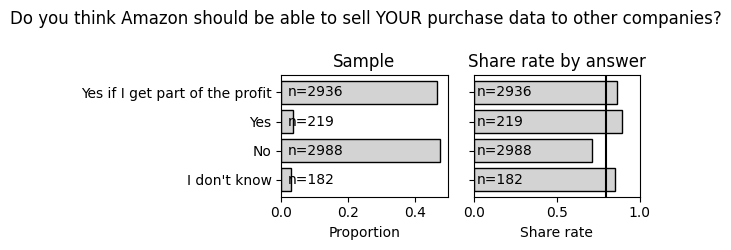

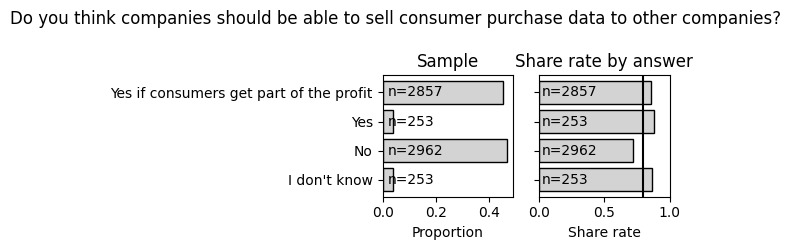

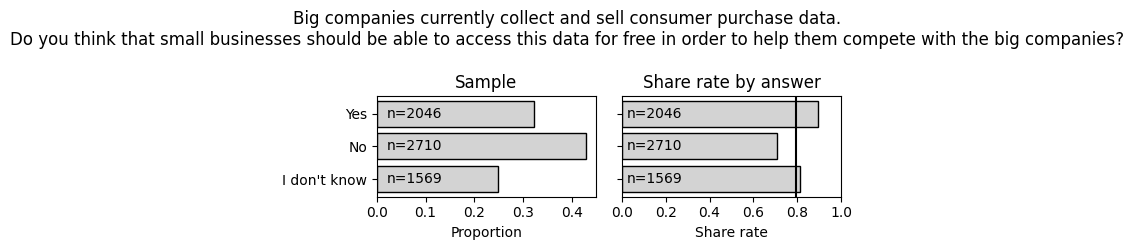

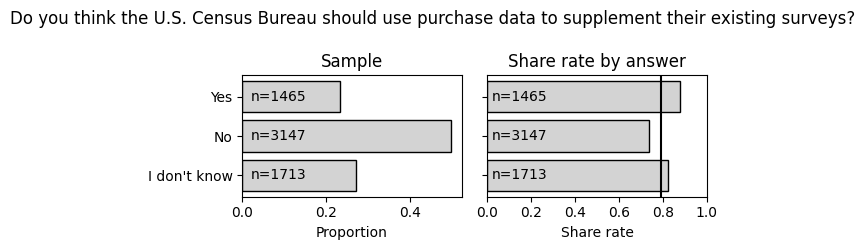

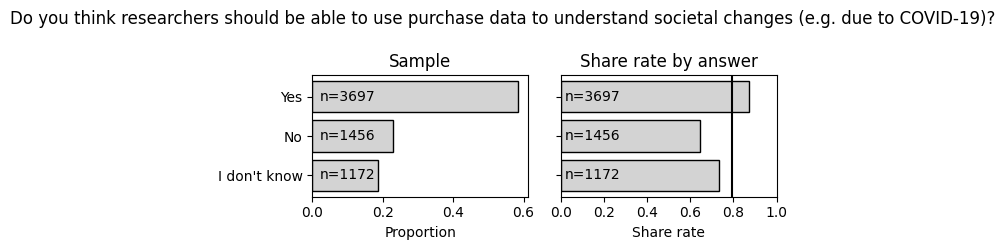

In [50]:
for i, Q in enumerate(data_use_Qs):
    q_df = df[Q].value_counts().rename('survey N').to_frame()
    q_df['survey proportion'] = (q_df['survey N']/q_df['survey N'].sum())
    q_df = q_df.sort_index()
    figsize = (3, 2.5)
    fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
    fig.suptitle(fields_df.loc[Q][0].replace('. D', '.\nD'))
    ax = axes[0]
    plot_survey_proportion_with_N(q_df, ax)
    ax.set_title('Sample')
    colname = 'answer'
    q_share_df = get_share_rate_by_Q_df(Q, colname).sort_index()
    ax = axes[1]
    plot_share_by_demo(q_share_df, colname, ax)
    plt.tight_layout()
    plt.show()
    #display(q_share_df)

## End of main analyses

Above are things we care about for the main analyses we present

---

Below are some earlier explorations

#### More regression models about what impacted share rates

- Including question about purchase frequency with interaction effects for purchase frequency previously found  significant
- Including question about whether researchers should be able to use this data greatly increases pseudo R-squared

In [51]:
formula = "share ~ showdata + C(incentive, Treatment(reference='control'))"
formula += " + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 44 years'))"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$74,999'))"
formula += " + C(edu) + C(race, Treatment(reference='White'))"
# not including state even though it does increase pseudo R-squared because 
# a) too many states leading to singular matrix
# b) does not change other effects
# formula += " + C(state)" too many states -- leads to singular matrix
formula += " + C(incentive, Treatment(reference='control'))*C(frequency)" # purchase frequency only adds information with interaction effect
formula += " + C(for_research)"
print('formula:')
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

formula:
share ~ showdata + C(incentive, Treatment(reference='control')) + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 44 years')) + C(income, Treatment(reference='\$50,000 - \$74,999')) + C(edu) + C(race, Treatment(reference='White')) + C(incentive, Treatment(reference='control'))*C(frequency) + C(for_research)
Optimization terminated successfully.
         Current function value: 0.455868
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                   Results: Logit
=====================================================================================================================================================
Model:                                          Logit                                        Pseudo R-squared:                             0.089     
Dependent Variable:                             share                                        AIC:                                          5533.8621 
Date:                                           2023-06-12 22:41                             BIC:                                          5761.6172 
No. Observations:                               5995                                         Log-Likelihood:                               -2732.9   
Df Model:                                       33                                           LL-Null:                                      -3001.3   
Df Residuals:                                   5961                                         LLR p-value:                                  2.5436e-92
Converged:                                      1.0000                                       Scale:                                        1.0000    
No. Iterations:                                 6.0000                                                                                               
-----------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              0.3211   0.1825  1.7598 0.0784 -0.0365  0.6787
showdata[T.True]                                                                                       0.3939   0.0685  5.7462 0.0000  0.2595  0.5282
C(incentive, Treatment(reference='control'))[T.altruism]                                               0.3087   0.1943  1.5888 0.1121 -0.0721  0.6894
C(incentive, Treatment(reference='control'))[T.bonus-05]                                               0.1994   0.1937  1.0294 0.3033 -0.1802  0.5790
C(incentive, Treatment(reference='control'))[T.bonus-20]                                               0.4394   0.1961  2.2403 0.0251  0.0550  0.8239
C(incentive, Treatment(reference='control'))[T.bonus-50]                                               1.1542   0.2256  5.1151 0.0000  0.7119  1.5964
C(gender, Treatment(reference='Male'))[T.Female]                                                       0.4112   0.0694  5.9252 0.0000  0.2752  0.5472
C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]                                         -0.3419   0.1138 -3.0039 0.0027 -0.5649 -0.1188
C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]                                         -0.1530   0.0890 -1.7197 0.0855 -0.3273  0.0214
C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]                                          0.1599   0.1204  1.3274 0.1844 -0.0762  0.3959
C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]                                          0.0281   0.1467  0.1917 0.8480 -0.2593  0.3156
C(age, Treatment(reference='35 - 44 years'))[T.65 and older]                                           0.1017   0.2089  0.4868 0.6264 -0.3078  0.5112
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                           -0.0693   0.1202 -0.5761 0.5646 -0.3049  0.1664
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                         0.0641   0.1139 

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.321,1.379,"[0.964, 1.971]",0.078
showdata[T.True],0.394***,1.483,"[1.296, 1.696]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.309,1.362,"[0.930, 1.993]",0.112
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.199,1.221,"[0.835, 1.784]",0.303
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.439*,1.552,"[1.057, 2.279]",0.025
"C(incentive, Treatment(reference='control'))[T.bonus-50]",1.154***,3.171,"[2.038, 4.935]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.411***,1.509,"[1.317, 1.728]",0.000
"C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]",-0.342**,0.710,"[0.568, 0.888]",0.003
"C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]",-0.153,0.858,"[0.721, 1.022]",0.085


A big big model including interaction effects and variables previously found significant

- frequency x incentive
- age x incentive -- note only significant effects for 18-24 age group
- gender x showdata

In [52]:
formula = "share ~ showdata + C(incentive, Treatment(reference='control'))"
formula += " + C(gender, Treatment(reference='Male'))*showdata"
formula += " + C(age, Treatment(reference='35 - 44 years'))*C(incentive, Treatment(reference='control'))"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$74,999'))"
formula += " + C(edu) + C(race, Treatment(reference='White'))"
formula += " + C(incentive, Treatment(reference='control'))*C(frequency)" # purchase frequency only adds information with interaction effect
formula += " + C(for_research)"
print('formula:')
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

formula:
share ~ showdata + C(incentive, Treatment(reference='control')) + C(gender, Treatment(reference='Male'))*showdata + C(age, Treatment(reference='35 - 44 years'))*C(incentive, Treatment(reference='control')) + C(income, Treatment(reference='\$50,000 - \$74,999')) + C(edu) + C(race, Treatment(reference='White')) + C(incentive, Treatment(reference='control'))*C(frequency) + C(for_research)
Optimization terminated successfully.
         Current function value: 0.453667
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                            Results: Logit
======================================================================================================================================================================
Model:                                                 Logit                                             Pseudo R-squared:                                  0.094     
Dependent Variable:                                    share                                             AIC:                                               5549.4627 
Date:                                                  2023-06-12 22:41                                  BIC:                                               5917.8901 
No. Observations:                                      5995                                              Log-Likelihood:                                    -2719.7   
Df Model:                                              54                                                LL-Null:                                           -3001.3   
Df Residuals:                                          5940                                              LLR p-value:                                       6.9572e-86
Converged:                                             1.0000                                            Scale:                                             1.0000    
No. Iterations:                                        7.0000                                                                                                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                               0.6049   0.2260  2.6762 0.0074  0.1619  1.0479
showdata[T.True]                                                                                                        0.2491   0.0923  2.6989 0.0070  0.0682  0.4300
C(incentive, Treatment(reference='control'))[T.altruism]                                                               -0.0361   0.2691 -0.1341 0.8933 -0.5635  0.4913
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                               -0.1307   0.2672 -0.4892 0.6247 -0.6543  0.3929
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                                0.1910   0.2730  0.6996 0.4842 -0.3441  0.7261
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                                1.1031   0.3272  3.3715 0.0007  0.4618  1.7443
C(gender, Treatment(reference='Male'))[T.Female]                                                                        0.2734   0.0921  2.9691 0.0030  0.0929  0.4538
C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]                                                          -0.9146   0.2425 -3.7711 0.0002 -1.3900 -0.4393
C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]                                                          -0.3765   0.2036 -1.8486 0.0645 -0.7756  0.0227
C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]                                                          -0.1731   0.2580 -0.6709 0.5023 -0.6789  0.3326
C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]                                                          -0.2158   0.3208 -0.6727 0.5012 -0.8445  0.4130
C(age, Treatment(re

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.605**,1.831,"[1.176, 2.852]",0.007
showdata[T.True],0.249**,1.283,"[1.071, 1.537]",0.007
"C(incentive, Treatment(reference='control'))[T.altruism]",-0.036,0.965,"[0.569, 1.634]",0.893
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.131,0.877,"[0.520, 1.481]",0.625
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.191,1.210,"[0.709, 2.067]",0.484
"C(incentive, Treatment(reference='control'))[T.bonus-50]",1.103**,3.013,"[1.587, 5.722]",0.001
"C(gender, Treatment(reference='Male'))[T.Female]",0.273**,1.314,"[1.097, 1.574]",0.003
"C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]",-0.915***,0.401,"[0.249, 0.645]",0.000
"C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]",-0.376,0.686,"[0.460, 1.023]",0.065


## Effect of incentives and showdata

In [53]:
formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
model = smf.logit(formula=formula, data=df).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.502463
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.012     
Dependent Variable:               share                        AIC:                          6368.1524 
Date:                             2023-06-12 22:41             BIC:                          6408.6660 
No. Observations:                 6325                         Log-Likelihood:               -3178.1   
Df Model:                         5                            LL-Null:                      -3217.0   
Df Residuals:                     6319                         LLR p-value:                  2.3286e-15
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.0617   0.0728 14.5939 0.0000  0.9191 1.2043
C(incentive, Treatment(reference='control'))[T.altruism]  0.1224   0.0957  1.2789 0.2009 -0.0652 0.3100
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1022   0.0934 -1.0946 0.2737 -0.2852 0.0808
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1694   0.0972  1.7417 0.0816 -0.0212 0.3599
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.5957   0.1055  5.6447 0.0000  0.3888 0.8025
showdata[T.True]                                          0.3171   0.0629  5.0404 0.0000  0.1938 0.4405
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.062***,2.891,"[2.507, 3.334]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.122,1.130,"[0.937, 1.363]",0.201
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.102,0.903,"[0.752, 1.084]",0.274
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.169,1.185,"[0.979, 1.433]",0.082
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.596***,1.814,"[1.475, 2.231]",0.000
showdata[T.True],0.317***,1.373,"[1.214, 1.553]",0.000


Across all incentives:
participants in the showdata:true experiment arms had 1.37 times the odds of sharing over showdata:false

### Interaction effect between incentive and showdata

- Effect of showdata:true is higher for incentives other than 'control' 
- The effect  size increases with monetary bonus and is higher for altruism incentive.

But there is no significant interaction effect between showdata and incentive – so we cannot make scientific claims about this


In [54]:
formula = "share ~ C(incentive, Treatment(reference='control'))*showdata"
model = smf.logit(formula=formula, data=df).fit()
display(model.summary2())

Optimization terminated successfully.
         Current function value: 0.502108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                     Results: Logit
========================================================================================================================
Model:                                 Logit                              Pseudo R-squared:                   0.013     
Dependent Variable:                    share                              AIC:                                6371.6680 
Date:                                  2023-06-12 22:41                   BIC:                                6439.1906 
No. Observations:                      6325                               Log-Likelihood:                     -3175.8   
Df Model:                              9                                  LL-Null:                            -3217.0   
Df Residuals:                          6315                               LLR p-value:                        5.4719e-14
Converged:                             1.0000                             Scale:                              1.0000    
No. Iterations:                        6.0000                                                                           
------------------------------------------------------------------------------------------------------------------------
                                                                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
C(incentive, Treatment(reference='control'))[T.altruism]                   0.0259   0.1314  0.1968 0.8440 -0.2316 0.2833
C(incentive, Treatment(reference='control'))[T.bonus-05]                  -0.2212   0.1279 -1.7295 0.0837 -0.4718 0.0295
C(incentive, Treatment(reference='control'))[T.bonus-20]                   0.0158   0.1315  0.1204 0.9042 -0.2418 0.2735
C(incentive, Treatment(reference='control'))[T.bonus-50]                   0.4197   0.1416  2.9639 0.0030  0.1421 0.6972
showdata[T.True]                                                           0.0950   0.1334  0.7121 0.4764 -0.1664 0.3563
C(incentive, Treatment(reference='control'))[T.altruism]:showdata[T.True]  0.2031   0.1917  1.0596 0.2893 -0.1726 0.5788
C(incentive, Treatment(reference='control'))[T.bonus-05]:showdata[T.True]  0.2531   0.1872  1.3524 0.1762 -0.1137 0.6200
C(incentive, Treatment(reference='control'))[T.bonus-20]:showdata[T.True]  0.3358   0.1959  1.7141 0.0865 -0.0482 0.7197
C(incentive, Treatment(reference='control'))[T.bonus-50]:showdata[T.True]  0.3888   0.2132  1.8235 0.0682 -0.0291 0.8068
========================================================================================================================

"""

### Focusing on impact of showing participants data (show data=true)

The showdata:true effect is not statistically signiciant when limiting to incentive=control.

Is the showdata:true effect significant when limiting to any of the incentive treatments?

For which is this the case?

Note since there is no interaction effect, so this is just exploratory.

In [55]:
formula = 'share ~ showdata'
incentives = ['control', 'altruism', 'bonus-05', 'bonus-20', 'bonus-50']
for incentive in incentives:
    print('\n--- incentive=%s ----\n' % incentive)
    model = smf.logit(formula=formula, data=df[df['incentive']==incentive]).fit()
    display(model.summary2())
    display(get_predictors_table(model))


--- incentive=control ----

Optimization terminated successfully.
         Current function value: 0.537890
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: share            AIC:              1375.6196
Date:               2023-06-12 22:41 BIC:              1385.9210
No. Observations:   1275             Log-Likelihood:   -685.81  
Df Model:           1                LL-Null:          -686.06  
Df Residuals:       1273             LLR p-value:      0.47627  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------
Intercept          1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
showdata[T.True]   0.0950   0.1334  0.7121 0.4764 -0.1664 0.3563
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.167***,3.212,"[2.676, 3.856]",0.000
showdata[T.True],0.095,1.100,"[0.847, 1.428]",0.476



--- incentive=altruism ----

Optimization terminated successfully.
         Current function value: 0.510134
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.004    
Dependent Variable: share            AIC:              1325.2473
Date:               2023-06-12 22:41 BIC:              1335.5798
No. Observations:   1295             Log-Likelihood:   -660.62  
Df Model:           1                LL-Null:          -662.98  
Df Residuals:       1293             LLR p-value:      0.029891 
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           1.1927   0.0926 12.8803 0.0000 1.0112 1.3742
showdata[T.True]    0.2981   0.1377  2.1649 0.0304 0.0282 0.5679
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.193***,3.296,"[2.749, 3.952]",0.00
showdata[T.True],0.298*,1.347,"[1.029, 1.765]",0.03



--- incentive=bonus-05 ----

Optimization terminated successfully.
         Current function value: 0.557574
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.005    
Dependent Variable: share            AIC:              1414.6616
Date:               2023-06-12 22:41 BIC:              1424.9473
No. Observations:   1265             Log-Likelihood:   -705.33  
Df Model:           1                LL-Null:          -708.87  
Df Residuals:       1263             LLR p-value:      0.0077898
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           0.9457   0.0876 10.7976 0.0000 0.7740 1.1173
showdata[T.True]    0.3481   0.1313  2.6504 0.0080 0.0907 0.6055
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.946***,2.575,"[2.168, 3.057]",0.000
showdata[T.True],0.348**,1.416,"[1.095, 1.832]",0.008



--- incentive=bonus-20 ----

Optimization terminated successfully.
         Current function value: 0.498952
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.007    
Dependent Variable: share            AIC:              1251.3808
Date:               2023-06-12 22:41 BIC:              1261.6425
No. Observations:   1250             Log-Likelihood:   -623.69  
Df Model:           1                LL-Null:          -628.27  
Df Residuals:       1248             LLR p-value:      0.0024865
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           1.1827   0.0927 12.7570 0.0000 1.0010 1.3644
showdata[T.True]    0.4307   0.1435  3.0020 0.0027 0.1495 0.7120
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.183***,3.263,"[2.721, 3.913]",0.000
showdata[T.True],0.431**,1.538,"[1.161, 2.038]",0.003



--- incentive=bonus-50 ----

Optimization terminated successfully.
         Current function value: 0.403532
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.009    
Dependent Variable: share            AIC:              1004.7588
Date:               2023-06-12 22:41 BIC:              1015.0045
No. Observations:   1240             Log-Likelihood:   -500.38  
Df Model:           1                LL-Null:          -504.69  
Df Residuals:       1238             LLR p-value:      0.0033243
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           1.5865   0.1066 14.8825 0.0000 1.3776 1.7955
showdata[T.True]    0.4838   0.1664  2.9077 0.0036 0.1577 0.8099
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.587***,4.887,"[3.965, 6.022]",0.000
showdata[T.True],0.484**,1.622,"[1.171, 2.248]",0.004


```
This effect varies by incentive arm. 
This effect is not statistically significant for the control, but is statistically significant for all other incentive arms.
The effect  size increases with monetary bonus.

incentive=control: Treatment is not statistically significant
For all other incentives, p < 0.05
incentive=altruism
showdata:true experiment arm had 1.35 times the odds of sharing over showdata:false
incentive=bonus:0.05
showdata:true experiment arm had 1.4 times the odds of sharing over showdata:false
incentive=bonus:0.20
showdata:true experiment arm had 1.54 times the odds of sharing over showdata:false
incentive=bonus:0.50
showdata:true experiment arm had 1.62 times the odds of sharing over showdata:false

```

### Effect of incentives

Look across both showdata:true/false

Look at each of showdata:true/false independently

Note since there is no interaction effect, this is exploratory.

Across all data

In [56]:
# Across all data
formula = "share ~ C(incentive, Treatment(reference='control'))"
model = smf.logit(formula=formula, data=df).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.504486
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.008     
Dependent Variable:               share                        AIC:                          6391.7430 
Date:                             2023-06-12 22:41             BIC:                          6425.5043 
No. Observations:                 6325                         Log-Likelihood:               -3190.9   
Df Model:                         4                            LL-Null:                      -3217.0   
Df Residuals:                     6320                         LLR p-value:                  1.1999e-10
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.2139   0.0666 18.2129 0.0000  1.0832 1.3445
C(incentive, Treatment(reference='control'))[T.altruism]  0.1202   0.0955  1.2583 0.2083 -0.0670 0.3074
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1057   0.0932 -1.1350 0.2564 -0.2883 0.0768
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1625   0.0970  1.6747 0.0940 -0.0277 0.3526
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.5921   0.1053  5.6211 0.0000  0.3856 0.7985
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.214***,3.366,"[2.954, 3.836]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.12,1.128,"[0.935, 1.360]",0.208
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.106,0.900,"[0.750, 1.080]",0.256
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.162,1.176,"[0.973, 1.423]",0.094
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.592***,1.808,"[1.471, 2.222]",0.000


By showdata arm

In [57]:
print('---- For showdata:True ----')
formula = "share ~ C(incentive, Treatment(reference='control'))"
model = smf.logit(formula=formula, data=df[df['showdata']==True]).fit()
display(model.summary2())
display(get_predictors_table(model))

---- For showdata:True ----
Optimization terminated successfully.
         Current function value: 0.465866
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
======================================================================================================
Model:                           Logit                        Pseudo R-squared:             0.012     
Dependent Variable:              share                        AIC:                          2914.2069 
Date:                            2023-06-12 22:41             BIC:                          2944.4300 
No. Observations:                3117                         Log-Likelihood:               -1452.1   
Df Model:                        4                            LL-Null:                      -1469.2   
Df Residuals:                    3112                         LLR p-value:                  6.5344e-07
Converged:                       1.0000                       Scale:                        1.0000    
No. Iterations:                  6.0000                                                               
------------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------------------------------------
Intercept                                                1.2618   0.0954 13.2275 0.0000  1.0749 1.4488
C(incentive, Treatment(reference='control'))[T.altruism] 0.2290   0.1396  1.6404 0.1009 -0.0446 0.5025
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.0320   0.1367  0.2338 0.8151 -0.2359 0.2998
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.3516   0.1452  2.4209 0.0155  0.0669 0.6362
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.8085   0.1594  5.0709 0.0000  0.4960 1.1210
======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.262***,3.532,"[2.930, 4.258]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.229,1.257,"[0.956, 1.653]",0.101
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.032,1.032,"[0.790, 1.350]",0.815
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.352*,1.421,"[1.069, 1.889]",0.015
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.809***,2.245,"[1.642, 3.068]",0.000


In [58]:
print('---- For showdata:False -----')
formula = "share ~ C(incentive, Treatment(reference='control'))"
model = smf.logit(formula=formula, data=df[df['showdata']==False]).fit()
display(model.summary2())
display(get_predictors_table(model))

---- For showdata:False -----
Optimization terminated successfully.
         Current function value: 0.537322
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.007     
Dependent Variable:               share                        AIC:                          3457.4611 
Date:                             2023-06-12 22:41             BIC:                          3487.8281 
No. Observations:                 3208                         Log-Likelihood:               -1723.7   
Df Model:                         4                            LL-Null:                      -1735.0   
Df Residuals:                     3203                         LLR p-value:                  0.00015511
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   5.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
C(incentive, Treatment(reference='control'))[T.altruism]  0.0259   0.1314  0.1968 0.8440 -0.2316 0.2833
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.2212   0.1279 -1.7295 0.0837 -0.4718 0.0295
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.0158   0.1315  0.1204 0.9042 -0.2418 0.2735
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4197   0.1416  2.9639 0.0030  0.1421 0.6972
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.167***,3.212,"[2.676, 3.856]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.026,1.026,"[0.793, 1.328]",0.844
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.221,0.802,"[0.624, 1.030]",0.084
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.016,1.016,"[0.785, 1.315]",0.904
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.42**,1.521,"[1.153, 2.008]",0.003


### Inspecting demographic groups

#### By gender

How do you describe yourself?


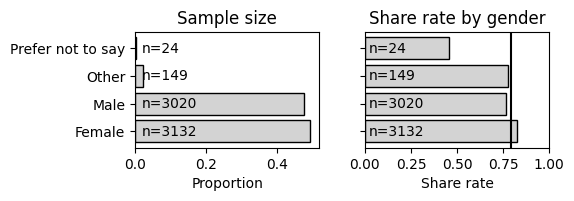

,gender,n,share rate
0,Female,3132,0.825
1,Male,3020,0.765
2,Other,149,0.779
3,Prefer not to say,24,0.458


In [80]:
Q = 'Q-demos-gender'
print(fields_df.loc[Q][0])
gender_df = df[Q].value_counts().rename('survey N').to_frame()
gender_df['survey proportion'] = gender_df['survey N']/gender_df['survey N'].sum()
figsize=(2.5, 1.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(gender_df, axes[0])
axes[0].set_title('Sample size')
colname = 'gender'
gender_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(gender_share_df, colname, axes[1])
plt.show()
gender_share_df

control only


,gender,n,share rate
0,Female,654,0.786
1,Male,584,0.764
2,Other,32,0.688
3,Prefer not to say,5,0.200


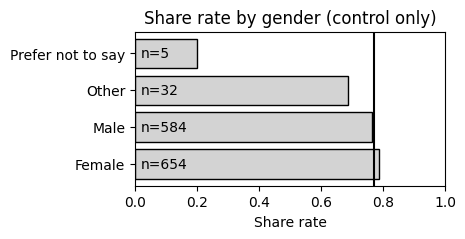

In [81]:
print('control only')
gender_share_df = get_share_rate_by_Q_df(Q, colname, df=control_df)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(gender_share_df)))
plot_share_by_demo(gender_share_df, colname, ax, control_only=True)
gender_share_df

Model: Are females significantly more likely to share versus males?

We limit model data to just Male/Female binary

Answer:

- Yes when we include all experimental arms
- No when just the control arm

In [82]:
# limit to just male/female
# mape male/female to binary 0/1

gender_binary_df = df[df[Q].isin(['Male','Female'])].copy()
gender_binary_df['gender'] = gender_binary_df[Q]
formula = "share ~ C(gender, Treatment(reference='Male'))"
model = smf.logit(formula=formula, data=gender_binary_df).fit()
print('\n',formula)
display(model.summary2())
display(get_predictors_table(model))
# check for just the control group too
model = smf.logit(formula=formula, data=get_control_df(gender_binary_df)).fit()
print('\nControl arm only:\n',formula)
display(model.summary2())

Optimization terminated successfully.
         Current function value: 0.503525
         Iterations 5

 share ~ C(gender, Treatment(reference='Male'))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: Logit
=============================================================================================
Model:                        Logit                     Pseudo R-squared:          0.006     
Dependent Variable:           share                     AIC:                       6199.3724 
Date:                         2023-06-12 22:42          BIC:                       6212.8214 
No. Observations:             6152                      Log-Likelihood:            -3097.7   
Df Model:                     1                         LL-Null:                   -3115.0   
Df Residuals:                 6150                      LLR p-value:               4.0181e-09
Converged:                    1.0000                    Scale:                     1.0000    
No. Iterations:               5.0000                                                         
---------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                        1.1797   0.0429 27.4927 0.0000 1.0956 1.2638
C(gender, Treatment(reference='Male'))[T.Female] 0.3733   0.0637  5.8612 0.0000 0.2485 0.4981
=============================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.18***,3.254,"[2.991, 3.539]",0.0
"C(gender, Treatment(reference='Male'))[T.Female]",0.373***,1.453,"[1.282, 1.646]",0.0


Optimization terminated successfully.
         Current function value: 0.532260
         Iterations 5

Control arm only:
 share ~ C(gender, Treatment(reference='Male'))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                        Results: Logit
==============================================================================================
Model:                        Logit                      Pseudo R-squared:           0.001    
Dependent Variable:           share                      AIC:                        1321.8768
Date:                         2023-06-12 22:42           BIC:                        1332.1194
No. Observations:             1238                       Log-Likelihood:             -658.94  
Df Model:                     1                          LL-Null:                    -659.38  
Df Residuals:                 1236                       LLR p-value:                0.34958  
Converged:                    1.0000                     Scale:                      1.0000   
No. Iterations:               5.0000                                                          
----------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                        1.1731   0.0974 12.0427 0.0000  0.9821 1.3640
C(gender, Treatment(reference='Male'))[T.Female] 0.1275   0.1363  0.9356 0.3495 -0.1396 0.3947
==============================================================================================

"""

In [83]:
gender_agg_df = get_aggregate_share_df(gender_binary_df, extra_groupby=Q)
gender_agg_df

,incentive,showdata,Q-demos-gender,n,share rate
0,control,False,Female,333,0.763
1,control,False,Male,286,0.759
2,control,True,Female,321,0.810
3,control,True,Male,298,0.768
4,bonus-05,False,Female,306,0.732
5,bonus-05,False,Male,325,0.705
6,bonus-05,True,Female,301,0.841
7,bonus-05,True,Male,301,0.734
8,bonus-20,False,Female,326,0.776
9,bonus-20,False,Male,308,0.756


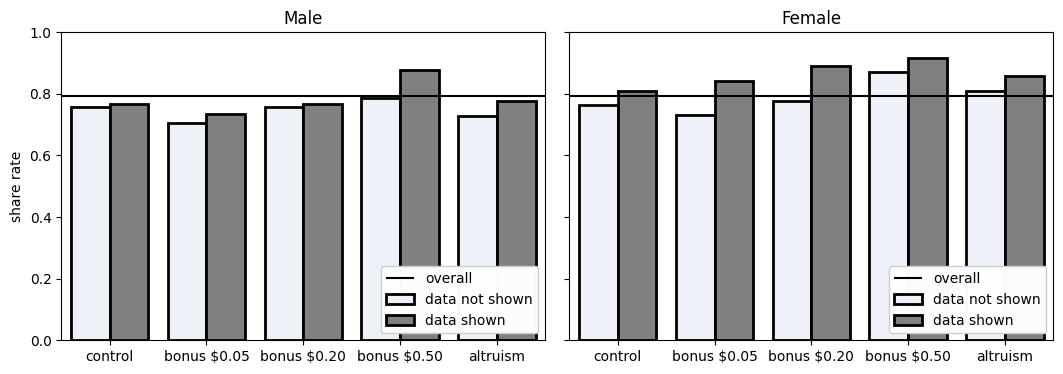

In [84]:
figsize=(6.4,4)
fig,axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.05)
for i, g in enumerate(['Male','Female']):
    demo_df = df[df[Q]==g]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(g)

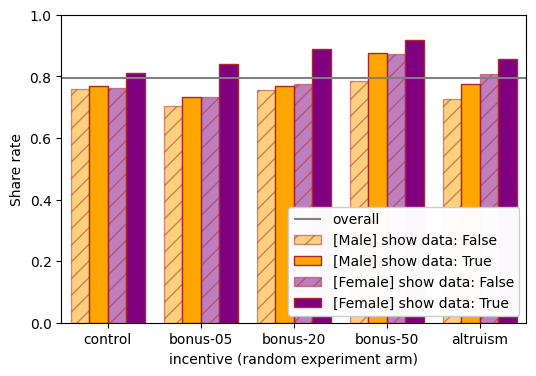

In [86]:
# Plot males and females side by side
gender_colors = {'Male':'orange', 'Female':'purple'}
width = 0.2
figsize=(6,4)
fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
male_df = gender_agg_df[gender_agg_df[Q]=='Male']
female_df = gender_agg_df[gender_agg_df[Q]=='Female']

g = 'Male'
pdf = male_df[male_df['showdata']==False]
pdf['share rate'].plot(kind='bar', ax=ax, width=width, position=2,
         color=gender_colors[g], edgecolor='brown', alpha=0.5, hatch='//', 
         label='[%s] show data: False'%g)
pdf = male_df[male_df['showdata']==True]
pdf['share rate'].plot(kind='bar', ax=ax, width=width, position=1,
         color=gender_colors[g], edgecolor='brown',
         label='[%s] show data: True'%g)
g = 'Female'
pdf = female_df[female_df['showdata']==False]
pdf['share rate'].plot(kind='bar', ax=ax, width=width, position=0,
         color=gender_colors[g], edgecolor='brown', alpha=0.5, hatch='//', 
         label='[%s] show data: False'%g)
pdf = female_df[female_df['showdata']==True]
pdf['share rate'].plot(kind='bar', ax=ax, width=width, position=-1,
         color=gender_colors[g], edgecolor='brown',
         label='[%s] show data: True'%g)
if overall_share_rate is not None:
    ax.hlines(overall_share_rate, -1, 5, color='gray', label='overall')
ax.set_ylabel('Share rate')
ax.set_xlabel('incentive (random experiment arm)')
ax.set_xlim([-0.5,4.5])
ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
ax.set_ylim([0,1])
_ = ax.set_xticklabels(pdf['incentive'], rotation=0)

### Interaction effects for gender


In [87]:
formula = "share ~ showdata*C(gender, Treatment(reference='Male')) + C(incentive, Treatment(reference='control'))*C(gender, Treatment(reference='Male'))"
print(formula)
model = smf.logit(formula=formula, data=gender_binary_df).fit()
display(model.summary2())
display(get_predictors_table(model))

share ~ showdata*C(gender, Treatment(reference='Male')) + C(incentive, Treatment(reference='control'))*C(gender, Treatment(reference='Male'))
Optimization terminated successfully.
         Current function value: 0.495813
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                     Results: Logit
========================================================================================================================================================
Model:                                           Logit                                         Pseudo R-squared:                              0.021     
Dependent Variable:                              share                                         AIC:                                           6124.4780 
Date:                                            2023-06-12 22:43                              BIC:                                           6205.1724 
No. Observations:                                6152                                          Log-Likelihood:                                -3050.2   
Df Model:                                        11                                            LL-Null:                                       -3115.0   
Df Residuals:                                    6140                                          LLR p-value:                                   2.1880e-22
Converged:                                       1.0000                                        Scale:                                         1.0000    
No. Iterations:                                  6.0000                                                                                                 
--------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                  1.0667   0.1060 10.0588 0.0000  0.8588 1.2745
showdata[T.True]                                                                                           0.2144   0.0865  2.4796 0.0132  0.0449 0.3839
C(gender, Treatment(reference='Male'))[T.Female]                                                          -0.0014   0.1485 -0.0097 0.9922 -0.2926 0.2897
C(incentive, Treatment(reference='control'))[T.altruism]                                                  -0.0636   0.1340 -0.4751 0.6347 -0.3262 0.1989
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                  -0.2285   0.1320 -1.7305 0.0835 -0.4873 0.0303
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                  -0.0035   0.1378 -0.0252 0.9799 -0.2735 0.2666
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                   0.4291   0.1472  2.9156 0.0035  0.1406 0.7176
showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female]                                          0.3042   0.1298  2.3439 0.0191  0.0498 0.5586
C(incentive, Treatment(reference='control'))[T.altruism]:C(gender, Treatment(reference='Male'))[T.Female]  0.3681   0.1967  1.8716 0.0613 -0.0174 0.7536
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(gender, Treatment(reference='Male'))[T.Female]  0.2253   0.1911  1.1788 0.2385 -0.1493 0.5998
C(incentive, Treatment(reference='control'))[T.bonus-20]:C(gender, Treatment(reference='Male'))[T.Female]  0.3043   0.1988  1.5309 0.1258 -0.0853 0.6940
C(incentive, Treatment(reference='control'))[T.bonus-50]:C(gender, Treatment(reference='Male'))[T.Female]  0.4091   0.2195  1.8637 0.0624 -0.0211 0.8394
========================================================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.067***,2.906,"[2.360, 3.577]",0.000
showdata[T.True],0.214*,1.239,"[1.046, 1.468]",0.013
"C(gender, Treatment(reference='Male'))[T.Female]",-0.001,0.999,"[0.746, 1.336]",0.992
"C(incentive, Treatment(reference='control'))[T.altruism]",-0.064,0.938,"[0.722, 1.220]",0.635
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.229,0.796,"[0.614, 1.031]",0.084
"C(incentive, Treatment(reference='control'))[T.bonus-20]",-0.003,0.997,"[0.761, 1.305]",0.980
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.429**,1.536,"[1.151, 2.049]",0.004
"showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female]",0.304*,1.356,"[1.051, 1.748]",0.019
"C(incentive, Treatment(reference='control'))[T.altruism]:C(gender, Treatment(reference='Male'))[T.Female]",0.368,1.445,"[0.983, 2.125]",0.061


### Interaction effect between gender and showdata



In [88]:
formula = "share ~ showdata*C(gender, Treatment(reference='Male'))"
print(formula)
model = smf.logit(formula=formula, data=gender_binary_df).fit()
display(model.summary2())
display(get_predictors_table(model))

share ~ showdata*C(gender, Treatment(reference='Male'))
Optimization terminated successfully.
         Current function value: 0.500669
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Results: Logit
==============================================================================================================
Model:                             Logit                           Pseudo R-squared:                0.011     
Dependent Variable:                share                           AIC:                             6168.2308 
Date:                              2023-06-12 22:43                BIC:                             6195.1289 
No. Observations:                  6152                            Log-Likelihood:                  -3080.1   
Df Model:                          3                               LL-Null:                         -3115.0   
Df Residuals:                      6148                            LLR p-value:                     4.8128e-15
Converged:                         1.0000                          Scale:                           1.0000    
No. Iterations:                    6.0000                                                                     
--------------------------------------------------------------------------------------------------------------
                                                                  Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                                         1.0725   0.0588 18.2353 0.0000 0.9572 1.1878
showdata[T.True]                                                  0.2228   0.0861  2.5876 0.0097 0.0540 0.3916
C(gender, Treatment(reference='Male'))[T.Female]                  0.2532   0.0850  2.9788 0.0029 0.0866 0.4198
showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female] 0.2850   0.1291  2.2067 0.0273 0.0319 0.5381
==============================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.073***,2.923,"[2.604, 3.280]",0.000
showdata[T.True],0.223*,1.250,"[1.056, 1.479]",0.010
"C(gender, Treatment(reference='Male'))[T.Female]",0.253**,1.288,"[1.090, 1.522]",0.003
"showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female]",0.285*,1.330,"[1.032, 1.713]",0.027


### By income group

In [89]:
income_order = [
    'Prefer not to say', 'Less than \$25,000','\$25,000 - \$49,999',  '\$50,000 - \$74,999', 
    '\$75,000 - \$99,999',  '\$100,000 - \$149,999', '\$150,000 or more'
]

Overall

What was your total household income before taxes during the past 12 months?


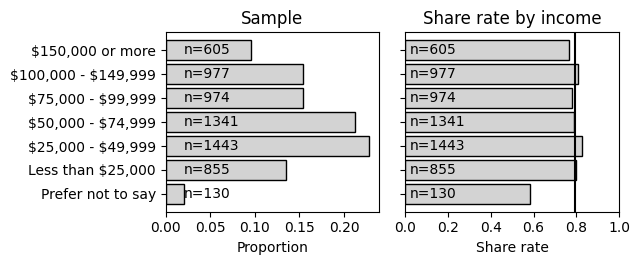

,income,n,share rate
0,Prefer not to say,130,0.585
1,"Less than \$25,000",855,0.801
2,"\$25,000 - \$49,999",1443,0.825
3,"\$50,000 - \$74,999",1341,0.791
4,"\$75,000 - \$99,999",974,0.779
5,"\$100,000 - \$149,999",977,0.807
6,"\$150,000 or more",605,0.764


In [90]:
Q = 'Q-demos-income'
print(fields_df.loc[Q][0])
income_df = df[Q].value_counts().rename('survey N').to_frame()
income_df['survey proportion'] = income_df['survey N']/income_df['survey N'].sum()
# order by income
income_df = income_df.loc[income_order]
figsize = (3.25, 2.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
ax = axes[0]
plot_survey_proportion_with_N(income_df, ax)
ax.set_title('Sample')
colname = 'income'
income_share_df = get_share_rate_by_Q_df(Q, colname)
# order by income
income_share_df = income_share_df.set_index('income').loc[income_order].reset_index()
ax = axes[1]
plot_share_by_demo(income_share_df, colname, ax)
plt.tight_layout()
plt.show()
income_share_df

Are there interaction effects between experimental arms and income groups?

Using \\$50,000 - \\$74,999 as reference 

In [91]:
formula = "share ~ showdata*C(income, Treatment(reference='\$50,000 - \$74,999')) + C(incentive, Treatment(reference='control'))*C(income, Treatment(reference='\$50,000 - \$74,999'))"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.493942
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                    Results: Logit
======================================================================================================================================================================================
Model:                                                     Logit                                                   Pseudo R-squared:                                        0.017     
Dependent Variable:                                        share                                                   AIC:                                                     6191.9461 
Date:                                                      2023-06-12 22:43                                        BIC:                                                     6434.2800 
No. Observations:                                          6195                                                    Log-Likelihood:                                          -3060.0   
Df Model:                                                  35                                                      LL-Null:                                                 -3113.8   
Df Residuals:                                              6159                                                    LLR p-value:                                             2.5386e-09
Converged:                                                 1.0000                                                  Scale:                                                   1.0000    
No. Iterations:                                            6.0000                                                                                                                     
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                         Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                1.0821   0.1603  6.7488 0.0000  0.7678 1.3964
showdata[T.True]                                                                                                                         0.3367   0.1360  2.4764 0.0133  0.0702 0.6031
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                                                             -0.1345   0.2616 -0.5142 0.6071 -0.6472 0.3782
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                                                           0.1849   0.2494  0.7415 0.4584 -0.3038 0.6737
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                                                              -0.2018   0.2733 -0.7383 0.4603 -0.7375 0.3339
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                                                             0.2336   0.2289  1.0204 0.3075 -0.2151 0.6822
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                                                            -0.1283   0.2404 -0.5339 0.5934 -0.5995 0.3428
C(incentive, Treatment(reference='control'))[T.altruism]                                                                                 0.1010   0.2070  0.4879 0.6256 -0.3047 0.5067
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                                                 0.0208   0.2121  0.0979 0.9220 -0.3950 0.4365
C(incenti

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.082***,2.951,"[2.155, 4.040]",0.000
showdata[T.True],0.337*,1.400,"[1.073, 1.828]",0.013
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]",-0.134,0.874,"[0.524, 1.460]",0.607
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]",0.185,1.203,"[0.738, 1.961]",0.458
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]",-0.202,0.817,"[0.478, 1.396]",0.460
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]",0.234,1.263,"[0.806, 1.978]",0.308
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]",-0.128,0.880,"[0.549, 1.409]",0.593
"C(incentive, Treatment(reference='control'))[T.altruism]",0.101,1.106,"[0.737, 1.660]",0.626
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.021,1.021,"[0.674, 1.547]",0.922


Test for interaction effect only between income group and incentive

In [92]:
formula = "share ~ C(incentive, Treatment(reference='control'))*C(income, Treatment(reference='\$50,000 - \$74,999'))"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.496405
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                    Results: Logit
======================================================================================================================================================================================
Model:                                                     Logit                                                   Pseudo R-squared:                                        0.012     
Dependent Variable:                                        share                                                   AIC:                                                     6210.4562 
Date:                                                      2023-06-12 22:43                                        BIC:                                                     6412.4011 
No. Observations:                                          6195                                                    Log-Likelihood:                                          -3075.2   
Df Model:                                                  29                                                      LL-Null:                                                 -3113.8   
Df Residuals:                                              6165                                                    LLR p-value:                                             2.9977e-06
Converged:                                                 1.0000                                                  Scale:                                                   1.0000    
No. Iterations:                                            6.0000                                                                                                                     
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                         Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                1.2329   0.1492  8.2621 0.0000  0.9404 1.5253
C(incentive, Treatment(reference='control'))[T.altruism]                                                                                 0.0996   0.2065  0.4822 0.6296 -0.3052 0.5044
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                                                 0.0324   0.2116  0.1529 0.8785 -0.3823 0.4470
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                                                -0.0425   0.2106 -0.2020 0.8399 -0.4554 0.3703
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                                                 0.4254   0.2221  1.9153 0.0555 -0.0099 0.8606
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                                                             -0.0747   0.2384 -0.3131 0.7542 -0.5420 0.3926
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                                                           0.1354   0.2283  0.5931 0.5531 -0.3121 0.5829
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                                                              -0.1968   0.2516 -0.7820 0.4342 -0.6900 0.2964
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                                                             0.2420   0.2122  1.1404 0.2541 -0.1739 0.6579
C(income,

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.233***,3.431,"[2.561, 4.597]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.1,1.105,"[0.737, 1.656]",0.630
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.032,1.033,"[0.682, 1.564]",0.878
"C(incentive, Treatment(reference='control'))[T.bonus-20]",-0.043,0.958,"[0.634, 1.448]",0.840
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.425,1.530,"[0.990, 2.365]",0.055
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]",-0.075,0.928,"[0.582, 1.481]",0.754
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]",0.135,1.145,"[0.732, 1.791]",0.553
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]",-0.197,0.821,"[0.502, 1.345]",0.434
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]",0.242,1.274,"[0.840, 1.931]",0.254


#### Evaluate each incentive arm separately

Q-demos-income
share ~ C(income, Treatment(reference='\$50,000 - \$74,999'))*showdata
------- control -------
Optimization terminated successfully.
         Current function value: 0.526823
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                Results: Logit
==============================================================================================================================================
Model:                                        Logit                                      Pseudo R-squared:                           0.021    
Dependent Variable:                           share                                      AIC:                                        1371.3991
Date:                                         2023-06-12 22:43                           BIC:                                        1443.5089
No. Observations:                             1275                                       Log-Likelihood:                             -671.70  
Df Model:                                     13                                         LL-Null:                                    -686.06  
Df Residuals:                                 1261                                       LLR p-value:                                0.0071530
Converged:                                    1.0000                                     Scale:                                      1.0000   
No. Iterations:                               5.0000                                                                                          
----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                        1.0598   0.1961  5.4030 0.0000  0.6753 1.4442
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                     -0.0724   0.3327 -0.2175 0.8278 -0.7245 0.5798
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                      -0.8085   0.5408 -1.4950 0.1349 -1.8684 0.2514
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                   0.4319   0.3264  1.3232 0.1858 -0.2078 1.0716
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                      -0.2713   0.3335 -0.8136 0.4159 -0.9249 0.3823
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                     0.4779   0.2919  1.6373 0.1016 -0.0942 1.0500
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                     0.0516   0.2993  0.1723 0.8632 -0.5351 0.6382
showdata[T.True]                                                                                 0.3897   0.3036  1.2837 0.1992 -0.2053 0.9847
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]    -0.0730   0.4809 -0.1518 0.8793 -1.0157 0.8696
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]     -1.3342   0.7721 -1.7280 0.0840 -2.8474 0.1791
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True] -0.6168   0.4622 -1.3344 0.1821 -1.5227 0.2892
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]      0.1487   0.5121  0.2904 0.7715 -0.8549 1.1523
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]   -0.5147   0.4281 -1.2021 0.2293 -1.3538 0.3244
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]   -0.2746   0.4495 -0.6109 0.5413 -1.1556 0.6064
==============================================================================================================================================

"""

------- bonus-05 -------
Optimization terminated successfully.
         Current function value: 0.550230
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                Results: Logit
===============================================================================================================================================
Model:                                         Logit                                      Pseudo R-squared:                           0.018    
Dependent Variable:                            share                                      AIC:                                        1420.0830
Date:                                          2023-06-12 22:43                           BIC:                                        1492.0826
No. Observations:                              1265                                       Log-Likelihood:                             -696.04  
Df Model:                                      13                                         LL-Null:                                    -708.87  
Df Residuals:                                  1251                                       LLR p-value:                                0.018879 
Converged:                                     1.0000                                     Scale:                                      1.0000   
No. Iterations:                                5.0000                                                                                          
-----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                        1.1407   0.2063  5.5289 0.0000  0.7363  1.5451
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                     -0.0715   0.3178 -0.2251 0.8219 -0.6943  0.5513
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                      -1.1407   0.5146 -2.2168 0.0266 -2.1493 -0.1322
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                   0.0278   0.3155  0.0883 0.9297 -0.5906  0.6463
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                      -0.2340   0.3308 -0.7074 0.4793 -0.8823  0.4143
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                    -0.0036   0.2853 -0.0128 0.9898 -0.5629  0.5556
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                    -0.7187   0.2898 -2.4804 0.0131 -1.2866 -0.1508
showdata[T.True]                                                                                 0.2551   0.3009  0.8479 0.3965 -0.3347  0.8449
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]     0.0168   0.4724  0.0356 0.9716 -0.9091  0.9427
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]     -0.1010   0.7889 -0.1280 0.8981 -1.6471  1.4451
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True] -0.1525   0.4508 -0.3383 0.7352 -1.0360  0.7311
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]     -0.0413   0.4958 -0.0832 0.9337 -1.0130  0.9305
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]    0.0741   0.4183  0.1772 0.8594 -0.7458  0.8940
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]    0.5216   0.4477  1.1649 0.2440 -0.3559  1.3991
================================================================================================================================

------- bonus-20 -------
Optimization terminated successfully.
         Current function value: 0.495200
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                Results: Logit
==============================================================================================================================================
Model:                                        Logit                                      Pseudo R-squared:                           0.015    
Dependent Variable:                           share                                      AIC:                                        1266.0011
Date:                                         2023-06-12 22:43                           BIC:                                        1337.8337
No. Observations:                             1250                                       Log-Likelihood:                             -619.00  
Df Model:                                     13                                         LL-Null:                                    -628.27  
Df Residuals:                                 1236                                       LLR p-value:                                0.13841  
Converged:                                    1.0000                                     Scale:                                      1.0000   
No. Iterations:                               6.0000                                                                                          
----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                        1.0062   0.2004  5.0209 0.0000  0.6134 1.3990
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                      0.1932   0.3151  0.6130 0.5399 -0.4245 0.8109
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                      -0.6698   0.6189 -1.0822 0.2792 -1.8828 0.5432
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                   0.3801   0.3157  1.2037 0.2287 -0.2388 0.9989
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                       0.2701   0.3831  0.7049 0.4808 -0.4808 1.0209
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                     0.2465   0.2792  0.8828 0.3773 -0.3008 0.7938
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                     0.1595   0.3079  0.5180 0.6044 -0.4440 0.7630
showdata[T.True]                                                                                 0.3900   0.3001  1.2995 0.1938 -0.1982 0.9782
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]     0.3565   0.5133  0.6945 0.4874 -0.6496 1.3626
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]      0.6598   1.2973  0.5086 0.6110 -1.8828 3.2024
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True] -0.3140   0.4631 -0.6782 0.4977 -1.2216 0.5935
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]     -0.0977   0.5635 -0.1734 0.8624 -1.2020 1.0067
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]    0.3804   0.4457  0.8536 0.3933 -0.4931 1.2540
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]   -0.1695   0.4588 -0.3694 0.7119 -1.0687 0.7298
==============================================================================================================================================

"""

------- bonus-50 -------
Optimization terminated successfully.
         Current function value: 0.396065
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                Results: Logit
==============================================================================================================================================
Model:                                        Logit                                      Pseudo R-squared:                           0.027    
Dependent Variable:                           share                                      AIC:                                        1010.2417
Date:                                         2023-06-12 22:43                           BIC:                                        1081.9618
No. Observations:                             1240                                       Log-Likelihood:                             -491.12  
Df Model:                                     13                                         LL-Null:                                    -504.69  
Df Residuals:                                 1226                                       LLR p-value:                                0.011913 
Converged:                                    1.0000                                     Scale:                                      1.0000   
No. Iterations:                               7.0000                                                                                          
----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                        1.5559   0.2295  6.7805 0.0000  1.1061 2.0056
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                     -0.0850   0.3535 -0.2404 0.8100 -0.7779 0.6079
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                      -0.1696   0.6851 -0.2475 0.8045 -1.5123 1.1732
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                  -0.1565   0.3439 -0.4550 0.6491 -0.8305 0.5176
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                      -0.2749   0.4248 -0.6472 0.5175 -1.1075 0.5576
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                     0.3672   0.3361  1.0926 0.2746 -0.2915 1.0260
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                     0.1181   0.3631  0.3253 0.7449 -0.5935 0.8297
showdata[T.True]                                                                                 0.2036   0.3293  0.6183 0.5364 -0.4419 0.8491
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]     0.2843   0.5334  0.5330 0.5940 -0.7612 1.3298
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]     -1.5899   0.9618 -1.6530 0.0983 -3.4751 0.2952
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True]  0.7818   0.5745  1.3607 0.1736 -0.3443 1.9079
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]      0.6749   0.6497  1.0388 0.2989 -0.5985 1.9483
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]    0.1069   0.5109  0.2091 0.8343 -0.8946 1.1083
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]    0.8014   0.5833  1.3739 0.1695 -0.3419 1.9448
==============================================================================================================================================

"""

------- altruism -------
         Current function value: 0.504832
         Iterations: 35


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                    Results: Logit
======================================================================================================================================================
Model:                                            Logit                                        Pseudo R-squared:                             0.014    
Dependent Variable:                               share                                        AIC:                                          1335.5157
Date:                                             2023-06-12 22:43                             BIC:                                          1407.8434
No. Observations:                                 1295                                         Log-Likelihood:                               -653.76  
Df Model:                                         13                                           LL-Null:                                      -662.98  
Df Residuals:                                     1281                                         LLR p-value:                                  0.14127  
Converged:                                        0.0000                                       Scale:                                        1.0000   
No. Iterations:                                   35.0000                                                                                             
------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         1.1499    0.1861  6.1775 0.0000     0.7851    1.5147
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                       0.2082    0.3232  0.6441 0.5195    -0.4253    0.8418
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                       15.4597 1650.6587  0.0094 0.9925 -3219.7719 3250.6913
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                    0.1029    0.3145  0.3270 0.7437    -0.5136    0.7193
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                       -0.2089    0.3486 -0.5993 0.5490    -0.8922    0.4744
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                      0.1327    0.2708  0.4900 0.6241    -0.3981    0.6636
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                     -0.1283    0.2916 -0.4399 0.6600    -0.6997    0.4432
showdata[T.True]                                                                                  0.4170    0.2916  1.4301 0.1527    -0.1545    0.9884
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]     -0.2095    0.4911 -0.4265 0.6698    -1.1721    0.7531
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]     -16.4205 1650.6588 -0.0099 0.9921 -3251.6522 3218.8113
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True]  -0.0211    0.4783 -0.0441 0.9649    -0.9586    0.9164
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]      -0.4219    0.4914 -0.8584 0.3907    -1.3851    0.5413
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]     0.0401    0.4181  0.0959 0.9236    -0.7794    0.8596
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]

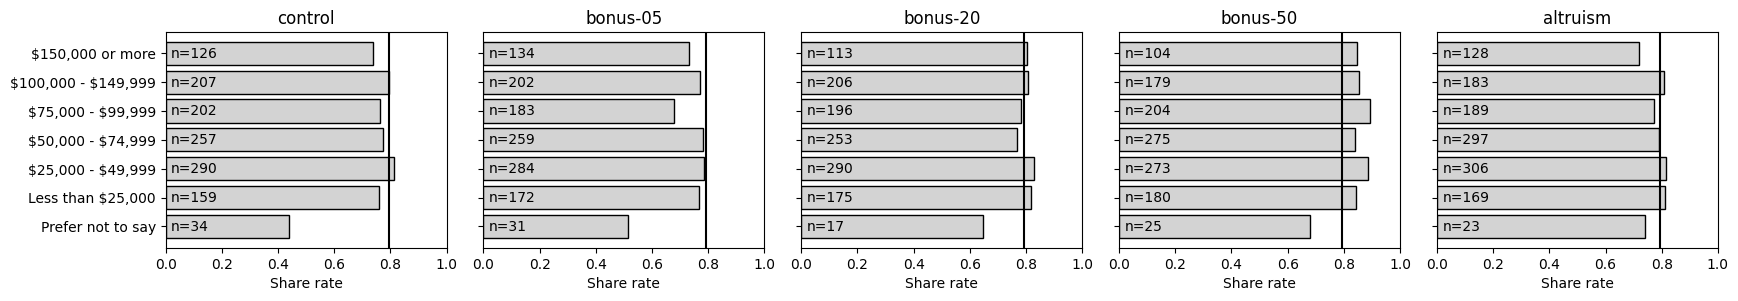

In [93]:
print(Q)
formula = "share ~ C(income, Treatment(reference='\$50,000 - \$74,999'))*showdata"
print(formula)

figsize = (3.25, 2.75)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.tight_layout()

for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['income'] = incentive_df[Q]
    print('------- %s -------' % incentive)
    income_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # order by income
    income_share_df = income_share_df.set_index('income').loc[income_order].reset_index()
    #display(income_share_df)
    # plot horizontally with the others
    plot_share_by_demo(income_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    model = smf.logit(formula=formula, data=incentive_df).fit()
    display(model.summary2())
plt.show()

#### Evaluate each income group separately

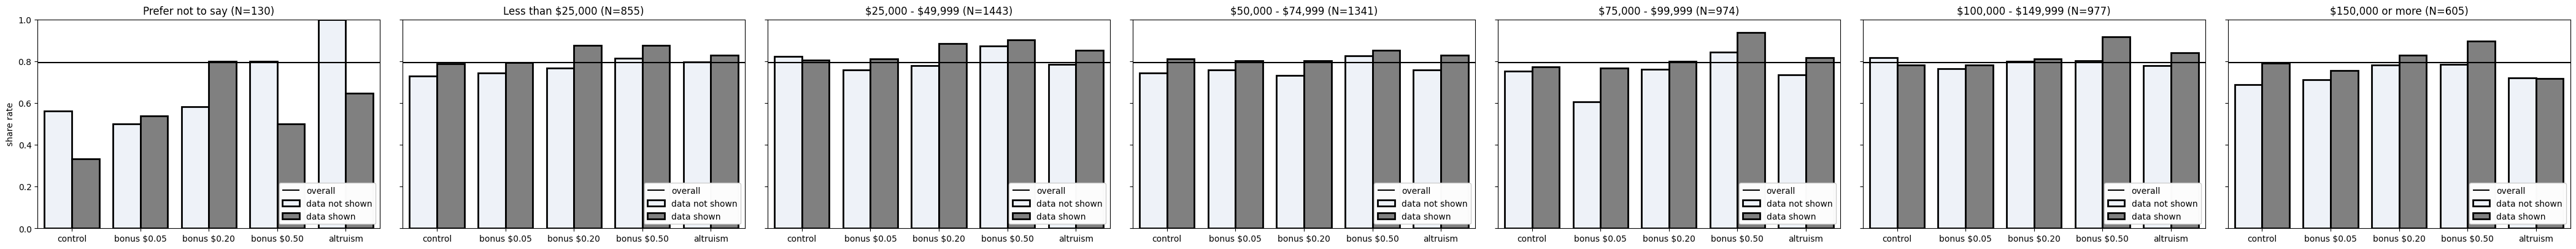

In [94]:
figsize=(6,4)
fig,axes = plt.subplots(1,7,figsize=(figsize[0]*7,figsize[1]), sharey=True)
plt.tight_layout()
for i, income in enumerate(income_order):
    demo_df = df[df[Q]==income]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (income, len(demo_df)))

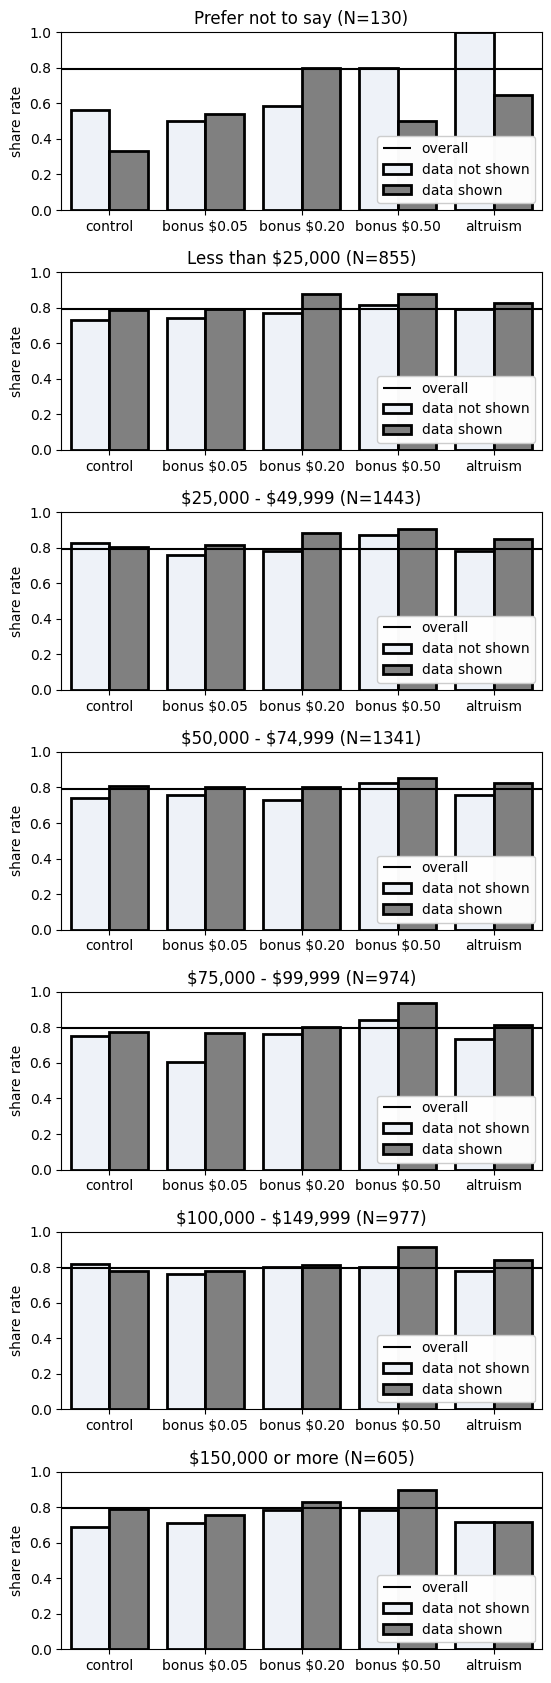

In [95]:
figsize=(6.2,3)
fig,axes = plt.subplots(7,1,figsize=(figsize[0],figsize[1]*7))
plt.subplots_adjust(hspace=0.35)
for i, income in enumerate(income_order):
    demo_df = df[df[Q]==income]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (income, len(demo_df)))

In [96]:
# Logistic reggressions to test for differences
formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
for i, income in enumerate(income_order):
    print('------- Income group: %s -------' % income)
    print(formula)
    demo_df = df[df[Q]==income]
    model = smf.logit(formula=formula, data=demo_df).fit()
    display(model.summary2())
    display(get_predictors_table(model))

------- Income group: Prefer not to say -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.641577
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.055   
Dependent Variable:               share                         AIC:                           178.8100
Date:                             2023-06-12 22:43              BIC:                           196.0152
No. Observations:                 130                           Log-Likelihood:                -83.405 
Df Model:                         5                             LL-Null:                       -88.239 
Df Residuals:                     124                           LLR p-value:                   0.085232
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   5.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.0855   0.4013  0.2130 0.8314 -0.7010 0.8719
C(incentive, Treatment(reference='control'))[T.altruism]  1.4309   0.6020  2.3768 0.0175  0.2509 2.6108
C(incentive, Treatment(reference='control'))[T.bonus-05]  0.2390   0.5055  0.4728 0.6364 -0.7518 1.2299
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.7128   0.6244  1.1416 0.2536 -0.5110 1.9366
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.9315   0.5571  1.6721 0.0945 -0.1603 2.0234
showdata[T.True]                                         -0.6181   0.3849 -1.6059 0.1083 -1.3724 0.1363
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.085,1.089,"[0.496, 2.391]",0.831
"C(incentive, Treatment(reference='control'))[T.altruism]",1.431*,4.182,"[1.285, 13.610]",0.017
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.239,1.270,"[0.471, 3.421]",0.636
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.713,2.040,"[0.600, 6.935]",0.254
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.932,2.538,"[0.852, 7.564]",0.094
showdata[T.True],-0.618,0.539,"[0.254, 1.146]",0.108


------- Income group: Less than \$25,000 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.492632
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: Logit
=====================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.012   
Dependent Variable:               share                        AIC:                          854.4000
Date:                             2023-06-12 22:43             BIC:                          882.9066
No. Observations:                 855                          Log-Likelihood:               -421.20 
Df Model:                         5                            LL-Null:                      -426.45 
Df Residuals:                     849                          LLR p-value:                  0.062051
Converged:                        1.0000                       Scale:                        1.0000  
No. Iterations:                   6.0000                                                             
-----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                0.9476   0.2067 4.5850 0.0000  0.5425 1.3527
C(incentive, Treatment(reference='control'))[T.altruism] 0.3298   0.2718 1.2136 0.2249 -0.2028 0.8624
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.0688   0.2605 0.2643 0.7916 -0.4417 0.5793
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.3816   0.2714 1.4057 0.1598 -0.1504 0.9136
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.5626   0.2785 2.0204 0.0433  0.0168 1.1083
showdata[T.True]                                         0.3940   0.1744 2.2591 0.0239  0.0522 0.7359
=====================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.948***,2.580,"[1.720, 3.868]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.33,1.391,"[0.816, 2.369]",0.225
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.069,1.071,"[0.643, 1.785]",0.792
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.382,1.465,"[0.860, 2.493]",0.160
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.563*,1.755,"[1.017, 3.029]",0.043
showdata[T.True],0.394*,1.483,"[1.054, 2.087]",0.024


------- Income group: \$25,000 - \$49,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.457193
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.013    
Dependent Variable:              share                         AIC:                           1331.4578
Date:                            2023-06-12 22:43              BIC:                           1363.1047
No. Observations:                1443                          Log-Likelihood:                -659.73  
Df Model:                        5                             LL-Null:                       -668.34  
Df Residuals:                    1437                          LLR p-value:                   0.0040884
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  6.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.3157   0.1634  8.0536 0.0000  0.9955 1.6359
C(incentive, Treatment(reference='control'))[T.altruism]  0.0179   0.2117  0.0845 0.9326 -0.3970 0.4328
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1841   0.2094 -0.8794 0.3792 -0.5945 0.2263
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1012   0.2171  0.4661 0.6411 -0.3243 0.5267
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.5953   0.2437  2.4427 0.0146  0.1176 1.0730
showdata[T.True]                                          0.3413   0.1408  2.4233 0.0154  0.0653 0.6173
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.316***,3.727,"[2.706, 5.134]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.018,1.018,"[0.672, 1.542]",0.933
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.184,0.832,"[0.552, 1.254]",0.379
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.101,1.106,"[0.723, 1.693]",0.641
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.595*,1.814,"[1.125, 2.924]",0.015
showdata[T.True],0.341*,1.407,"[1.067, 1.854]",0.015


------- Income group: \$50,000 - \$74,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.507915
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.009    
Dependent Variable:              share                         AIC:                           1374.2267
Date:                            2023-06-12 22:43              BIC:                           1405.4338
No. Observations:                1341                          Log-Likelihood:                -681.11  
Df Model:                        5                             LL-Null:                       -687.08  
Df Residuals:                    1335                          LLR p-value:                   0.035800 
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  6.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.0821   0.1603  6.7488 0.0000  0.7678 1.3964
C(incentive, Treatment(reference='control'))[T.altruism]  0.1010   0.2070  0.4879 0.6256 -0.3047 0.5067
C(incentive, Treatment(reference='control'))[T.bonus-05]  0.0208   0.2121  0.0979 0.9220 -0.3950 0.4365
C(incentive, Treatment(reference='control'))[T.bonus-20] -0.0519   0.2112 -0.2457 0.8059 -0.4658 0.3621
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4107   0.2226  1.8447 0.0651 -0.0257 0.8470
showdata[T.True]                                          0.3367   0.1360  2.4764 0.0133  0.0702 0.6031
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.082***,2.951,"[2.155, 4.040]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.101,1.106,"[0.737, 1.660]",0.626
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.021,1.021,"[0.674, 1.547]",0.922
"C(incentive, Treatment(reference='control'))[T.bonus-20]",-0.052,0.949,"[0.628, 1.436]",0.806
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.411,1.508,"[0.975, 2.333]",0.065
showdata[T.True],0.337*,1.400,"[1.073, 1.828]",0.013


------- Income group: \$75,000 - \$99,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.508849
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.036     
Dependent Variable:               share                        AIC:                          1003.2375 
Date:                             2023-06-12 22:43             BIC:                          1032.5260 
No. Observations:                 974                          Log-Likelihood:               -495.62   
Df Model:                         5                            LL-Null:                      -514.12   
Df Residuals:                     968                          LLR p-value:                  5.9932e-07
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.9538   0.1791  5.3260 0.0000  0.6028 1.3047
C(incentive, Treatment(reference='control'))[T.altruism]  0.0665   0.2408  0.2762 0.7824 -0.4055 0.5385
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.4125   0.2300 -1.7934 0.0729 -0.8634 0.0383
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1024   0.2401  0.4263 0.6699 -0.3683 0.5730
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.9288   0.2808  3.3081 0.0009  0.3785 1.4791
showdata[T.True]                                          0.4719   0.1599  2.9515 0.0032  0.1585 0.7852
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.954***,2.595,"[1.827, 3.687]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.067,1.069,"[0.667, 1.714]",0.782
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.413,0.662,"[0.422, 1.039]",0.073
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.102,1.108,"[0.692, 1.774]",0.670
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.929**,2.532,"[1.460, 4.389]",0.001
showdata[T.True],0.472**,1.603,"[1.172, 2.193]",0.003


------- Income group: \$100,000 - \$149,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.488156
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.006   
Dependent Variable:               share                         AIC:                           965.8571
Date:                             2023-06-12 22:43              BIC:                           995.1640
No. Observations:                 977                           Log-Likelihood:                -476.93 
Df Model:                         5                             LL-Null:                       -479.89 
Df Residuals:                     971                           LLR p-value:                   0.31403 
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.2670   0.1910  6.6340 0.0000  0.8927 1.6413
C(incentive, Treatment(reference='control'))[T.altruism]  0.0773   0.2556  0.3026 0.7622 -0.4235 0.5782
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1460   0.2411 -0.6055 0.5449 -0.6185 0.3265
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.0621   0.2470  0.2514 0.8015 -0.4221 0.5463
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4171   0.2740  1.5219 0.1280 -0.1200 0.9541
showdata[T.True]                                          0.1978   0.1629  1.2147 0.2245 -0.1214 0.5170
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.267***,3.550,"[2.442, 5.162]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.077,1.080,"[0.655, 1.783]",0.762
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.146,0.864,"[0.539, 1.386]",0.545
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.062,1.064,"[0.656, 1.727]",0.802
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.417,1.517,"[0.887, 2.596]",0.128
showdata[T.True],0.198,1.219,"[0.886, 1.677]",0.224


------- Income group: \$150,000 or more -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.537824
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.017   
Dependent Variable:               share                         AIC:                           662.7670
Date:                             2023-06-12 22:43              BIC:                           689.1983
No. Observations:                 605                           Log-Likelihood:                -325.38 
Df Model:                         5                             LL-Null:                       -330.85 
Df Residuals:                     599                           LLR p-value:                   0.052909
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.8803   0.2213  3.9773 0.0001  0.4465 1.3141
C(incentive, Treatment(reference='control'))[T.altruism] -0.1191   0.2834 -0.4203 0.6743 -0.6745 0.4363
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.0227   0.2820 -0.0805 0.9358 -0.5753 0.5299
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.3785   0.3130  1.2095 0.2265 -0.2349 0.9920
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.6498   0.3398  1.9123 0.0558 -0.0162 1.3159
showdata[T.True]                                          0.3297   0.1941  1.6991 0.0893 -0.0506 0.7101
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.88***,2.412,"[1.563, 3.722]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",-0.119,0.888,"[0.509, 1.547]",0.674
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.023,0.978,"[0.563, 1.699]",0.936
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.379,1.460,"[0.791, 2.697]",0.226
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.65,1.915,"[0.984, 3.728]",0.056
showdata[T.True],0.33,1.391,"[0.951, 2.034]",0.089


Income group: Prefer not to say
- Altruism incentive had statistically significant positive impact on sharing (not the case for other groups)
- Other incentives: no significant difference

For higher income groups: $100k +
- Showdata had no significant effect
- Bonuses had no significant effect

Overall difficult to draw clear conclusions about the relationship between income group and incentives

### By age group

Overall

What is your age group?


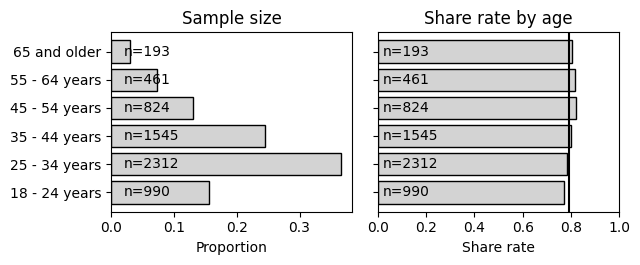

,age,n,share rate
0,18 - 24 years,990,0.773
1,25 - 34 years,2312,0.784
2,35 - 44 years,1545,0.801
3,45 - 54 years,824,0.820
4,55 - 64 years,461,0.818
5,65 and older,193,0.803


In [97]:
Q = 'q-demos-age'
print(fields_df.loc[Q][0])
age_df = df[Q].value_counts().rename('survey N').to_frame().sort_index()
age_df['survey proportion'] = age_df['survey N']/age_df['survey N'].sum()
figsize = (3.25, 2.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(age_df, axes[0])
axes[0].set_title('Sample size')
colname = 'age'
age_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(age_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
age_share_df

Test for interaction effects between age and experimental arms

In [98]:
print(Q)
formula = "share ~ C(age, Treatment(reference='35 - 44 years'))*showdata + C(incentive, Treatment(reference='control'))*C(age, Treatment(reference='35 - 44 years'))"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

q-demos-age
Optimization terminated successfully.
         Current function value: 0.499753
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                            Results: Logit
======================================================================================================================================================================
Model:                                                 Logit                                             Pseudo R-squared:                                  0.017     
Dependent Variable:                                    share                                             AIC:                                               6393.8700 
Date:                                                  2023-06-12 22:43                                  BIC:                                               6636.9516 
No. Observations:                                      6325                                              Log-Likelihood:                                    -3160.9   
Df Model:                                              35                                                LL-Null:                                           -3217.0   
Df Residuals:                                          6289                                              LLR p-value:                                       5.1773e-10
Converged:                                             1.0000                                            Scale:                                             1.0000    
No. Iterations:                                        6.0000                                                                                                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                               1.3063   0.1595  8.1900 0.0000  0.9937  1.6189
C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]                                                          -0.5520   0.2340 -2.3586 0.0183 -1.0106 -0.0933
C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]                                                          -0.3069   0.1993 -1.5403 0.1235 -0.6975  0.0836
C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]                                                          -0.1479   0.2555 -0.5790 0.5626 -0.6487  0.3528
C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]                                                          -0.2918   0.3157 -0.9244 0.3553 -0.9105  0.3269
C(age, Treatment(reference='35 - 44 years'))[T.65 and older]                                                            0.4171   0.5240  0.7959 0.4261 -0.6100  1.4441
showdata[T.True]                                                                                                        0.3378   0.1292  2.6142 0.0089  0.0845  0.5911
C(incentive, Treatment(reference='control'))[T.altruism]                                                               -0.1781   0.2008 -0.8870 0.3751 -0.5718  0.2155
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                               -0.3518   0.1980 -1.7763 0.0757 -0.7399  0.0364
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                               -0.1017   0.2048 -0.4963 0.6197 -0.5031  0.2998
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                                0.4420   0.2335  1.8927 0.0584 -0.0157  0.8997
C(age, Treatment(re

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.306***,3.692,"[2.701, 5.048]",0.000
"C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]",-0.552*,0.576,"[0.364, 0.911]",0.018
"C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]",-0.307,0.736,"[0.498, 1.087]",0.123
"C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]",-0.148,0.863,"[0.523, 1.423]",0.563
"C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]",-0.292,0.747,"[0.402, 1.387]",0.355
"C(age, Treatment(reference='35 - 44 years'))[T.65 and older]",0.417,1.518,"[0.543, 4.238]",0.426
showdata[T.True],0.338**,1.402,"[1.088, 1.806]",0.009
"C(incentive, Treatment(reference='control'))[T.altruism]",-0.178,0.837,"[0.565, 1.240]",0.375
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.352,0.703,"[0.477, 1.037]",0.076



#### Evaluate each incentive separately

q-demos-age


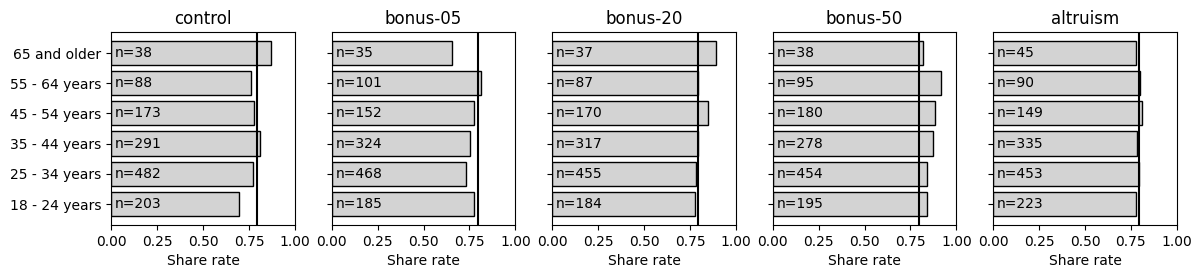

In [99]:
print(Q)
# formula = "share ~ C(age, Treatment(reference='35 - 44 years'))"
# print(formula)
figsize = (2.75, 2.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['age'] = incentive_df[Q]
#     print('------- %s -------' % incentive)
    age_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(age_share_df, colname, axes[i])
    axes[i].set_title(incentive)
#     model = smf.logit(formula=formula, data=incentive_df).fit()
#     display(model.summary2())
    #display(get_predictors_table(model))
    
plt.show()

#### Evaluating age groups separately

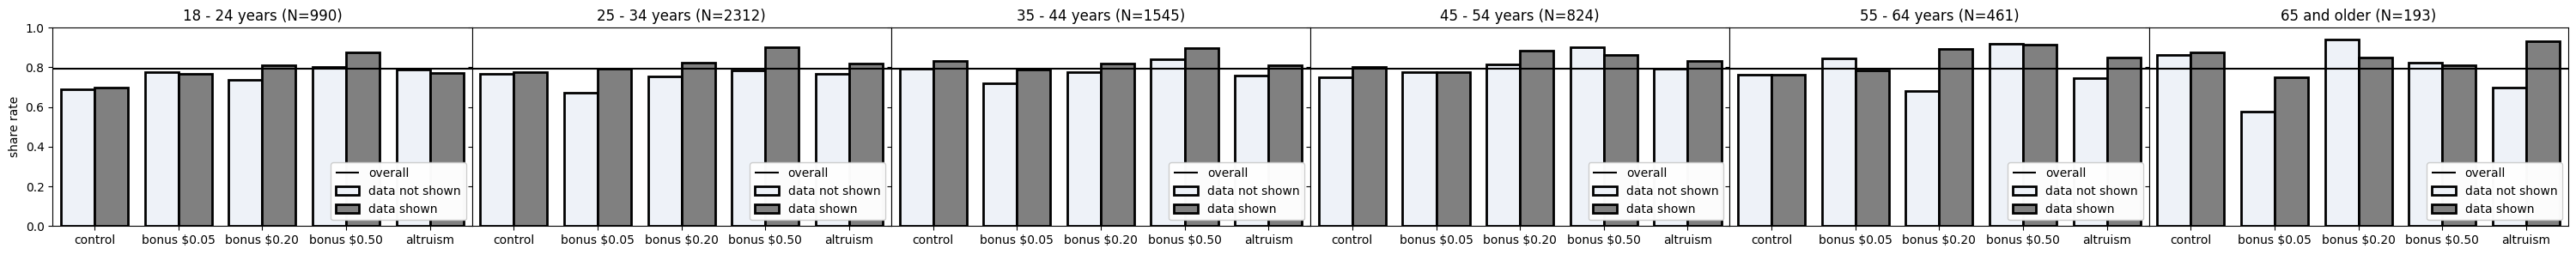

In [100]:
figsize=(6.3,3)
fig,axes = plt.subplots(1,6,figsize=(figsize[0]*6,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, age in enumerate(age_df.index.to_list()):
    demo_df = df[df[Q]==age]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (age, len(demo_df)))

### By education

In [101]:
education_order = ['Prefer not to say', 'Some high school or less', 'High school diploma or GED', 
                   "Bachelor's degree", 'Graduate or professional degree']

Overall

What is the highest level of education you have completed?


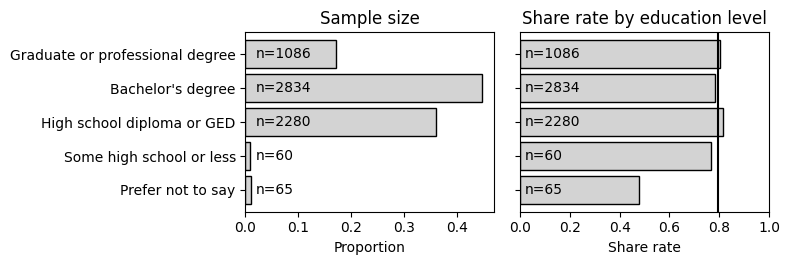

,education level,n,share rate
0,Prefer not to say,65,0.477
1,Some high school or less,60,0.767
2,High school diploma or GED,2280,0.816
3,Bachelor's degree,2834,0.781
4,Graduate or professional degree,1086,0.802


In [102]:
Q = 'Q-demos-education'
print(fields_df.loc[Q][0])
edu_df = df[Q].value_counts().rename('survey N').to_frame().loc[education_order] # sort by order defined
edu_df['survey proportion'] = edu_df['survey N']/edu_df['survey N'].sum()
figsize = (4, 2.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(edu_df, axes[0])
axes[0].set_title('Sample size')
colname = 'education level'
edu_share_df = get_share_rate_by_Q_df(Q, colname).set_index(colname).loc[education_order].reset_index()
plot_share_by_demo(edu_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
edu_share_df

#### Testing for interaction effects between education and experimental arms

In [103]:
formula = "share ~ showdata*C(edu) + C(incentive, Treatment(reference='control'))*C(edu)"
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())

share ~ showdata*C(edu) + C(incentive, Treatment(reference='control'))*C(edu)
Optimization terminated successfully.
         Current function value: 0.496644
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                 Results: Logit
=================================================================================================================================================
Model:                                          Logit                                      Pseudo R-squared:                           0.015     
Dependent Variable:                             share                                      AIC:                                        6253.9857 
Date:                                           2023-06-12 22:43                           BIC:                                        6375.3405 
No. Observations:                               6260                                       Log-Likelihood:                             -3109.0   
Df Model:                                       17                                         LL-Null:                                    -3155.9   
Df Residuals:                                   6242                                       LLR p-value:                                1.1850e-12
Converged:                                      1.0000                                     Scale:                                      1.0000    
No. Iterations:                                 6.0000                                                                                           
-------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           1.0015   0.1061  9.4396 0.0000  0.7936 1.2095
showdata[T.True]                                                                                    0.3874   0.0921  4.2041 0.0000  0.2068 0.5680
C(edu)[T.Graduate or professional degree]                                                           0.2079   0.2060  1.0094 0.3128 -0.1958 0.6117
C(edu)[T.High school or GED or less]                                                                0.1798   0.1662  1.0819 0.2793 -0.1459 0.5054
C(incentive, Treatment(reference='control'))[T.altruism]                                            0.0585   0.1407  0.4155 0.6778 -0.2173 0.3343
C(incentive, Treatment(reference='control'))[T.bonus-05]                                           -0.2109   0.1361 -1.5498 0.1212 -0.4776 0.0558
C(incentive, Treatment(reference='control'))[T.bonus-20]                                            0.1878   0.1438  1.3065 0.1914 -0.0939 0.4696
C(incentive, Treatment(reference='control'))[T.bonus-50]                                            0.4952   0.1531  3.2337 0.0012  0.1950 0.7953
showdata[T.True]:C(edu)[T.Graduate or professional degree]                                         -0.0503   0.1815 -0.2773 0.7816 -0.4061 0.3054
showdata[T.True]:C(edu)[T.High school or GED or less]                                              -0.1582   0.1415 -1.1177 0.2637 -0.4356 0.1192
C(incentive, Treatment(reference='control'))[T.altruism]:C(edu)[T.Graduate or professional degree]  0.1266   0.2776  0.4559 0.6484 -0.4176 0.6708
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(edu)[T.Graduate or professional degree] -0.0484   0.2636 -0.1837 0.8543 -0.5651 0.4682
C(incentive, Treatment(reference='control'))[T.bonus-20]:C(edu)[T.Graduate or professional degree] -0.3018   0.2800 -1.0781 0.2810 -0.8506 0.2469
C(incentive, Treatment(reference='control'))[T.bonus-50]:C(edu)[T.Graduate or professional degree] -0.0138   0.2985 -0.0463 0.9631 -0.5989 0.5712
C(incentive, Treatment(reference='control'))[T.altruism]:C(edu)[T.High scho

Model could not handle small group with odd distribution: some high school or less

So here we drop that group and run the model again.

In [104]:
formula = "share ~ showdata*C(edu) + C(incentive, Treatment(reference='control'))*C(edu)"
print(formula)
model = smf.logit(formula=formula, data=mdf[mdf['edu']!='Some high school or less']).fit()
display(model.summary2())

share ~ showdata*C(edu) + C(incentive, Treatment(reference='control'))*C(edu)
Optimization terminated successfully.
         Current function value: 0.496644
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                 Results: Logit
=================================================================================================================================================
Model:                                          Logit                                      Pseudo R-squared:                           0.015     
Dependent Variable:                             share                                      AIC:                                        6253.9857 
Date:                                           2023-06-12 22:43                           BIC:                                        6375.3405 
No. Observations:                               6260                                       Log-Likelihood:                             -3109.0   
Df Model:                                       17                                         LL-Null:                                    -3155.9   
Df Residuals:                                   6242                                       LLR p-value:                                1.1850e-12
Converged:                                      1.0000                                     Scale:                                      1.0000    
No. Iterations:                                 6.0000                                                                                           
-------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                    Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           1.0015   0.1061  9.4396 0.0000  0.7936 1.2095
showdata[T.True]                                                                                    0.3874   0.0921  4.2041 0.0000  0.2068 0.5680
C(edu)[T.Graduate or professional degree]                                                           0.2079   0.2060  1.0094 0.3128 -0.1958 0.6117
C(edu)[T.High school or GED or less]                                                                0.1798   0.1662  1.0819 0.2793 -0.1459 0.5054
C(incentive, Treatment(reference='control'))[T.altruism]                                            0.0585   0.1407  0.4155 0.6778 -0.2173 0.3343
C(incentive, Treatment(reference='control'))[T.bonus-05]                                           -0.2109   0.1361 -1.5498 0.1212 -0.4776 0.0558
C(incentive, Treatment(reference='control'))[T.bonus-20]                                            0.1878   0.1438  1.3065 0.1914 -0.0939 0.4696
C(incentive, Treatment(reference='control'))[T.bonus-50]                                            0.4952   0.1531  3.2337 0.0012  0.1950 0.7953
showdata[T.True]:C(edu)[T.Graduate or professional degree]                                         -0.0503   0.1815 -0.2773 0.7816 -0.4061 0.3054
showdata[T.True]:C(edu)[T.High school or GED or less]                                              -0.1582   0.1415 -1.1177 0.2637 -0.4356 0.1192
C(incentive, Treatment(reference='control'))[T.altruism]:C(edu)[T.Graduate or professional degree]  0.1266   0.2776  0.4559 0.6484 -0.4176 0.6708
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(edu)[T.Graduate or professional degree] -0.0484   0.2636 -0.1837 0.8543 -0.5651 0.4682
C(incentive, Treatment(reference='control'))[T.bonus-20]:C(edu)[T.Graduate or professional degree] -0.3018   0.2800 -1.0781 0.2810 -0.8506 0.2469
C(incentive, Treatment(reference='control'))[T.bonus-50]:C(edu)[T.Graduate or professional degree] -0.0138   0.2985 -0.0463 0.9631 -0.5989 0.5712
C(incentive, Treatment(reference='control'))[T.altruism]:C(edu)[T.High scho

#### Evaluate each incentive separately

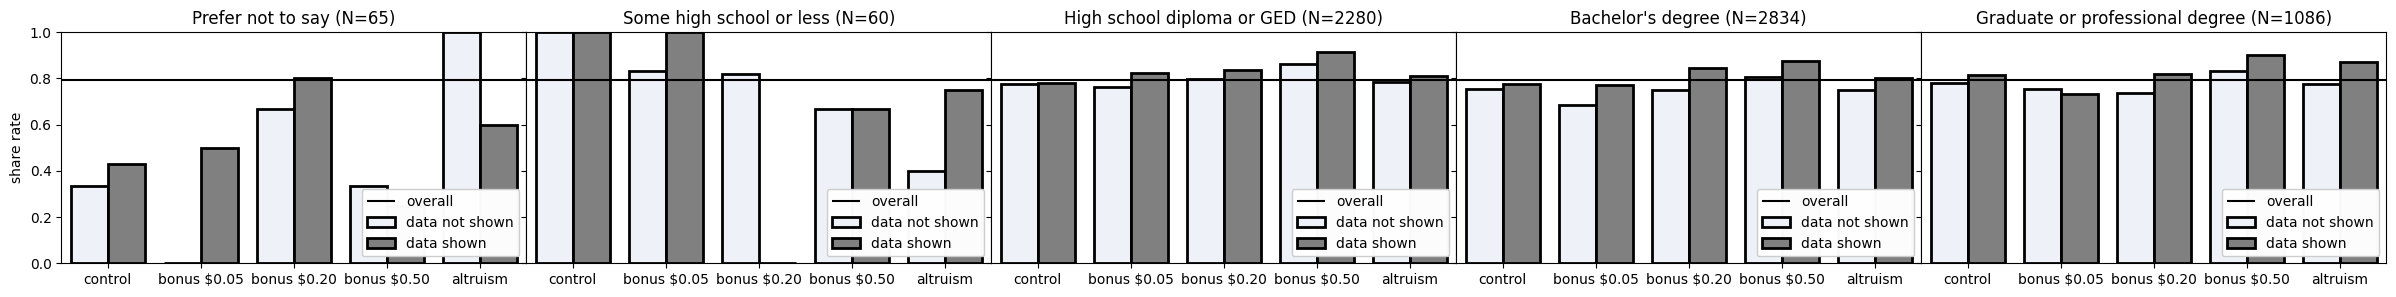

In [105]:
figsize=(6,3)
fig,axes = plt.subplots(1,5,figsize=(figsize[0]*5,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, edu in enumerate(education_order):
    demo_df = df[df[Q]==edu]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (edu, len(demo_df)))

### By sexual orientation

Overall

Which best describes your sexual orientation?


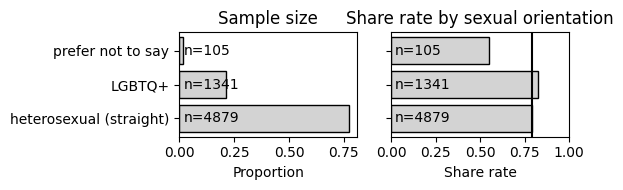

,sexual orientation,n,share rate
0,LGBTQ+,1341,0.828
1,heterosexual (straight),4879,0.790
2,prefer not to say,105,0.552


In [106]:

Q = 'Q-sexual-orientation'
print(fields_df.loc[Q][0])
so_df = df[Q].value_counts().rename('survey N').to_frame()
so_df['survey proportion'] = so_df['survey N']/so_df['survey N'].sum()
figsize = (3, 2)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(so_df, axes[0])
axes[0].set_title('Sample size')
colname = 'sexual orientation'
so_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(so_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
so_share_df

#### Testing for interaction effects between sexual orientation and experimental arms

In [107]:
formula = "share ~ showdata*C(lgbtq, Treatment(reference='heterosexual (straight)')) + C(incentive, Treatment(reference='control'))*C(lgbtq, Treatment(reference='heterosexual (straight)'))"
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())

share ~ showdata*C(lgbtq, Treatment(reference='heterosexual (straight)')) + C(incentive, Treatment(reference='control'))*C(lgbtq, Treatment(reference='heterosexual (straight)'))
Optimization terminated successfully.
         Current function value: 0.498431
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                    Results: Logit
======================================================================================================================================================================================
Model:                                                     Logit                                                   Pseudo R-squared:                                        0.020     
Dependent Variable:                                        share                                                   AIC:                                                     6341.1576 
Date:                                                      2023-06-12 22:43                                        BIC:                                                     6462.6984 
No. Observations:                                          6325                                                    Log-Likelihood:                                          -3152.6   
Df Model:                                                  17                                                      LL-Null:                                                 -3217.0   
Df Residuals:                                              6307                                                    LLR p-value:                                             3.0850e-19
Converged:                                                 1.0000                                                  Scale:                                                   1.0000    
No. Iterations:                                            6.0000                                                                                                                     
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                               1.0165   0.0820 12.3896 0.0000  0.8557  1.1773
showdata[T.True]                                                                                                                        0.3464   0.0713  4.8561 0.0000  0.2066  0.4863
C(lgbtq, Treatment(reference='heterosexual (straight)'))[T.LGBTQ+]                                                                      0.3551   0.1906  1.8632 0.0624 -0.0184  0.7287
C(lgbtq, Treatment(reference='heterosexual (straight)'))[T.prefer not to say]                                                          -1.1837   0.4771 -2.4811 0.0131 -2.1188 -0.2486
C(incentive, Treatment(reference='control'))[T.altruism]                                                                                0.1201   0.1085  1.1062 0.2687 -0.0927  0.3328
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                                               -0.1287   0.1049 -1.2274 0.2197 -0.3343  0.0768
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                                                0.2167   0.1104  1.9630 0.0496  0.0003  0.4331
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                                                0.6424   0.1204  5.3371 0.0000  0.4065  0.8783
showdata[T.True]:C(lgbtq, Treatment(reference='heterosexual (straight)'))[T.LGBTQ+]                                                    -0.0952   0.1621 -0.5873 0.5570 -0.4128  0.2224
showdata[

#### Evaluate each incentive separately

Q-sexual-orientation


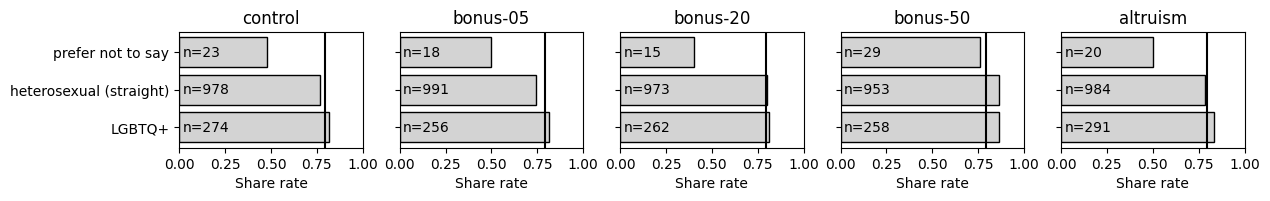

In [108]:
print(Q)
figsize = (2.75, 1.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['lgbtq'] = incentive_df[Q]
    so_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(so_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    
plt.show()

### By race and hispanic origin

Note the US census and this survey ask about hispanic/latin origin in a question separate from race.

#### Spanish, Hispanic, or Latino origin

Overall

Are you of Spanish, Hispanic, or Latino origin?


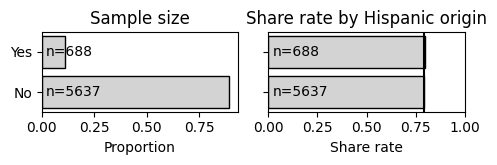

,Hispanic origin,n,share rate
0,No,5637,0.793
1,Yes,688,0.799


In [109]:
Q = 'Q-demos-hispanic'
print(fields_df.loc[Q][0])
hisp_df = df[Q].value_counts().rename('survey N').to_frame()
hisp_df['survey proportion'] = hisp_df['survey N']/hisp_df['survey N'].sum()
figsize = (2.5, 1.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(hisp_df, axes[0])
axes[0].set_title('Sample size')
colname = 'Hispanic origin'
hisp_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(hisp_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
hisp_share_df

Regression: testing for interaction effects

In [110]:
formula = "share ~ showdata*C(hispanic, Treatment(reference='No')) + C(incentive, Treatment(reference='control'))*C(hispanic, Treatment(reference='No'))"
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())

share ~ showdata*C(hispanic, Treatment(reference='No')) + C(incentive, Treatment(reference='control'))*C(hispanic, Treatment(reference='No'))
Optimization terminated successfully.
         Current function value: 0.502266
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                   Results: Logit
=====================================================================================================================================================
Model:                                          Logit                                        Pseudo R-squared:                             0.012     
Dependent Variable:                             share                                        AIC:                                          6377.6654 
Date:                                           2023-06-12 22:43                             BIC:                                          6458.6925 
No. Observations:                               6325                                         Log-Likelihood:                               -3176.8   
Df Model:                                       11                                           LL-Null:                                      -3217.0   
Df Residuals:                                   6313                                         LLR p-value:                                  1.2530e-12
Converged:                                      1.0000                                       Scale:                                        1.0000    
No. Iterations:                                 6.0000                                                                                               
-----------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               1.0736   0.0772 13.9051 0.0000  0.9223 1.2249
showdata[T.True]                                                                                        0.3221   0.0666  4.8383 0.0000  0.1916 0.4526
C(hispanic, Treatment(reference='No'))[T.Yes]                                                          -0.1055   0.2316 -0.4554 0.6488 -0.5594 0.3484
C(incentive, Treatment(reference='control'))[T.altruism]                                                0.0879   0.1017  0.8644 0.3873 -0.1114 0.2872
C(incentive, Treatment(reference='control'))[T.bonus-05]                                               -0.1059   0.0993 -1.0669 0.2860 -0.3004 0.0886
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                0.1485   0.1029  1.4436 0.1488 -0.0531 0.3501
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                0.5533   0.1111  4.9800 0.0000  0.3355 0.7710
showdata[T.True]:C(hispanic, Treatment(reference='No'))[T.Yes]                                         -0.0373   0.2048 -0.1820 0.8556 -0.4386 0.3640
C(incentive, Treatment(reference='control'))[T.altruism]:C(hispanic, Treatment(reference='No'))[T.Yes]  0.2961   0.3024  0.9789 0.3276 -0.2967 0.8888
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(hispanic, Treatment(reference='No'))[T.Yes]  0.0286   0.2929  0.0978 0.9221 -0.5454 0.6027
C(incentive, Treatment(reference='control'))[T.bonus-20]:C(hispanic, Treatment(reference='No'))[T.Yes]  0.1919   0.3168  0.6058 0.5447 -0.4290 0.8127
C(incentive, Treatment(reference='control'))[T.bonus-50]:C(hispanic, Treatment(reference='No'))[T.Yes]  0.4301   0.3616  1.1893 0.2343 -0.2787 1.1389
=====================================================================================================================================================

"""

#### Evaluate each incentive separately

Q-demos-hispanic


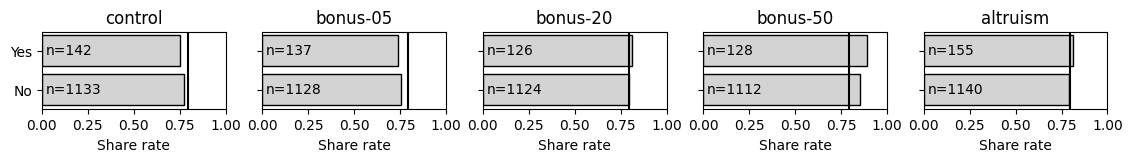

In [111]:
print(Q)
figsize = (2.75, 1)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['hispanic'] = incentive_df[Q]
    hisp_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(hisp_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    
plt.show()

#### Evaluating Hispanic vs non-Hispanic groups separately

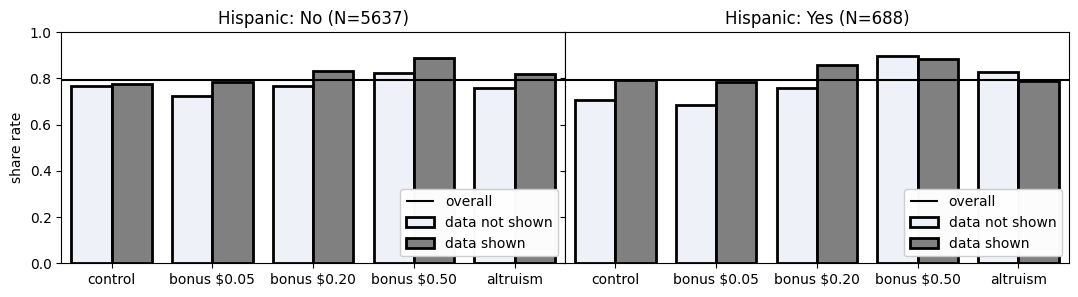

In [112]:
figsize=(6.5,3)
fig,axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, hisp in enumerate(hisp_df.index.to_list()):
    demo_df = df[df[Q]==hisp]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('Hispanic: %s (N=%s)' % (hisp, len(demo_df)))

### Race

In [113]:
Q = 'Q-demos-race'
print(fields_df.loc[Q][0])
race_df = df[Q].value_counts().rename('survey N').to_frame()
race_df['survey proportion'] = round(race_df['survey N']/race_df['survey N'].sum(), 3)
race_df.head(10)

Choose one or more races that you consider yourself to be


,survey N,survey proportion
Q-demos-race,,
White or Caucasian,4825,0.763
Asian,551,0.087
Black or African American,440,0.070
Other,134,0.021
"White or Caucasian,Asian",96,0.015
"White or Caucasian,Black or African American",72,0.011
"White or Caucasian,American Indian/Native American or Alaska Native",66,0.010
American Indian/Native American or Alaska Native,38,0.006
"White or Caucasian,Other",32,0.005


For simplicity we aggregate 'Other' + anyone who answered 2 more more races + anyone with 'American Indian'

Including 'American Indian' in this aggregation because otherwise this group is too small.

Note this is very simplifying.

In [114]:
df['race'] = df[Q].apply(lambda r: 'Other or 2 or more races' if ((len(r.split(',')) > 1) or ('Other' in r) or ('American Indian' in r)) else r)
race_df = df['race'].value_counts().rename('survey N').to_frame()
race_df['survey proportion'] = round(race_df['survey N']/race_df['survey N'].sum(), 3)
race_df.head(10)

,survey N,survey proportion
race,,
White or Caucasian,4825,0.763
Asian,551,0.087
Other or 2 or more races,509,0.080
Black or African American,440,0.070


Overall

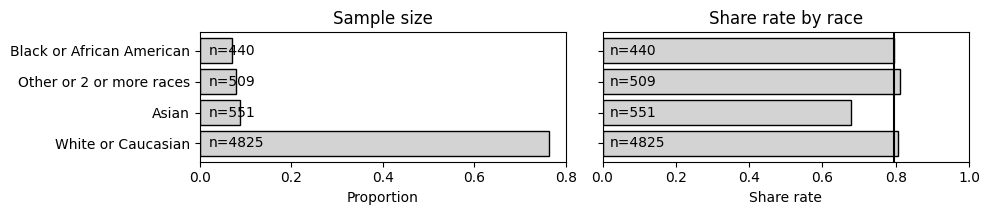

,race,n,share rate
0,Asian,551,0.679
1,Black or African American,440,0.795
2,Other or 2 or more races,509,0.811
3,White or Caucasian,4825,0.805


In [115]:
figsize = (5, 2.25)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(race_df, axes[0])
axes[0].set_title('Sample size')
colname = 'race'
race_share_df = get_share_rate_by_Q_df('race', colname)
plot_share_by_demo(race_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
race_share_df

Test for interaction effects between race and experimental arms

In [116]:
print(Q)
formula = "share ~ showdata*C(race, Treatment(reference='White')) + C(incentive, Treatment(reference='control'))*C(race, Treatment(reference='White'))"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
# display(get_predictors_table(model))

Q-demos-race
Optimization terminated successfully.
         Current function value: 0.497734
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                         Results: Logit
================================================================================================================================================================
Model:                                               Logit                                           Pseudo R-squared:                                0.021     
Dependent Variable:                                  share                                           AIC:                                             6344.3351 
Date:                                                2023-06-12 22:43                                BIC:                                             6506.3895 
No. Observations:                                    6325                                            Log-Likelihood:                                  -3148.2   
Df Model:                                            23                                              LL-Null:                                         -3217.0   
Df Residuals:                                        6301                                            LLR p-value:                                     2.4678e-18
Converged:                                           1.0000                                          Scale:                                           1.0000    
No. Iterations:                                      6.0000                                                                                                     
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                  Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                         1.1251   0.0851 13.2249 0.0000  0.9583  1.2918
showdata[T.True]                                                                                                  0.3238   0.0737  4.3954 0.0000  0.1794  0.4682
C(race, Treatment(reference='White'))[T.Asian]                                                                   -0.6749   0.2317 -2.9131 0.0036 -1.1290 -0.2208
C(race, Treatment(reference='White'))[T.Black]                                                                    0.0255   0.2895  0.0880 0.9299 -0.5419  0.5929
C(race, Treatment(reference='White'))[T.Other or mixed]                                                           0.0691   0.2778  0.2489 0.8035 -0.4754  0.6137
C(incentive, Treatment(reference='control'))[T.altruism]                                                          0.1241   0.1121  1.1072 0.2682 -0.0956  0.3438
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                         -0.1403   0.1080 -1.2989 0.1940 -0.3521  0.0714
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                          0.2003   0.1142  1.7533 0.0795 -0.0236  0.4241
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                          0.6607   0.1263  5.2316 0.0000  0.4132  0.9082
showdata[T.True]:C(race, Treatment(reference='White'))[T.Asian]                                                   0.0446   0.1996  0.2236 0.8231 -0.3466  0.4358
showdata[T.True]:C(race, Treatment(reference='White'))[T.Black]                                                   0.0417   0.2502  0.1665 0.8677 -0.4486  0.5319
showdata[T.True]:C(race, Treatment(reference='White'))[T.Other or mixed]                                         -0.1494   0.2421 -0.6173 0.5370 -0.6239  0.3250

#### Evaluate each incentive separately

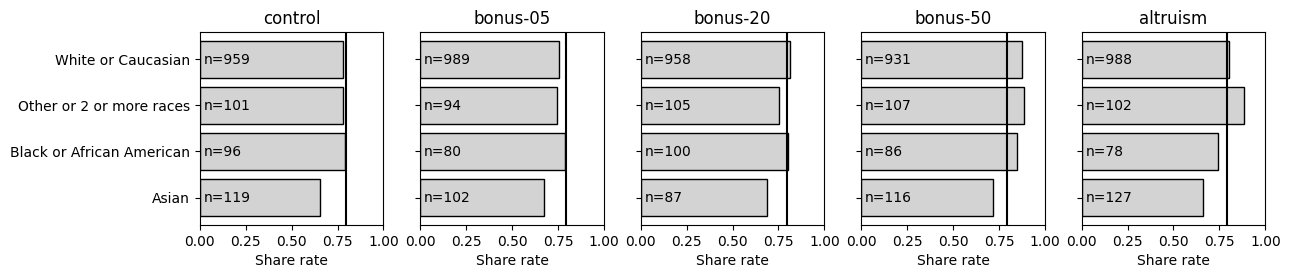

In [117]:
# formula = "share ~ C(race, Treatment(reference='White or Caucasian'))"
# print(formula)
figsize = (2.75, 2.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
#     print('------- %s -------' % incentive)
    race_share_df = get_share_rate_by_Q_df('race', colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(race_share_df, colname, axes[i])
    axes[i].set_title(incentive)
#     model = smf.logit(formula=formula, data=incentive_df).fit()
#     display(model.summary2())
    #display(get_predictors_table(model))
    
plt.show()

#### Evaluating by racial groups separately

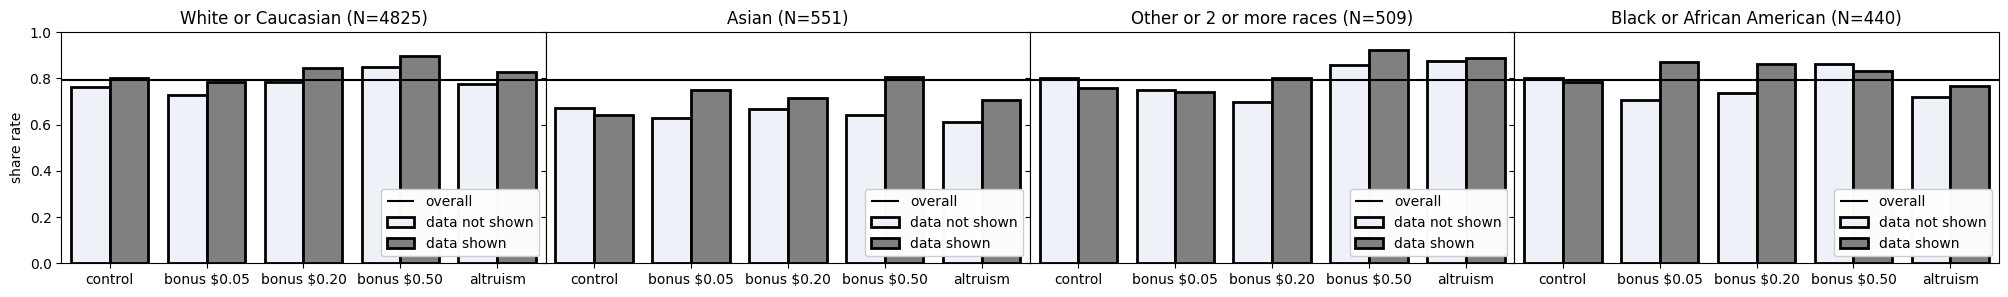

In [118]:
figsize=(5,3)
fig,axes = plt.subplots(1,4,figsize=(figsize[0]*5,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, race in enumerate(race_df.index.to_list()):
    demo_df = df[df['race']==race]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (race.split('/')[0], len(demo_df)))

In [119]:
# # Logistic reggressions to test for differences
# formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
# for i, race in enumerate(race_df.index.to_list()):
#     if 'American Indian' in race: # Group too small
#         continue
#     print('------- race group: %s -------' % race)
#     print(formula)
#     demo_df = df[df['race']==race]
#     model = smf.logit(formula=formula, data=demo_df).fit()
#     display(model.summary2())
#     #display(get_predictors_table(model))

### By purchase frequency

How often do you (+ anyone you share your account with) order deliveries from Amazon?


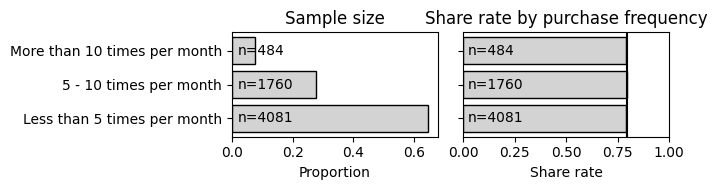

,purchase frequency,n,share rate
0,5 - 10 times per month,1760,0.798
1,Less than 5 times per month,4081,0.793
2,More than 10 times per month,484,0.789


In [120]:
Q = 'Q-amazon-use-how-oft'
print(fields_df.loc[Q][0])
pf_df = df[Q].value_counts().rename('survey N').to_frame()
pf_df['survey proportion'] = pf_df['survey N']/pf_df['survey N'].sum()
figsize = (3.5, 2)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(pf_df, axes[0])
axes[0].set_title('Sample size')
colname = 'purchase frequency'
pf_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(pf_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
pf_share_df

#### Evaluate each incentive separately

Q-amazon-use-how-oft


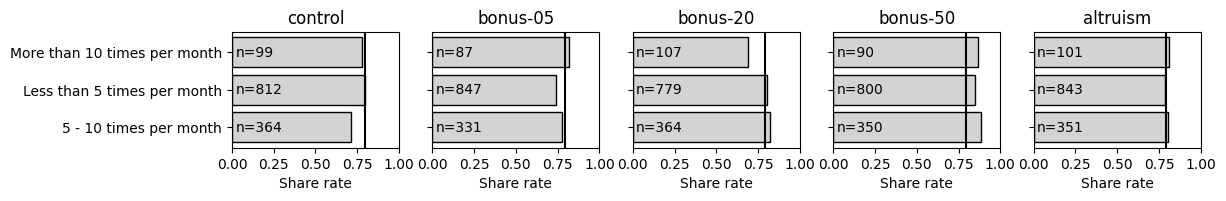

In [121]:
print(Q)
# formula = "share ~ C(frequency)"
# print(formula)
figsize = (2.5, 1.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['frequency'] = incentive_df[Q]
#     print('------- %s -------' % incentive)
    pf_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(pf_share_df, colname, axes[i])
    axes[i].set_title(incentive)
#     model = smf.logit(formula=formula, data=incentive_df).fit()
#     display(model.summary2())
#     if incentive == 'control':
#         display(get_predictors_table(model))  
plt.show()

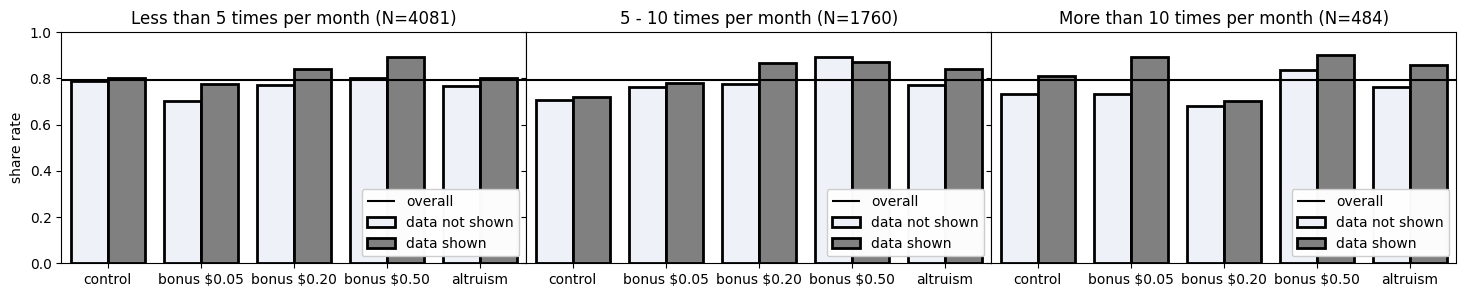

In [122]:
figsize=(6,3)
fig,axes = plt.subplots(1,3,figsize=(figsize[0]*3,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, pf in enumerate(pf_df.index.to_list()):
    demo_df = df[df[Q]==pf]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (pf, len(demo_df)))

Test for interaction effects

In [123]:
print(Q)
print(fields_df.loc[Q][0],'\n')
formula = "share ~ showdata*C(frequency) + C(incentive, Treatment(reference='control'))*C(frequency)"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

Q-amazon-use-how-oft
How often do you (+ anyone you share your account with) order deliveries from Amazon? 

Optimization terminated successfully.
         Current function value: 0.500348
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                   Results: Logit
=====================================================================================================================================================
Model:                                          Logit                                        Pseudo R-squared:                             0.016     
Dependent Variable:                             share                                        AIC:                                          6365.3998 
Date:                                           2023-06-12 22:43                             BIC:                                          6486.9406 
No. Observations:                               6325                                         Log-Likelihood:                               -3164.7   
Df Model:                                       17                                           LL-Null:                                      -3217.0   
Df Residuals:                                   6307                                         LLR p-value:                                  1.2232e-14
Converged:                                      1.0000                                       Scale:                                        1.0000    
No. Iterations:                                 6.0000                                                                                               
-----------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              0.8091   0.1298  6.2346 0.0000  0.5548  1.0635
showdata[T.True]                                                                                       0.2182   0.1207  1.8073 0.0707 -0.0184  0.4548
C(frequency)[T.Less than 5 times per month]                                                            0.3891   0.1601  2.4301 0.0151  0.0753  0.7029
C(frequency)[T.More than 10 times per month]                                                           0.1653   0.2999  0.5513 0.5814 -0.4225  0.7531
C(incentive, Treatment(reference='control'))[T.altruism]                                               0.5003   0.1778  2.8146 0.0049  0.1519  0.8487
C(incentive, Treatment(reference='control'))[T.bonus-05]                                               0.3130   0.1754  1.7845 0.0743 -0.0308  0.6568
C(incentive, Treatment(reference='control'))[T.bonus-20]                                               0.6002   0.1791  3.3516 0.0008  0.2492  0.9511
C(incentive, Treatment(reference='control'))[T.bonus-50]                                               1.1123   0.2030  5.4805 0.0000  0.7145  1.5101
showdata[T.True]:C(frequency)[T.Less than 5 times per month]                                           0.1275   0.1439  0.8859 0.3756 -0.1545  0.4094
showdata[T.True]:C(frequency)[T.More than 10 times per month]                                          0.2860   0.2584  1.1067 0.2684 -0.2205  0.7925
C(incentive, Treatment(reference='control'))[T.altruism]:C(frequency)[T.Less than 5 times per month]  -0.5758   0.2151 -2.6773 0.0074 -0.9973 -0.1543
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(frequency)[T.Less than 5 times per month]  -0.6413   0.2110 -3.0399 0.0024 -1.0547 -0.2278
C(incentive, Treatment(reference='control'))[T.bonus-20]:C(frequency)[T.Less than 5 times per month]  -0.5468   0.2187 -2.4998 0.0124 -0.9755 -0.1181
C(incentive, Treatment(reference='control'))[T.bonus-50]:C(frequency)[T.Less than 5 times per month]  -0.7622   0.2419 

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.809***,2.246,"[1.742, 2.897]",0.000
showdata[T.True],0.218,1.244,"[0.982, 1.576]",0.071
C(frequency)[T.Less than 5 times per month],0.389*,1.476,"[1.078, 2.020]",0.015
C(frequency)[T.More than 10 times per month],0.165,1.180,"[0.655, 2.124]",0.581
"C(incentive, Treatment(reference='control'))[T.altruism]",0.5**,1.649,"[1.164, 2.337]",0.005
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.313,1.368,"[0.970, 1.929]",0.074
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.6**,1.822,"[1.283, 2.589]",0.001
"C(incentive, Treatment(reference='control'))[T.bonus-50]",1.112***,3.041,"[2.043, 4.527]",0.000
showdata[T.True]:C(frequency)[T.Less than 5 times per month],0.127,1.136,"[0.857, 1.506]",0.376


## Monetary value of data: Real vs hypothetical impact of bonus incentive

On average, how does the hypothetical amount of money participants say they would accept in exchange for their data compare to the amount that participants do accept as bonus payment for their data, when presented with the real opportunity? 

Given our results were only significant from control at the bonus:$0.50 level, we focus on this.


#### Analysis method 1:


Measure the difference between


Real share rate increase due to $0.50 bonus
- = (bonus50_share_rate_real - control_share_rate)

vs

Hypothetical share rate increase due to \\$0.50 bonus 




Measure real share rate increase as 
(bonus50_share_rate_real - control_share_rate)

Where: 
- *control_share_rate*: share rate in the control arm (portion shared with no extra bonus incentive)
- *bonus50_share_rate_real* share rate for the bonus:0.50 incentive arm
    - We interpret this as the portion of people who would share data for a (real) bonus amount of 0.50 or less


Measure hypothetical share rate increase as:
portion of participants in the control arm who did not share their data but answered yes
they would hypothetically share their data for a bonus payment of 0.50 or less. 

i.e. for hypotehtical share rate increase:
- restrict data to participants in control arm AND answered no share
- measure rate they answered they would hypothetically share for any of \\$0.05, \\$0.20, \\$0.50


We also compute these measures for each bonus amount and make plots.

Done for showdata=True/False separately.


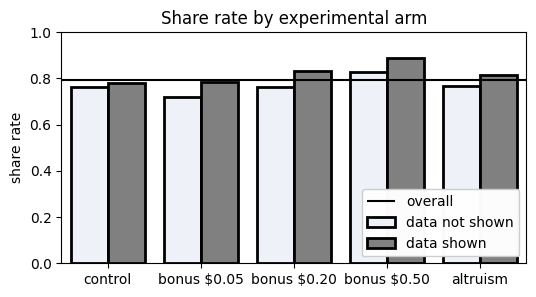

,incentive,showdata,n,share rate
0,control,False,636,0.763
1,control,True,639,0.779
2,bonus-05,False,647,0.720
3,bonus-05,True,618,0.785
4,bonus-20,False,648,0.765
5,bonus-20,True,602,0.834
6,bonus-50,False,624,0.830
7,bonus-50,True,616,0.888
8,altruism,False,653,0.767
9,altruism,True,642,0.816


In [124]:
fig,ax = plt.subplots(1,1, figsize=(6,3))#, dpi=300)
ax.set_title('Share rate by experimental arm')
plot_share_rate(agg_share_df, ax)
plt.show()
agg_share_df

Compute "real" share rate increases using share rate (`mean`) above.

For showdata=True/False separately. And overall.

In [127]:
def get_share_rate_change(agg_df):
    sdf = (agg_df.set_index('incentive')
           .loc[['control','bonus-05','bonus-20','bonus-50']])['share rate'].rename(
        {'control':'$0', 'bonus-05':'$0.05', 'bonus-20':'$0.20', 'bonus-50':'$0.50'}
    )
    return sdf - sdf.loc['$0']

print('share rate change for showdata=True:')
real_share_rate_change_showdata_true = get_share_rate_change(agg_share_df[agg_share_df['showdata']==True])
print(real_share_rate_change_showdata_true)

print('\nshare rate change for showdata=False:')
real_share_rate_change_showdata_false = get_share_rate_change(agg_share_df[agg_share_df['showdata']==False])
print(real_share_rate_change_showdata_false)

share rate change for showdata=True:
incentive
$0       0.000
$0.05    0.006
$0.20    0.055
$0.50    0.109
Name: share rate, dtype: float64

share rate change for showdata=False:
incentive
$0       0.000
$0.05   -0.043
$0.20    0.002
$0.50    0.067
Name: share rate, dtype: float64


Compute hypothetical share rate increases.


Compute new tables, separately for showdata=True/False with the following
- restrict data to participants in control arm who answered no share
- restrict data to showdata=True/False
- this provides the 'total count'
- `share count`: count the number of answers for yes: hypothetically share for each hypothetical bonus
- `cumulative share count`: cumulative sum of share count
- `cumulative share rate`: `cumulative share count` / `total count` : represents increase in portino of people who would not share for \\$0 but would share for `amount` or less

Resulting table:

```
amount, total count, share count, cumulative share count, cumulative share rate
```

In [128]:
# data value Qs
hypo_bonus_Qs = [
    'Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 
    'Q-data-value-100', 'Q-data-value-any', 'Q-data-value-any_1_TEXT'
]
# setting up hypo share df with all incentives first to reuse later for alternative method
hypo_shares_all_incentives = df[df['share']==0][['incentive', 'share', 'showdata']+hypo_bonus_Qs].fillna(0)

print(len(hypo_shares_all_incentives))

# Map the No/yes data value questions to 0/1
for col in ['Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 'Q-data-value-100', 'Q-data-value-any']:
    hypo_shares_all_incentives[col] = hypo_shares_all_incentives[col].apply(lambda v: 0 if (v=='No' or v==0) else 1)
hypo_shares_all_incentives.head(3)

1303


,incentive,share,showdata,Q-data-value-05,Q-data-value-20,Q-data-value-50,Q-data-value-100,Q-data-value-any,Q-data-value-any_1_TEXT
1,bonus-05,0,False,0,0,0,1,0,0
8,control,0,False,0,0,0,0,1,1000.00
10,bonus-50,0,False,0,0,0,0,1,10


In [129]:
hypo_share_df = hypo_shares_all_incentives[hypo_shares_all_incentives['incentive']=='control']
print(len(hypo_share_df))
hypo_share_df.head()

292


,incentive,share,showdata,Q-data-value-05,Q-data-value-20,Q-data-value-50,Q-data-value-100,Q-data-value-any,Q-data-value-any_1_TEXT
8,control,0,False,0,0,0,0,1,1000.00
39,control,0,True,0,0,0,0,1,30.00
76,control,0,True,0,0,0,0,1,50
99,control,0,False,0,1,0,0,0,0
146,control,0,True,0,0,1,0,0,0


In [130]:
def get_hypo_share_rate_change(hypo_share_df):
#     s = hypo_share_df[(hypo_share_df['showdata']==False)][[
    s = hypo_share_df[[
        'share',
        'Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 
        'Q-data-value-100', 'Q-data-value-any'
    ]]
    total_count = len(s)
    # rename columns to represent amounts offered
    s.columns=['$0','$0.05','$0.20','$0.50','$1.00','> $1.00']
    s = s.apply(sum).to_frame(name='share count')
    s.index.names = ['amount']
    s['total count'] = total_count
    s['cumulative count'] = s['share count'].cumsum()
    s['cumulative share rate'] = (
        s['cumulative count']/s['total count']
    ).round(3)
    return s

hypo_share_rate_change_overall = get_hypo_share_rate_change(hypo_share_df)
hypo_share_rate_change_overall

,share count,total count,cumulative count,cumulative share rate
amount,,,,
$0,0,292,0,0.000
$0.05,29,292,29,0.099
$0.20,5,292,34,0.116
$0.50,10,292,44,0.151
$1.00,26,292,70,0.240
> $1.00,221,292,291,0.997


In [131]:
hypo_share_rate_change_showdata_false = get_hypo_share_rate_change(hypo_share_df[hypo_share_df['showdata']==False])
print('hypothetical increase in share rate for showdata: False')
hypo_share_rate_change_showdata_false

hypothetical increase in share rate for showdata: False


,share count,total count,cumulative count,cumulative share rate
amount,,,,
$0,0,151,0,0.000
$0.05,12,151,12,0.079
$0.20,2,151,14,0.093
$0.50,5,151,19,0.126
$1.00,16,151,35,0.232
> $1.00,115,151,150,0.993


In [132]:
hypo_share_rate_change_showdata_true = get_hypo_share_rate_change(hypo_share_df[hypo_share_df['showdata']==True])
print('hypothetical increase in share rate for showdata: True')

hypo_share_rate_change_showdata_true

hypothetical increase in share rate for showdata: True


,share count,total count,cumulative count,cumulative share rate
amount,,,,
$0,0,141,0,0.000
$0.05,17,141,17,0.121
$0.20,3,141,20,0.142
$0.50,5,141,25,0.177
$1.00,10,141,35,0.248
> $1.00,106,141,141,1.000


Plot

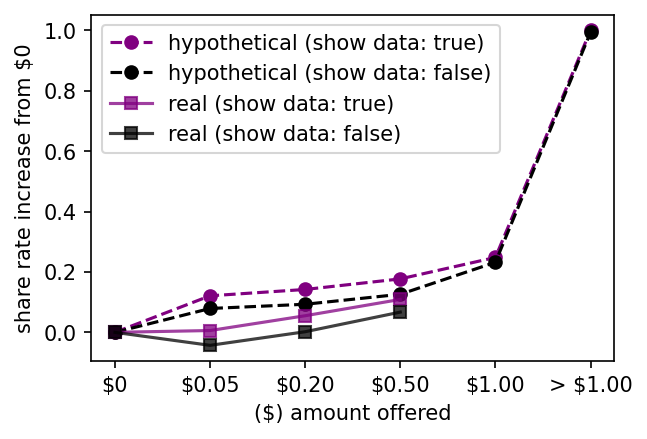

In [133]:
alpha = 0.75
fig,ax = plt.subplots(1,1, figsize=(4.5,3), dpi=150)
# showdata:true
ax.plot(hypo_share_rate_change_showdata_true['cumulative share rate'], 
        'o--', 
        color='purple', markersize=6,
       label='hypothetical (show data: true)')
ax.plot(hypo_share_rate_change_showdata_false['cumulative share rate'], 
        'o--', 
        color='black', markersize=6,
       label='hypothetical (show data: false)')
ax.plot(real_share_rate_change_showdata_true, 
        's-', 
        alpha=alpha,
        color='purple', markersize=6,
       label='real (show data: true)')

ax.plot(real_share_rate_change_showdata_false, 
        's-', 
        alpha=alpha,
        color='black', markersize=6,
       label='real (show data: false)')
#ax.set_ylim([0,1])
ax.set_ylabel('share rate increase from $0')
ax.set_xlabel('($) amount offered')
_ = ax.legend()

Observations:

- should expect the hypotehtical \$0.05 share rate to be higher since it can only increase vs we know in the real data that it was a lower share rate vs control
- consistent in both hypothetical and real data: share rate higher for showdata:true, and the difference between showdata:true vs showdata:false is consistent
- this is the case until the hypothetical bonus is $1 or more at which point there is negligible difference between showdata:true vs false
- almost all will hypothetically share data for some amount when they can name their own price

#### Analysis method 2

Computer real impact of $0.50 as:

- (share_rate_bonus50 - share_rate_bonus20)

Vs


Hypothetical impact:
- Restrict to incentive:bonus20 & no share
- Use rate of share for hypothetical bonus50

Similarly for the other amounts


In [134]:
# computing real impact:
# for showdata:false
bonus_share_rate_showdata0 = (
    agg_share_df[agg_share_df['showdata']==False].set_index('incentive').drop('altruism').reset_index()
)
bonus_share_rate_showdata0
# for showdata:true
bonus_share_rate_showdata1 = (
    agg_share_df[agg_share_df['showdata']==True].set_index('incentive').drop('altruism').reset_index()
)
bonus_share_rate_showdata1

,incentive,showdata,n,share rate
0,control,True,639,0.779
1,bonus-05,True,618,0.785
2,bonus-20,True,602,0.834
3,bonus-50,True,616,0.888


In [136]:
bonus_real_impact_showdata1 = (
    bonus_share_rate_showdata1.shift(-1)['share rate'] - bonus_share_rate_showdata1['share rate'])#.dropna()
print('real impact for showdata:true')
print(bonus_real_impact_showdata1)
print('\nreal impact for showdata:false')
bonus_real_impact_showdata0 = (
    bonus_share_rate_showdata0.shift(-1)['share rate'] - bonus_share_rate_showdata0['share rate'])#.dropna()
bonus_real_impact_showdata0

real impact for showdata:true
0    0.006
1    0.049
2    0.054
3      NaN
Name: share rate, dtype: float64

real impact for showdata:false


0   -0.043
1    0.045
2    0.065
3      NaN
Name: share rate, dtype: float64

Compute hypothetical impact of bonus

for each bonus amount starting with control
- restrict data to this incentive
- restrict data to no share: `no share count`
- count yes to hypothtical share for next amount: `hypo bonus share count`
- compute hypothetical impact

i.e. make table
```
no share count, hypo bonus share count, hypo impact
```
where:

hypo impact is `hypo bonus share count`/`no share count`

In [137]:
# computing hypothetical impact

def get_hypo_impact(df):
    df_colnames = ['incentive change', 'no share count', 'hypo bonus share count', 'hypo impact']
    df_rows = []
    iters = [
        ('control','\$0.05 vs control', 'Q-data-value-05'),
        ('bonus-05','\$0.20 vs \$0.05', 'Q-data-value-20'),
        ('bonus-20','\$0.50 vs \$0.20', 'Q-data-value-50'),
        ('bonus-50','\$1.00 vs \$0.50', 'Q-data-value-100'),
    ]
    for (incentive, change, hypo_Q) in iters:
        sdf = df[
            (df['share']==0)&(df['incentive']==incentive)
        ][hypo_Q].apply(lambda a: 1 if a=='Yes' else 0)
        df_rows.append([change, len(sdf), sdf.sum(), round(sdf.sum()/len(sdf),3)])
    return pd.DataFrame(df_rows, columns=df_colnames)
    
hypo_impact_showdata0 = get_hypo_impact(df[df['showdata']==False])
print('hypo impact for showdata:false')
display(hypo_impact_showdata0)
print('hypo impact for showdata:true')
hypo_impact_showdata1 = get_hypo_impact(df[df['showdata']==True])
hypo_impact_showdata1

hypo impact for showdata:false


,incentive change,no share count,hypo bonus share count,hypo impact
0,\$0.05 vs control,151,12,0.079
1,\$0.20 vs \$0.05,181,17,0.094
2,\$0.50 vs \$0.20,152,27,0.178
3,\$1.00 vs \$0.50,106,18,0.170


hypo impact for showdata:true


,incentive change,no share count,hypo bonus share count,hypo impact
0,\$0.05 vs control,141,17,0.121
1,\$0.20 vs \$0.05,133,21,0.158
2,\$0.50 vs \$0.20,100,22,0.220
3,\$1.00 vs \$0.50,69,18,0.261


In [138]:
x = ['\$0.05 vs control', '\$0.20 vs \$0.05', '\$0.50  vs \$0.20', '\$1.00  vs \$0.50']

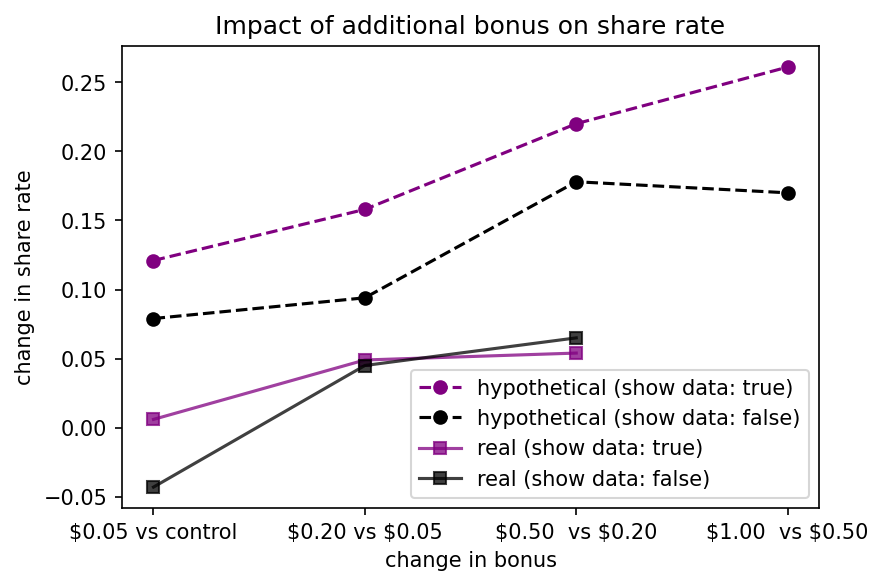

In [139]:
alpha = 0.75
fig,ax = plt.subplots(1,1, figsize=(6,4), dpi=150)

ax.plot(x, hypo_impact_showdata1['hypo impact'], 
        'o--', 
        color='purple', markersize=6,
       label='hypothetical (show data: true)')
ax.plot(x, hypo_impact_showdata0['hypo impact'],
        'o--', 
        color='black', markersize=6,
       label='hypothetical (show data: false)')

ax.plot(x, bonus_real_impact_showdata1, 
        's-', 
        alpha=alpha,
        color='purple', markersize=6,
       label='real (show data: true)')
ax.plot(x, bonus_real_impact_showdata0, 
        's-', 
        alpha=alpha,
        color='black', markersize=6,
       label='real (show data: false)')
ax.legend()
ax.set_xlabel('change in bonus')
ax.set_ylabel('change in share rate')
_ = ax.set_title('Impact of additional bonus on share rate')

##### Question: 
- Are the real impacts statistically significant?
- What is the right way to test this?

To test we do 3 regressions, each restricting data to the 2 incentives compared:

share ~ incentive + showdata

1.
Limit data to  incentives: [control, bonus-05] --> no significant difference
2.
Limit data to  incentives: [bonus-05, bonus-20] --> significant difference
3.
Limit data to  incentives: [bonus-20, bonus-50] --> significant difference

Use the lower amount as the reference value in the regression.


In [140]:
for incentives in [['control', 'bonus-05'], ['bonus-05', 'bonus-20'], ['bonus-20', 'bonus-50']]:
    formula = "share ~ C(incentive, Treatment(reference='%s')) + showdata" % incentives[0]
    print('formula: %s' % formula)
    print('limiting data to incentives:', incentives)
    imdf = df[df['incentive'].isin(incentives)]
    model = smf.logit(formula=formula, data=imdf).fit()
    display(model.summary2())
    display(get_predictors_table(model))

formula: share ~ C(incentive, Treatment(reference='control')) + showdata
limiting data to incentives: ['control', 'bonus-05']
Optimization terminated successfully.
         Current function value: 0.548054
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.003    
Dependent Variable:              share                         AIC:                           2790.1120
Date:                            2023-06-12 22:47              BIC:                           2807.6318
No. Observations:                2540                          Log-Likelihood:                -1392.1  
Df Model:                        2                             LL-Null:                       -1395.6  
Df Residuals:                    2537                          LLR p-value:                   0.029501 
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  5.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.1050   0.0799 13.8256 0.0000  0.9484 1.2617
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1031   0.0933 -1.1059 0.2688 -0.2859 0.0797
showdata[T.True]                                          0.2239   0.0935  2.3956 0.0166  0.0407 0.4071
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.105***,3.019,"[2.582, 3.531]",0.000
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.103,0.902,"[0.751, 1.083]",0.269
showdata[T.True],0.224*,1.251,"[1.042, 1.502]",0.017


formula: share ~ C(incentive, Treatment(reference='bonus-05')) + showdata
limiting data to incentives: ['bonus-05', 'bonus-20']
Optimization terminated successfully.
         Current function value: 0.528474
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
======================================================================================================
Model:                           Logit                        Pseudo R-squared:             0.009     
Dependent Variable:              share                        AIC:                          2664.2229 
Date:                            2023-06-12 22:47             BIC:                          2681.7130 
No. Observations:                2515                         Log-Likelihood:               -1329.1   
Df Model:                        2                            LL-Null:                      -1341.1   
Df Residuals:                    2512                         LLR p-value:                  6.4579e-06
Converged:                       1.0000                       Scale:                        1.0000    
No. Iterations:                  5.0000                                                               
------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------------
Intercept                                                 0.9290   0.0780 11.9139 0.0000 0.7762 1.0818
C(incentive, Treatment(reference='bonus-05'))[T.bonus-20] 0.2726   0.0963  2.8316 0.0046 0.0839 0.4613
showdata[T.True]                                          0.3859   0.0968  3.9844 0.0001 0.1961 0.5757
======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,0.929***,2.532,"[2.173, 2.950]",0.000
"C(incentive, Treatment(reference='bonus-05'))[T.bonus-20]",0.273**,1.313,"[1.088, 1.586]",0.005
showdata[T.True],0.386***,1.471,"[1.217, 1.778]",0.000


formula: share ~ C(incentive, Treatment(reference='bonus-20')) + showdata
limiting data to incentives: ['bonus-20', 'bonus-50']
Optimization terminated successfully.
         Current function value: 0.451445
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
======================================================================================================
Model:                           Logit                        Pseudo R-squared:             0.015     
Dependent Variable:              share                        AIC:                          2254.1979 
Date:                            2023-06-12 22:47             BIC:                          2271.6580 
No. Observations:                2490                         Log-Likelihood:               -1124.1   
Df Model:                        2                            LL-Null:                      -1141.0   
Df Residuals:                    2487                         LLR p-value:                  4.5521e-08
Converged:                       1.0000                       Scale:                        1.0000    
No. Iterations:                  6.0000                                                               
------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------------
Intercept                                                 1.1733   0.0839 13.9882 0.0000 1.0089 1.3377
C(incentive, Treatment(reference='bonus-20'))[T.bonus-50] 0.4258   0.1082  3.9360 0.0001 0.2138 0.6379
showdata[T.True]                                          0.4534   0.1086  4.1732 0.0000 0.2405 0.6664
======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,p-value
Predictor,,,,
Intercept,1.173***,3.233,"[2.743, 3.810]",0.0
"C(incentive, Treatment(reference='bonus-20'))[T.bonus-50]",0.426***,1.531,"[1.238, 1.892]",0.0
showdata[T.True],0.453***,1.574,"[1.272, 1.947]",0.0


##### Plotting the results

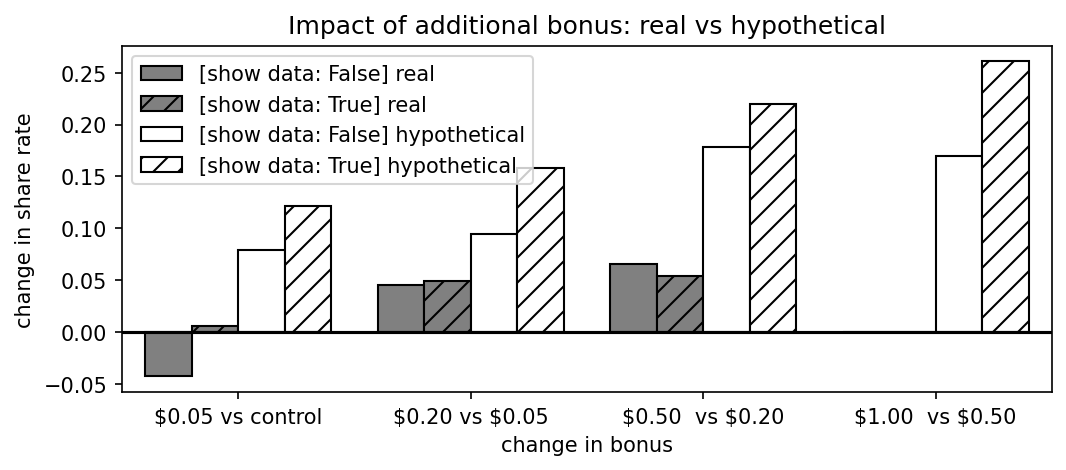

In [141]:
# Use a grouped bar chart to show changes in share rate
width = 0.2
figsize=(8,3)
fig,ax = plt.subplots(1,1, figsize=figsize, dpi=150)
bonus_real_impact_showdata0.plot(kind='bar', ax=ax, width=width, position=2,
         color='gray', edgecolor='black', alpha=1, 
         label='[show data: False] real')
bonus_real_impact_showdata1.plot(kind='bar', ax=ax, width=width, position=1,
         color='gray', edgecolor='black', alpha=1, hatch='//', 
         label='[show data: True] real')

hypo_impact_showdata0['hypo impact'].plot(kind='bar', ax=ax, width=width, position=0,
         color='white', edgecolor='black', alpha=1, 
         label='[show data: False] hypothetical')
hypo_impact_showdata1['hypo impact'].plot(kind='bar', ax=ax, width=width, position=-1,
         color='white', edgecolor='black', alpha=1, hatch='//', 
         label='[show data: True] hypothetical')
# plot y=0
plt.axhline(0, color='black')
ax.legend()
ax.set_xlim([-0.5,3.5])
_ = ax.set_xticklabels(x, rotation=0)
ax.set_xlabel('change in bonus')
ax.set_ylabel('change in share rate')
_ = ax.set_title('Impact of additional bonus: real vs hypothetical')

differences: show data false
0    0.122
1    0.049
2    0.113
3      NaN
dtype: float64
differences: show data true
0    0.115
1    0.109
2    0.166
3      NaN
dtype: float64
differences between the differences:
0   -0.007
1    0.060
2    0.053
3      NaN
dtype: float64


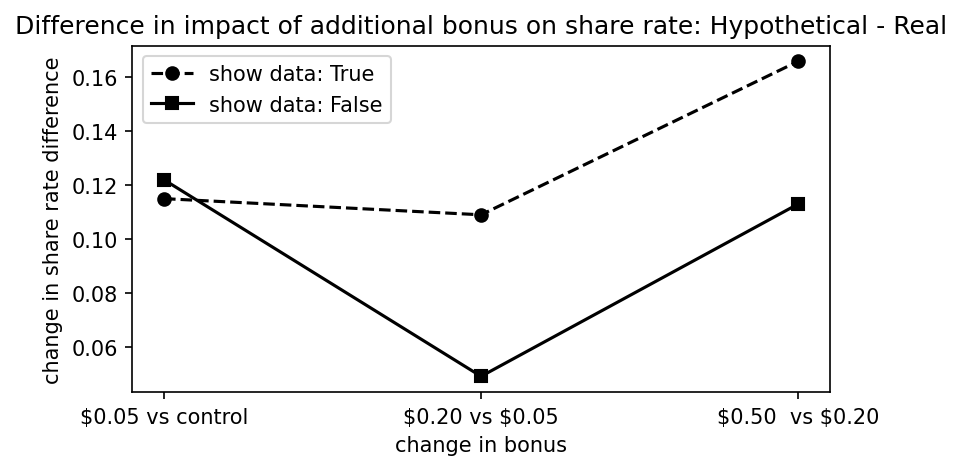

In [142]:
figsize=(6,3)
fig,ax = plt.subplots(1,1, figsize=figsize, dpi=150)

differences_showdata0 = hypo_impact_showdata0['hypo impact'] - bonus_real_impact_showdata0
print('differences: show data false')
print(differences_showdata0)
differences_showdata1 = hypo_impact_showdata1['hypo impact'] - bonus_real_impact_showdata1
print('differences: show data true')
print(differences_showdata1)
print('differences between the differences:')
print(differences_showdata1 - differences_showdata0)
ax.plot(x, differences_showdata1, 
        'o--', 
        color='black', markersize=6,
       label='show data: True')
ax.plot(x, differences_showdata0,
        's-', 
        color='black', markersize=6,
       label='show data: False')
ax.legend()
ax.set_xlabel('change in bonus')
ax.set_ylabel('change in share rate difference')
_ = ax.set_title('Difference in impact of additional bonus on share rate: Hypothetical - Real')

#### Analysis method 3

Uses same strategy for real change in share rate. Hypothetical change calculated differently.

documented [here](https://docs.google.com/document/d/13K_F9sb66HobTmcTljW2wm3L6rrMffIwHQ1xUmmBIYE/edit?pli=1#heading=h.8yccm9pnwviv)



Where:
- s_i = number of people offered bonus_i who did consent to share
- h_i = number of people offered bonus_{i - 1} who did not consent to share but answered they would hypothetically share for bonus_i
- Y_i = (s_{i-1} + h_i) / n_{i - 1}
- eg: Y1 = (# ppl who either shared in control or hypothetically would share for $0.05) / (total # of people in control)
- As a result, hypothetical impact is both: 
    - h_i/n_{i-1}
    - Y_i - X_{i-1}


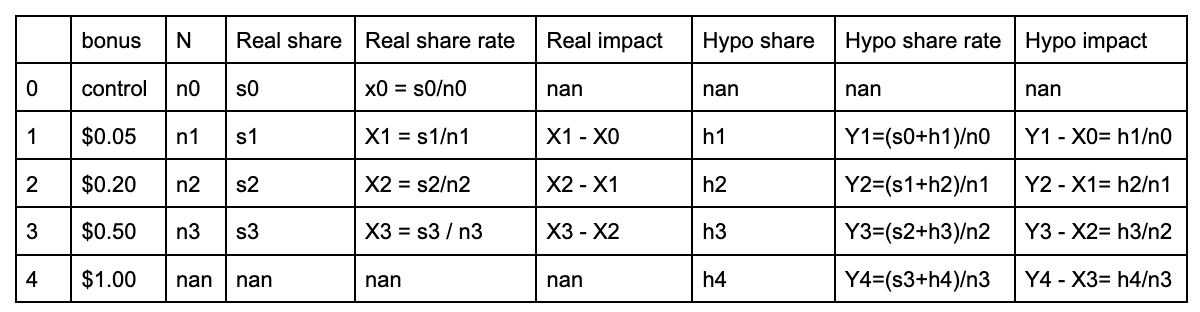

In [143]:
bonus_names = [
    '',
    '\\$0.05 vs control',
    '\\$0.20 vs \\$0.05',
    '\\$0.50 vs \\$0.20',
    '\\$1.00 vs \\$0.50'
]

def get_hypo_shares(df):
    rows = [np.nan]
    iters = [
        ('control','Q-data-value-05'),
        ('bonus-05','Q-data-value-20'),
        ('bonus-20','Q-data-value-50'),
        ('bonus-50','Q-data-value-100'),
    ]
    for (incentive, hypo_Q) in iters:
        sdf = df[df['incentive']==incentive][hypo_Q].apply(lambda a: 1 if a=='Yes' else 0)
        rows.append(sdf.sum())
    return rows

def make_real_hypo_impact_df(df):
    rhdf =  (
        df.groupby(['incentive'])['share'].agg(['count','sum','mean']).round(3)
        .drop('altruism')
        .loc[['control', 'bonus-05', 'bonus-20', 'bonus-50']] # sort index
        .reset_index()
    )
    rhdf.loc[4] = np.nan
    rhdf['bonus'] = bonus_names[:len(rhdf)]
    rhdf['real impact'] = rhdf['mean'] - rhdf.shift(1)['mean']
    # rename columns
    rhdf = rhdf.rename(columns={'count':'n', 'sum':'real share','mean':'real share rate'})
    # reorder the columns
    rhdf = rhdf[['incentive','bonus','n','real share','real share rate','real impact']]
    rhdf['hypo share'] = get_hypo_shares(df)
    # Y_i = (s_{i-1} + h_i) / n_{i - 1}
    rhdf['hypo share rate'] = ((rhdf['real share'].shift(1) + rhdf['hypo share'])/rhdf.shift(1)['n']).round(3)
    # Y4 - X3= h4/n3
    rhdf['hypo impact'] = (rhdf['hypo share']/rhdf.shift(1)['n']).round(3)
    return rhdf
    
real_hypo_impact_showdata0 = make_real_hypo_impact_df(df[df['showdata']==False])
real_hypo_impact_showdata0

,incentive,bonus,n,real share,real share rate,real impact,hypo share,hypo share rate,hypo impact
0,control,,636.0,485.0,0.763,NaN,NaN,NaN,NaN
1,bonus-05,\$0.05 vs control,647.0,466.0,0.720,-0.043,12.0,0.781,0.019
2,bonus-20,\$0.20 vs \$0.05,648.0,496.0,0.765,0.045,17.0,0.747,0.026
3,bonus-50,\$0.50 vs \$0.20,624.0,518.0,0.830,0.065,27.0,0.807,0.042
4,NaN,\$1.00 vs \$0.50,NaN,NaN,NaN,NaN,18.0,0.859,0.029


In [144]:
# make a separate dataframe for showdata true vs false

real_hypo_impact_showdata1 = make_real_hypo_impact_df(df[df['showdata']==True])
print('show data: True')
display(real_hypo_impact_showdata1)

real_hypo_impact_showdata0 = make_real_hypo_impact_df(df[df['showdata']==False])
print('show data: False')
display(real_hypo_impact_showdata0)

show data: True


,incentive,bonus,n,real share,real share rate,real impact,hypo share,hypo share rate,hypo impact
0,control,,639.0,498.0,0.779,NaN,NaN,NaN,NaN
1,bonus-05,\$0.05 vs control,618.0,485.0,0.785,0.006,17.0,0.806,0.027
2,bonus-20,\$0.20 vs \$0.05,602.0,502.0,0.834,0.049,21.0,0.819,0.034
3,bonus-50,\$0.50 vs \$0.20,616.0,547.0,0.888,0.054,22.0,0.870,0.037
4,NaN,\$1.00 vs \$0.50,NaN,NaN,NaN,NaN,18.0,0.917,0.029


show data: False


,incentive,bonus,n,real share,real share rate,real impact,hypo share,hypo share rate,hypo impact
0,control,,636.0,485.0,0.763,NaN,NaN,NaN,NaN
1,bonus-05,\$0.05 vs control,647.0,466.0,0.720,-0.043,12.0,0.781,0.019
2,bonus-20,\$0.20 vs \$0.05,648.0,496.0,0.765,0.045,17.0,0.747,0.026
3,bonus-50,\$0.50 vs \$0.20,624.0,518.0,0.830,0.065,27.0,0.807,0.042
4,NaN,\$1.00 vs \$0.50,NaN,NaN,NaN,NaN,18.0,0.859,0.029


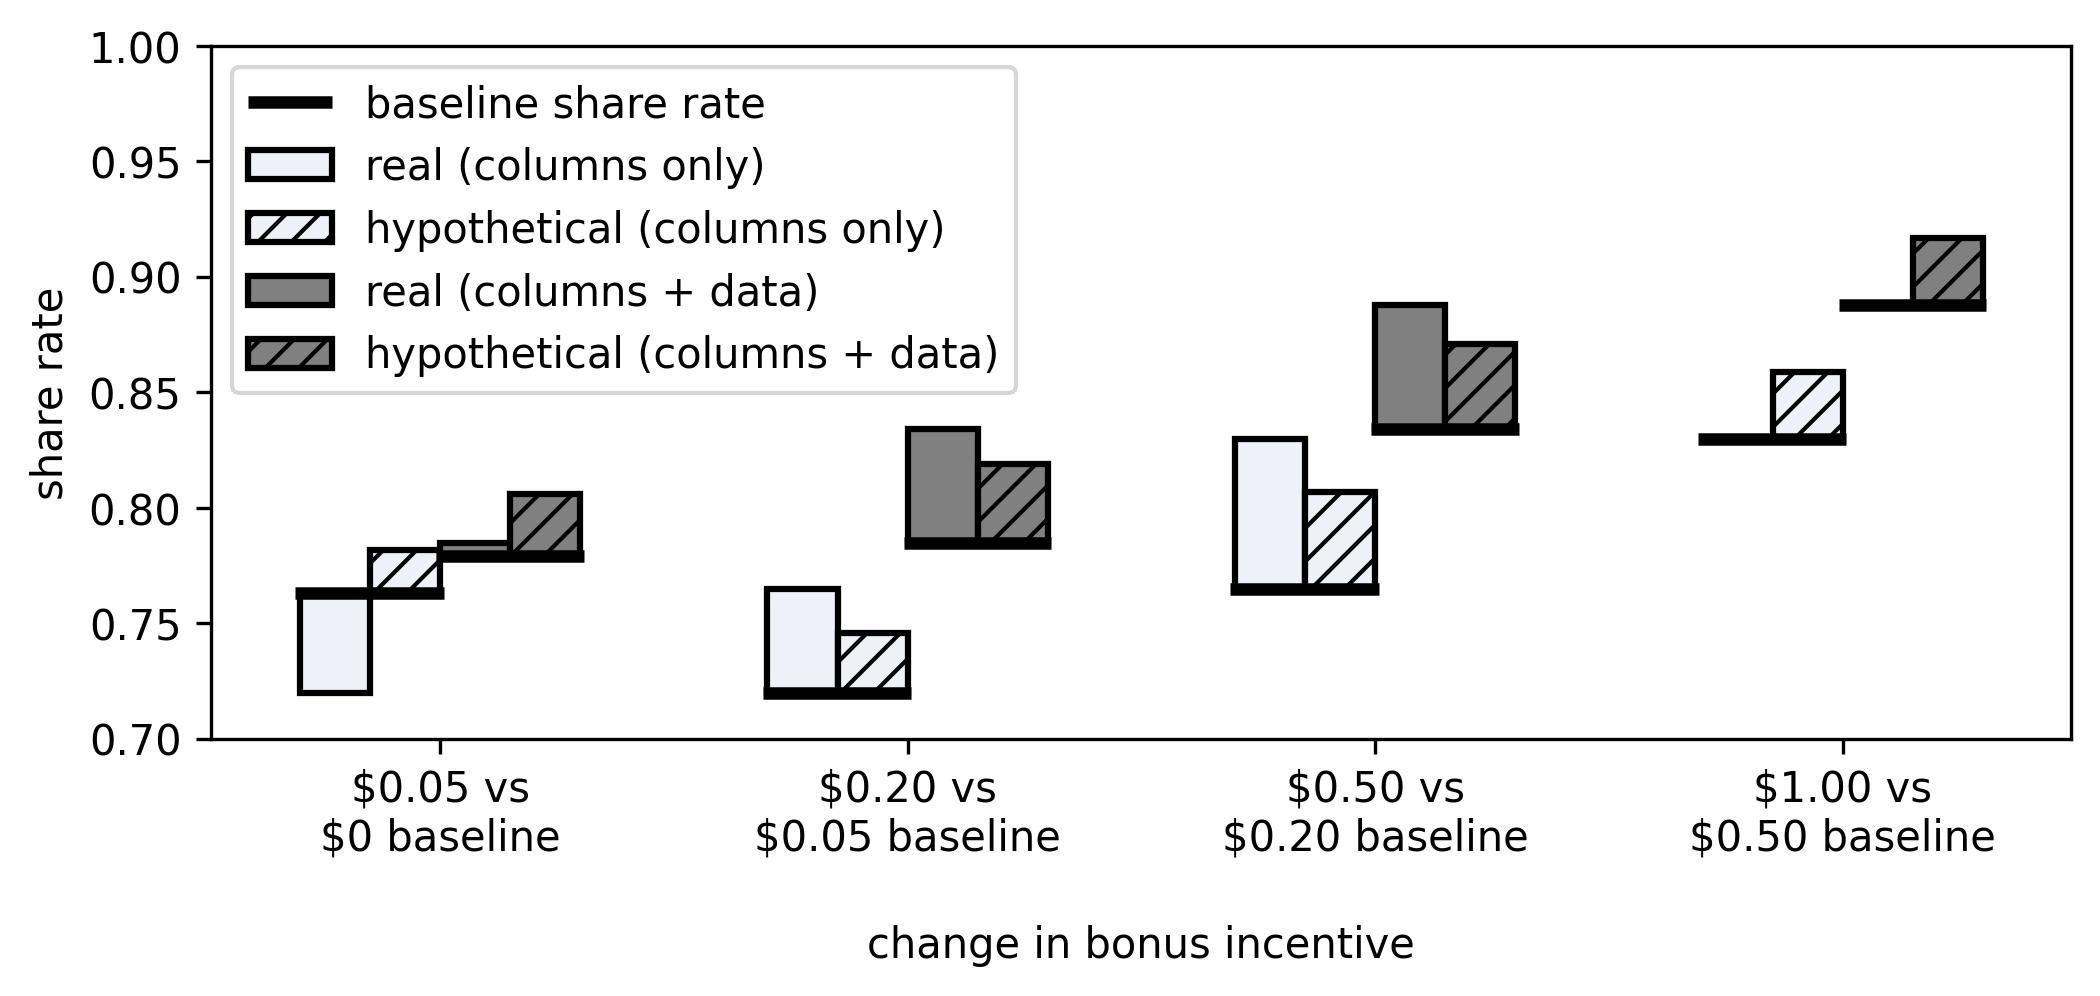

In [264]:
# Use a grouped bar chart to show changes in share rate
width = 0.15 # the width of the bars
multiplier = 0
figsize=(8,3)
fig,ax = plt.subplots(1,1, figsize=figsize, dpi=300)
xticks = np.arange(4)
# showdata:false
showdata0_baseline = real_hypo_impact_showdata0.shift(1).drop(0)['real share rate']
ax.bar(xticks + width*multiplier, real_hypo_impact_showdata0.drop(0)['real impact'],
       bottom=showdata0_baseline,
       width=width, color=showdata_false_color, edgecolor='black', alpha=1,
       linewidth=1.5,
       label='real (%s)'%showdata_false_label)
multiplier += 1
ax.bar(xticks + width*multiplier, real_hypo_impact_showdata0.drop(0)['hypo impact'],
       bottom=showdata0_baseline,
       width=width,
       color=showdata_false_color, edgecolor='black', alpha=1, hatch='///',
       linewidth=1.5,
       label='hypothetical (%s)'%showdata_false_label)
# showdata: true
showdata1_baseline = real_hypo_impact_showdata1.shift(1).drop(0)['real share rate']
multiplier += 1
ax.bar(xticks + width*multiplier, real_hypo_impact_showdata1.drop(0)['real impact'],
       bottom=showdata1_baseline,
       width=width, color=showdata_true_color, edgecolor='black', alpha=1,
       linewidth=1.5,
       label='real (%s)'%showdata_true_label)
multiplier += 1
ax.bar(xticks + width*multiplier, real_hypo_impact_showdata1.drop(0)['hypo impact'],
       bottom=showdata1_baseline,
       width=width,
       color=showdata_true_color, edgecolor='black', alpha=1, hatch='///',
       linewidth=1.5,
       label='hypothetical (%s)'%showdata_true_label)

baseline_label = 'baseline share rate'
# baseline_label = 'baseline share rate for previous incentive'
for i, baseline_val in enumerate(showdata0_baseline):
    ax.hlines(baseline_val, i-(width)/2-0.01, i+1.5*(width+0.005),
               color='black', linewidth=3,
               label=(baseline_label if i ==0 else None))
for i, baseline_val in enumerate(showdata1_baseline):
    ax.hlines(baseline_val, i+1.5*(width)-0.008, i+3.5*(width+0.002),
               color='black', linewidth=3)
ax.legend()
ax.set_ylim([0.7, 1])
# A few different ways to label this
xlabels_a = ['\$0.05 vs control', '\$0.20 vs \$0.05', '\\$0.50  vs \$0.20', '\$1.00  vs \$0.50']
xlabels_b = [
    '\$0.05 vs\n\$0 baseline', '\$0.20 vs\n\$0.05 baseline', 
    '\$0.50 vs\n\$0.20 baseline',
    '\$1.00 vs\n\$0.50 baseline',
]
xlabels_c = ['\$0.05', '\$0.20', '\$0.50', '\$1.00']
xlabels_d = [
    'change from\ncontrol to \$0.05',
    'change from\n$0.05 to \$0.20',
    'change from\n$0.20 to \$0.50',
    'change from\n$0.50 to \$1.00',
]
ax.set_xticks(xticks+1.5*width, xlabels_a)
ax.set_xticks(xticks+1.5*width, xlabels_b)
# ax.set_xticks(xticks+1.5*width, xlabels_c)
# ax.set_xticks(xticks+1.5*width, xlabels_d)
ax.set_xlabel('\nchange in bonus incentive')
_ = ax.set_ylabel('share rate')
# _ = ax.set_title('Impact of additional bonus: real vs hypothetical')

#### People willing to share for some amount

Compute number and percent (%) of people who said they would share their data for some monetary reward.

Show the range of values people wrote in for the any amount.

Range: 
- \\$2.00 to \$5,000,000 for control.
- \\$2.00 to \$1,000,000,000,000,000 for overall.


Count the number of people who would not share for any amount.

In [146]:
df['Q-data-value-any'].unique()

array([nan, 'More than $1.00 (enter amount)',
       'I would not consent to share my data for any amount.'],
      dtype=object)

In [147]:
no_amnt_v = 'I would not consent to share my data for any amount.'
no_amnt_N = df['Q-data-value-any'].apply(lambda v: 1 if (v== no_amnt_v) else 0).sum()

print('%s/%s = %%%0.2f would not consent to share their data for any amount' % (
    no_amnt_N, N, 100*(no_amnt_N/N)))

330/6325 = %5.22 would not consent to share their data for any amount


Get the range of write-in values

In [148]:
def transform_write_in_amount(v):
    v = str(v).strip('$').replace(',', '').replace('K', '000')
    try:
        return float(v)
    except Exception as e:
        print('could not transform value to float:')
        print(v)
    return np.nan

print('control:')
print(control_df['Q-data-value-any_1_TEXT'].apply(transform_write_in_amount).describe())

control:
count    1.580000e+02
mean     4.806972e+04
std      4.138422e+05
min      2.000000e+00
25%      1.000000e+01
50%      2.000000e+01
75%      1.000000e+02
max      5.000000e+06
Name: Q-data-value-any_1_TEXT, dtype: float64


In [149]:
print('overall:')
print(df['Q-data-value-any_1_TEXT'].apply(transform_write_in_amount).describe())

overall:
could not transform value to float:
Maybe $2.50. I would have shared it if it allowed me to edit the file to block other information but I couldn’t.
count    6.410000e+02
mean     1.560064e+12
std      3.949763e+13
min      2.000000e+00
25%      1.000000e+01
50%      2.400000e+01
75%      1.000000e+02
max      1.000000e+15
Name: Q-data-value-any_1_TEXT, dtype: float64


#### Incremental changes in hypothetical share rate

We also more directly show how the hypothetical monetary incentive incrementally increases the share rate.

We do this by restricting the analysis to participants in the control groups.

In [150]:
control_df = get_control_df(df)
control_N = len(control_df)
control_share_rate = control_df['share'].mean().round(3)
print('control N = %s' % control_N)
print('control share rate: %s' % control_share_rate)
control_df[[
    'showdata', 'share',
    'Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 
    'Q-data-value-100', 'Q-data-value-any', 'Q-data-value-any_1_TEXT'
]].head()

control N = 1275
control share rate: 0.771


,showdata,share,Q-data-value-05,Q-data-value-20,Q-data-value-50,Q-data-value-100,Q-data-value-any,Q-data-value-any_1_TEXT
4,True,1,NaN,NaN,NaN,NaN,NaN,NaN
8,False,0,No,No,No,No,More than $1.00 (enter amount),1000.00
9,True,1,NaN,NaN,NaN,NaN,NaN,NaN
12,True,1,NaN,NaN,NaN,NaN,NaN,NaN
16,False,1,NaN,NaN,NaN,NaN,NaN,NaN


#### Real vs Hypothetical (restricted to control)


Here we are not considering the control as \$0. This is because
- monetary incentive is not on participants' mind when seeing the control
- there is non monatonic effect going from control to \\$0.05. Otherwise data very linear

Below plot spaces the monetary incentives by their true values

In [284]:
# make a table counting shares
def get_control_hypo_shares(cdf):
    control_hypo_df = cdf[[
        'share',
        'Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 
        'Q-data-value-100', 'Q-data-value-any'
    ]].copy()
    hypo_cols = ['control','$0.05','$0.20','$0.50','$1.00','any $X']
    control_hypo_df.columns = hypo_cols
    # Map the No/Yes/NaN/More than $1.00 (enter amount) data value questions to 0/1/NaN
    map_v = lambda v: 0 if (v in ['No', 0]) else (1 if v in ['Yes', 1] else 0)
    any_v_yes = 'More than $1.00 (enter amount)'
    any_v_no = 'I would not consent to share my data for any amount.'
    map_any_v = lambda v: 0 if v==any_v_no else (1 if v ==any_v_yes else 0)
    for c in ['control','$0.05','$0.20','$0.50','$1.00']:
        control_hypo_df[c] = control_hypo_df[c].apply(map_v)
    control_hypo_df['any $X'] = control_hypo_df['any $X'].apply(map_any_v)
    #return control_hypo_df
    total_count = len(control_hypo_df)
    s = control_hypo_df.apply(sum).to_frame(name='added share count')
    s.index.names = ['incentive']
    s['total count'] = total_count
    s['hypo share count'] = s['added share count'].cumsum()
    s['added share rate'] = s['added share count']/s['total count']
    s['hypo share rate'] = s['added share rate'].cumsum().round(3)
    return s

s0 = get_control_hypo_shares(control_df[control_df['showdata']==False])
s1 = get_control_hypo_shares(control_df[control_df['showdata']==True])
print('show data: False')
s0['real share rate'] = (agg_share_df[agg_share_df['showdata']==False]
 .set_index('incentive')
 .loc[['control','bonus-05','bonus-20','bonus-50']]['share rate']
 .rename({'bonus-05':'$0.05', 'bonus-20':'$0.20', 'bonus-50':'$0.50'})
)
display(s0)
print('Show data: True')
s1['real share rate'] = (agg_share_df[agg_share_df['showdata']==True]
 .set_index('incentive')
 .loc[['control','bonus-05','bonus-20','bonus-50']]['share rate']
 .rename({'bonus-05':'$0.05', 'bonus-20':'$0.20', 'bonus-50':'$0.50'})
)
display(s1)

show data: False


,added share count,total count,hypo share count,added share rate,hypo share rate,real share rate
incentive,,,,,,
control,485,636,485,0.762579,0.763,0.763
$0.05,12,636,497,0.018868,0.781,0.720
$0.20,2,636,499,0.003145,0.785,0.765
$0.50,5,636,504,0.007862,0.792,0.830
$1.00,16,636,520,0.025157,0.818,NaN
any $X,77,636,597,0.121069,0.939,NaN


Show data: True


,added share count,total count,hypo share count,added share rate,hypo share rate,real share rate
incentive,,,,,,
control,498,639,498,0.779343,0.779,0.779
$0.05,17,639,515,0.026604,0.806,0.785
$0.20,3,639,518,0.004695,0.811,0.834
$0.50,5,639,523,0.007825,0.818,0.888
$1.00,10,639,533,0.015649,0.834,NaN
any $X,81,639,614,0.126761,0.961,NaN


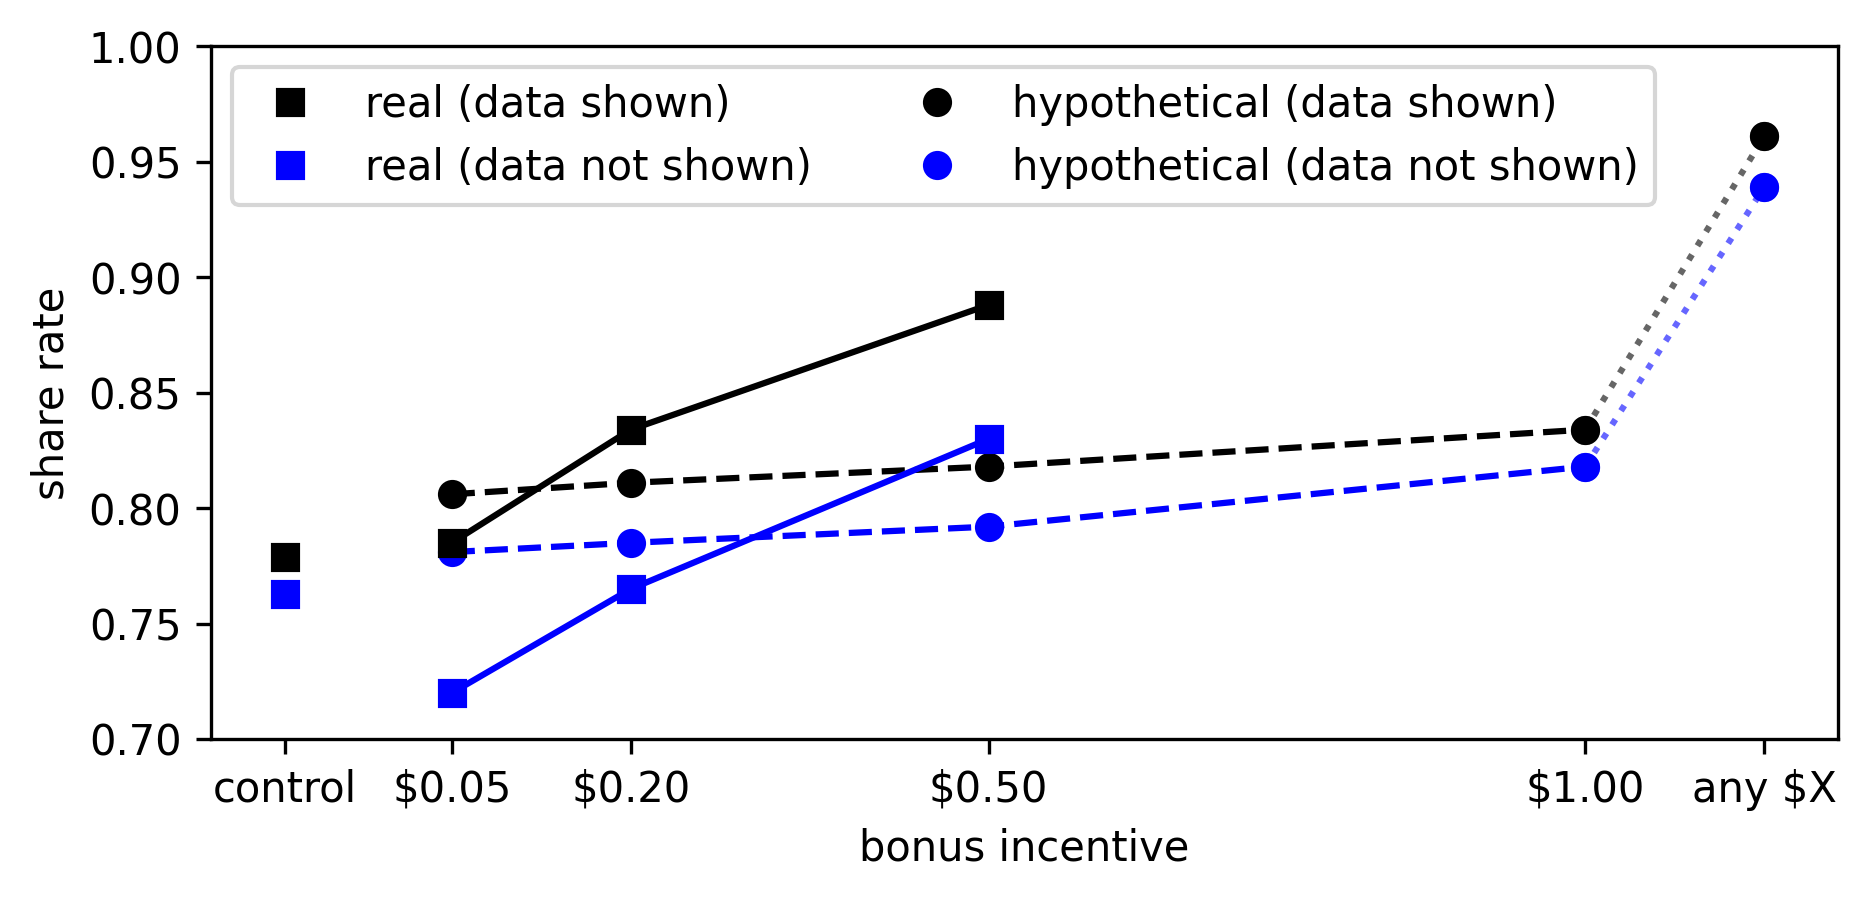

In [266]:
fig, ax = plt.subplots(1,1,figsize=(7,3), dpi=300)
xticks = [-0.09, 0.05, 0.20, 0.5, 1, 1.15]
ax.plot(xticks, [np.nan] + s1['cum share rate'][1:5].tolist() + [np.nan], 
        'o--', color='black', 
        label='')
ax.plot(xticks, [np.nan] + s0['cum share rate'][1:5].tolist() + [np.nan],
        'o--', color='blue', 
        label='')
ax.plot(xticks, [np.nan] + s1['real share rate'][1:].tolist(), 
        's-', color='black')
ax.plot(xticks, [np.nan] + s0['real share rate'][1:].tolist(), 
        's-', color='blue')
# plot control values separately
ax.plot(xticks, [s1['real share rate']['control']] + [np.nan]*5, 
        's', color='black', label='real (data shown)')
ax.plot(xticks, [s0['real share rate']['control']] + [np.nan]*5, 
        's', color='blue', label='real (data not shown)')
# plot hypothetical any $X values - as points
ax.plot(xticks, [np.nan]*5 + s1['cum share rate'][5:].tolist(),
        'o', color='black', label='hypothetical (data shown)')
ax.plot(xticks, [np.nan]*5 + s0['cum share rate'][5:].tolist(),
        'o', color='blue', label='hypothetical (data not shown)')
# with lines
ax.plot(xticks, [np.nan]*4 + s1['cum share rate'][4:].tolist(),
        'o:', color='black', alpha=0.6)
ax.plot(xticks, [np.nan]*4 + s0['cum share rate'][4:].tolist(),
        'o:', color='blue', alpha=0.6)

ax.set_ylabel('share rate')
ax.set_xlabel('bonus incentive')
ax.set_xticks(xticks, s0.index)
ax.legend(ncol=2)
_ = ax.set_ylim([0.7, 1])

In [286]:
# show the tables nicely
print('showdata:False N=%s' % s0['total count'][0])
display(s0[['real share rate', 'hypo share rate']])
print('showdata:True N=%s' % s1['total count'][0])
display(s1[['real share rate', 'hypo share rate']])

showdata:False N=636


,real share rate,hypo share rate
incentive,,
control,0.763,0.763
$0.05,0.720,0.781
$0.20,0.765,0.785
$0.50,0.830,0.792
$1.00,NaN,0.818
any $X,NaN,0.939


showdata:True N=639


,real share rate,hypo share rate
incentive,,
control,0.779,0.779
$0.05,0.785,0.806
$0.20,0.834,0.811
$0.50,0.888,0.818
$1.00,NaN,0.834
any $X,NaN,0.961


Fit a line to the data to show the difference in real vs hypothetical impacts of monetary incentives.

We compute the intercept and slope of the best fit line for:

share rate = intercept + beta x amount

Where amount is of the values 0.05, 0.20, 0.50, and 1.00 for the hypothetical case.

In [273]:
print('fitting line: share data = intercept + beta x amount')
intercept_hs0, beta_hs0 = np.polynomial.Polynomial.fit(
    [0.05, 0.2, 0.5, 1],
    s0['cum share rate'].loc[['$0.05','$0.20','$0.50','$1.00']], 1 # degree=1
)
print('for hypothetical: showdata=False')
print('intercept=%0.3f, beta=%0.3f' % (intercept_hs0, beta_hs0))
intercept_hs1, beta_hs1 = np.polynomial.Polynomial.fit(
    [0.05, 0.2, 0.5, 1],
    s1['cum share rate'].loc[['$0.05','$0.20','$0.50','$1.00']], 1 # degree=1
)
print('for hypothetical: showdata=True')
print('intercept=%0.3f, beta=%0.3f' % (intercept_hs1, beta_hs1))

intercept_rs0, beta_rs0 = np.polynomial.Polynomial.fit(
    [0.05, 0.2, 0.5],
    s0['real share rate'].loc[['$0.05','$0.20','$0.50']], 1 # degree=1
)
print('real: showdata=False')
print('intercept=%0.3f, beta=%0.3f' % (intercept_rs0, beta_rs0))
intercept_rs1, beta_rs1 = np.polynomial.Polynomial.fit(
    [0.05, 0.2, 0.5],
    s1['real share rate'].loc[['$0.05','$0.20','$0.50']], 1 # degree=1
)
print('real: showdata=True')
print('intercept=%0.3f, beta=%0.3f' % (intercept_rs1, beta_rs1))

fitting line: share data = intercept + beta x amount
for hypothetical: showdata=False
intercept=0.797, beta=0.019
for hypothetical: showdata=True
intercept=0.820, beta=0.014
real: showdata=False
intercept=0.778, beta=0.054
real: showdata=True
intercept=0.841, beta=0.050


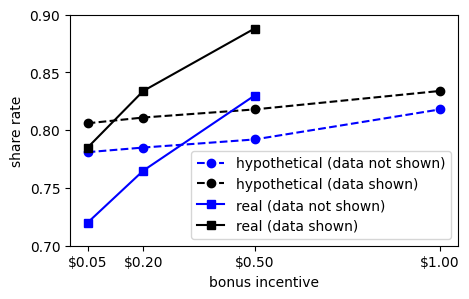

In [164]:
fig, ax = plt.subplots(1,1,figsize=(5,3))#, dpi=300)
xticks = [0.05, 0.20, 0.5, 1]
ax.plot(xticks, s0['cum share rate'][1:5],
        'o--', color='blue', label='hypothetical (data not shown)')
ax.plot(xticks, s1['cum share rate'][1:5], 
        'o--', color='black', label='hypothetical (data shown)')
ax.plot(xticks, s0['real share rate'][1:5], 
        's-', color='blue', label='real (data not shown)')
ax.plot(xticks, s1['real share rate'][1:5], 
        's-', color='black', label='real (data shown)')
ax.set_ylabel('share rate')
ax.set_xlabel('bonus incentive')
ax.set_xticks(xticks, s0.index[1:5])
ax.legend(loc='lower right')
_ = ax.set_ylim([0.7, 0.9])

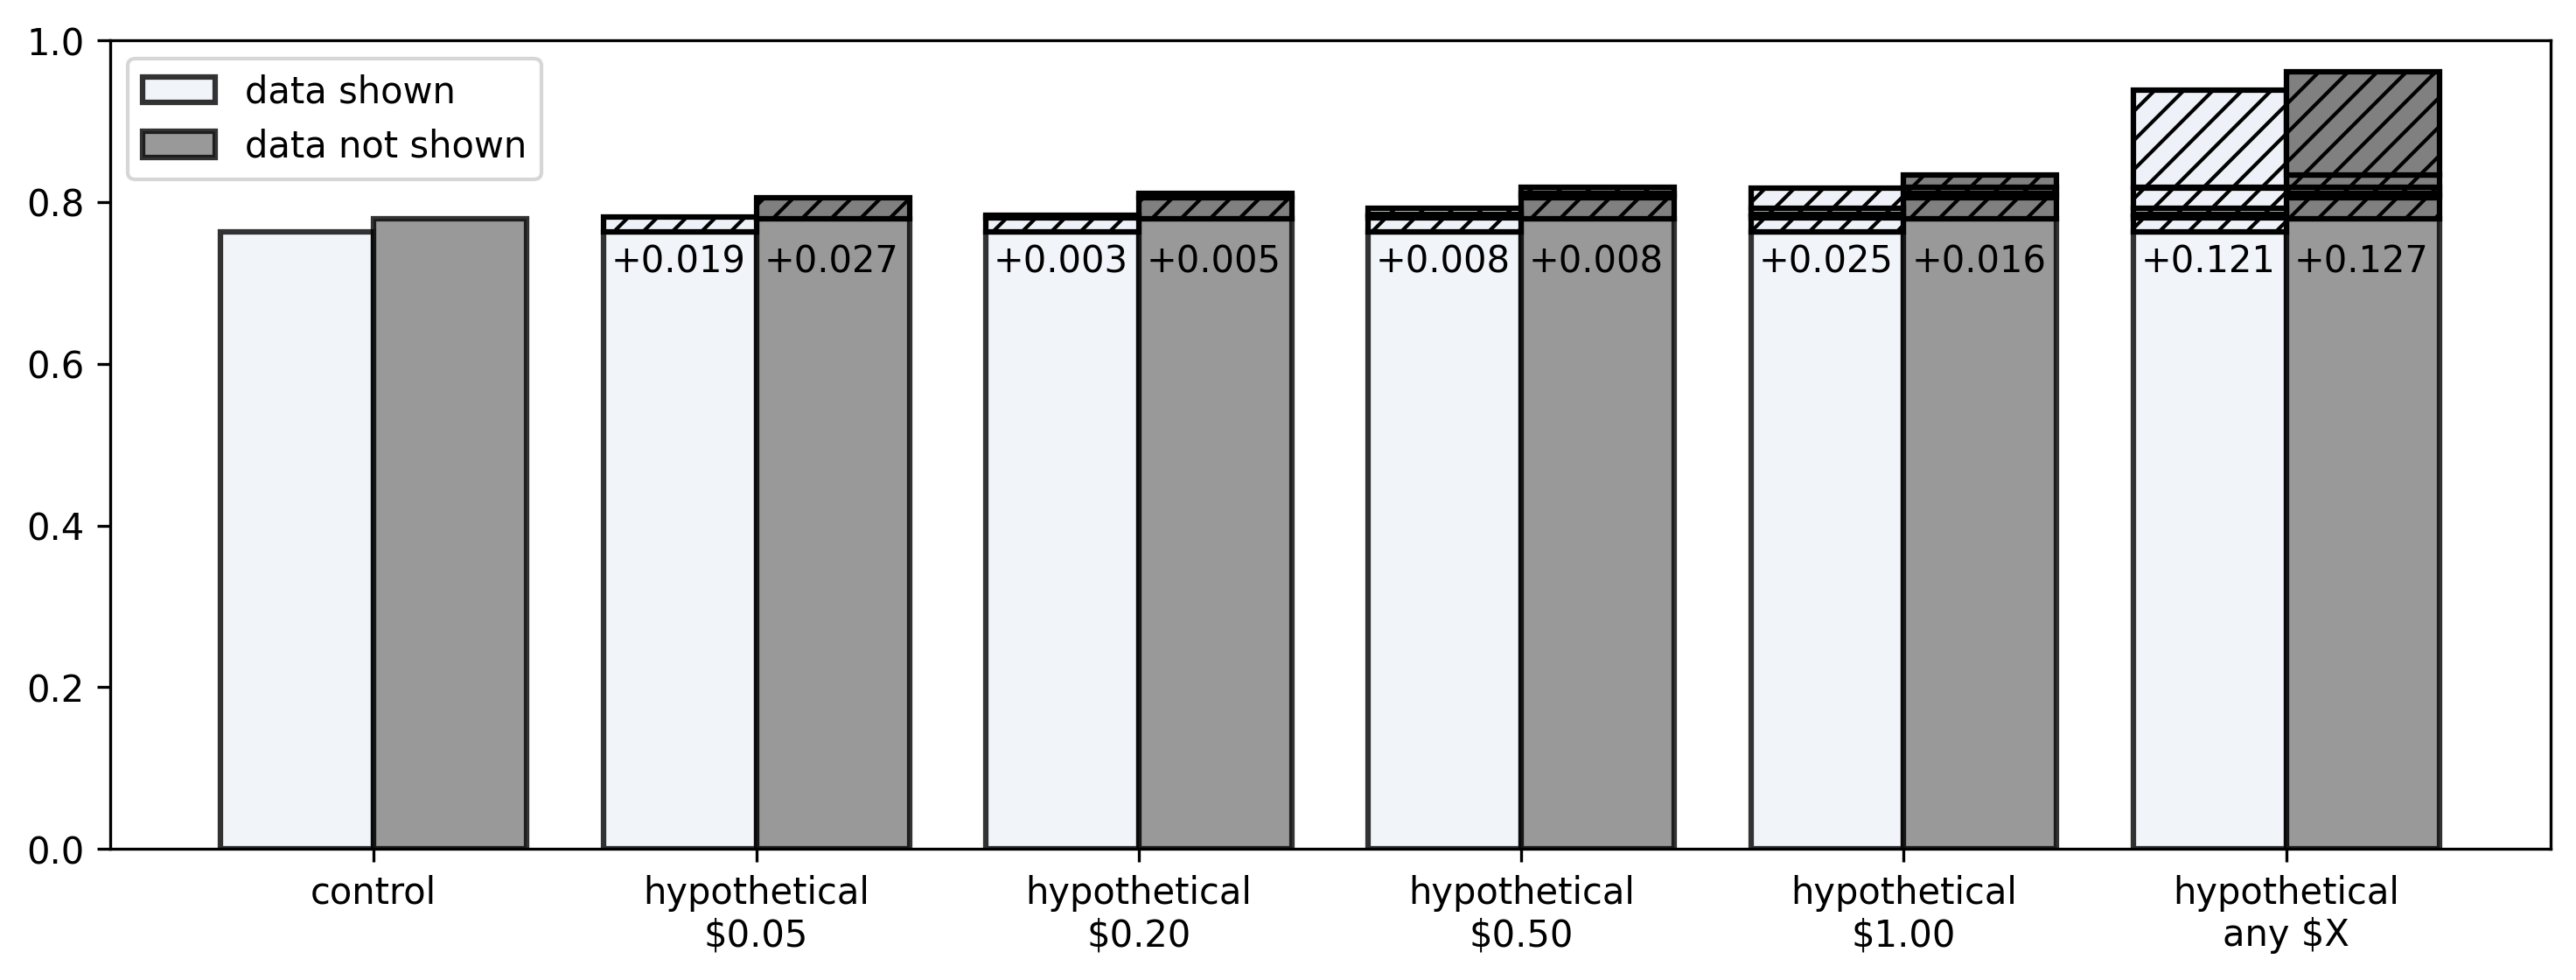

In [160]:
fig,ax = plt.subplots(1,1, figsize=(12,4), dpi=300)
# add control share rate
xticks = np.arange(6)
width = 0.4
ax.bar(xticks, [s0.loc['control']['cum share rate']]*6,
       width=width,
       label='data shown',
       color=showdata_false_color, edgecolor='black', alpha=0.8,
       linewidth=1.5)
ax.bar(xticks + width, [s1.loc['control']['cum share rate']]*6,
       width=width,
       color=showdata_true_color, edgecolor='black', alpha=0.8,
       label='data not shown',
       linewidth=1.5)
# add hypothetical share rates
for i, idx in enumerate(s0.index):
    if i==0: continue
    ax.bar(xticks, [np.nan]*i + [s0.iloc[i]['added share rate']]*(6-i),
       width=width,
       bottom=[s0.iloc[i-1]['cum share rate']]*6,
       color=showdata_false_color, edgecolor='black', alpha=1, hatch='///',
       linewidth=1.5)
    ax.bar(xticks + width, [np.nan]*i + [s1.iloc[i]['added share rate']]*(6-i),
       width=width,
       bottom=[s1.iloc[i-1]['cum share rate']]*6,
       color=showdata_true_color, edgecolor='black', alpha=1, hatch='///',
       linewidth=1.5)

ax.legend(loc='upper left')
xlabels = [
    'control', 
    'hypothetical\n\$0.05', 
    'hypothetical\n\$0.20', 
    'hypothetical\n\$0.50', 
    'hypothetical\n\$1.00', 
    'hypothetical\nany $X', 
]
ax.set_xticks(xticks+0.5*width, xlabels)
_ = ax.set_ylim([0, 1])
y = s0.loc['control']['cum share rate'] - 0.05
for i in range(1, 6):
    val0 = s0['added share rate'].iloc[i]
    val1 = s1['added share rate'].iloc[i]
    x0 = i - 0.45*width
    x1 = i + 0.55*width
    ax.annotate('+%0.3f'%val0, (x0, y))
    ax.annotate('+%0.3f'%val1, (x1, y))